## 9 - Research Question 3 (Multi)

How accurate are AoI-based metrics in predicting the current workload for teleoperators?

##### Imports

In [2]:
# Import
import os
import ast
import json
import pandas as pd
import numpy as np
import scipy as su
import warnings
from collections import defaultdict
# from typing import Dict
# from scipy.signal import
# from scikit-learn import

from matplotlib.path import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

import dask.dataframe as dd

import pingouin as pg
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_rel
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import boxcox
from scipy.stats import friedmanchisquare
from scipy.stats import levene
from statsmodels.stats.anova import AnovaRM
from boruta import BorutaPy

from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import StratifiedKFold, GroupKFold, GridSearchCV, train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

##### Data Loading (AoI)

In [22]:
# Load AoI ddfs into dictionary
root_dir = './aoi_data'
def load_aoi_data(root_dir): # Get csv file reads into one dictionary
    data = {}
    for file in os.listdir(root_dir):
        file_path = os.path.join(root_dir, file)
        file_name = os.path.splitext(file)[0]  # file name without '.csv'
        data[file_name] = dd.read_csv(file_path)  # read and attach to dict
    return data

data = load_aoi_data(root_dir)
df = data['RQ3_features_mult'].compute()
df_diff = data['RQ3_features_mult_diff'].compute()
df_freq = data['RQ3_features_mult_freq'].compute()

class_order = ['Easy_Slow', 'Easy_Fast', 'Hard_Slow', 'Hard_Fast']
class_names = ['Easy Slow', 'Easy Fast', 'Hard Slow', 'Hard Fast']
class_names_diff = ['Easy', 'Hard']
class_names_freq = ['Slow','Fast']
participant_ids = [1,2,4,5,6,7,8,9,10,12,13,14,15,16,17,18,19,20]

warnings.filterwarnings("ignore", category=RuntimeWarning)

### 1. Support Vector Classifiers

##### Basic SVC (MultiClass)

! Participant_id and NaN are dropped 

- Change kernel (?)

In [4]:
# Prepare Dataset
df_svc1 = df.copy()
df_svc1 = df_svc1.drop(columns=['participant_id']).dropna()

X = df_svc1.drop(columns=['condition', 'difficulty', 'frequency'])
y = df_svc1['condition']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

df_svc1_scaled = pd.concat([X_scaled, y.reset_index(drop=True)], axis=1)

In [13]:
# Classes unbalance (NaN dropped)
print(f"Diff Low:\t{len(df_svc1_scaled.query("condition == 'Easy_Slow' | condition == 'Easy_Fast'"))}")
print(f"Diff High:\t{len(df_svc1_scaled.query("condition == 'Hard_Slow' | condition == 'Hard_Fast'"))}")

print()

print(f"Freq Low:\t{len(df_svc1_scaled.query("condition == 'Easy_Slow' | condition == 'Hard_Slow'"))}")
print(f"Freq High:\t{len(df_svc1_scaled.query("condition == 'Easy_Fast' | condition == 'Hard_Fast'"))}")

print()
print()

print(f"Easy Slow:\t{len(df_svc1_scaled.query("condition == 'Easy_Slow'"))}")
print(f"Easy Fast:\t{len(df_svc1_scaled.query("condition == 'Easy_Fast'"))}")
print(f"Hard Slow:\t{len(df_svc1_scaled.query("condition == 'Hard_Slow'"))}")
print(f"Hard Fast:\t{len(df_svc1_scaled.query("condition == 'Hard_Fast'"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


Easy Slow:	205
Easy Fast:	412
Hard Slow:	187
Hard Fast:	332


Average Performance across multiple runs:
Accuracy: 44.69%, (~0.66)
Precision: 43.44%, (~1.51)
Recall: 38.96%, (~0.73)
F1 Score: 38.52%, (~0.83)


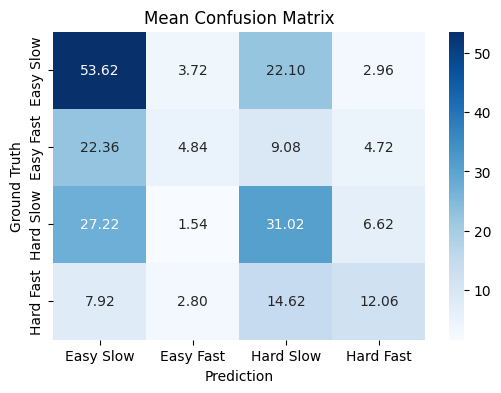

In [14]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'C': [0.1, 1, 10, 100, 1000]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = SVC(kernel='linear', random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_scaled, y):
        X_train, X_test = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1_macro', refit='f1_macro', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred, average='macro'))
        inner_results['recall'].append(recall_score(y_test, y_pred, average='macro'))
        inner_results['f1'].append(f1_score(y_test, y_pred, average='macro'))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

##### Participant-scaled SVC (MultiClass)

! Participant_id and NaN are dropped  
BUT data is scaled based on participant

- Change kernel (?)

In [16]:
# Prepare Dataset
df_svc2 = df.copy().dropna()

def scale_by_participant(group):
    scaler = StandardScaler()
    features = group.drop(columns=['participant_id', 'condition', 'difficulty', 'frequency'])
    group_scaled = pd.DataFrame(scaler.fit_transform(features), columns=features.columns, index=group.index)
    return pd.concat([group_scaled, group[['condition']]], axis=1)
df_svc2_scaled = df_svc2.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)

X_scaled = df_svc2_scaled.drop(columns=['condition'])
y = df_svc2_scaled['condition']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_14632\1360074910.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_svc2_scaled = df_svc2.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [16]:
# Classes unbalance (NaN dropped)
print(f"Diff Low:\t{len(df_svc2_scaled.query("condition == 'Easy_Slow' | condition == 'Easy_Fast'"))}")
print(f"Diff High:\t{len(df_svc2_scaled.query("condition == 'Hard_Slow' | condition == 'Hard_Fast'"))}")

print()

print(f"Freq Low:\t{len(df_svc2_scaled.query("condition == 'Easy_Slow' | condition == 'Hard_Slow'"))}")
print(f"Freq High:\t{len(df_svc2_scaled.query("condition == 'Easy_Fast' | condition == 'Hard_Fast'"))}")

print()
print()

print(f"Easy Slow:\t{len(df_svc2_scaled.query("condition == 'Easy_Slow'"))}")
print(f"Easy Fast:\t{len(df_svc2_scaled.query("condition == 'Easy_Fast'"))}")
print(f"Hard Slow:\t{len(df_svc2_scaled.query("condition == 'Hard_Slow'"))}")
print(f"Hard Fast:\t{len(df_svc2_scaled.query("condition == 'Hard_Fast'"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


Easy Slow:	205
Easy Fast:	412
Hard Slow:	187
Hard Fast:	332


Average Performance across multiple runs:
Accuracy: 51.04%, (~0.78)
Precision: 50.51%, (~1.35)
Recall: 46.37%, (~1.01)
F1 Score: 47.00%, (~1.12)


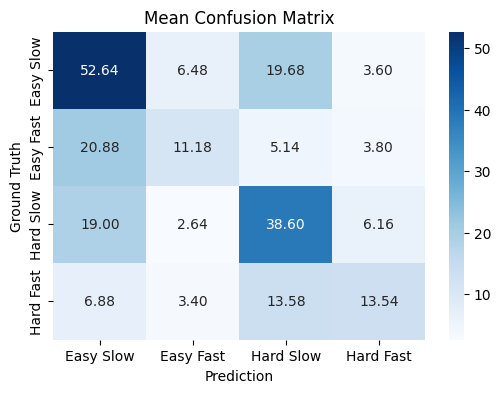

In [17]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'C': [0.1, 1, 10, 100, 1000]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = SVC(kernel='linear', random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_scaled, y):
        X_train, X_test = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1_macro', refit='f1_macro', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred, average='macro'))
        inner_results['recall'].append(recall_score(y_test, y_pred, average='macro'))
        inner_results['f1'].append(f1_score(y_test, y_pred, average='macro'))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

##### Basic SVC (Separated)

In [18]:
# Prepare Datasets
df_svc1_diff = df_diff.copy()
df_svc1_diff = df_svc1_diff.drop(columns=['participant_id']).dropna()
df_svc1_diff['difficulty'] = df_svc1_diff['difficulty'].apply(lambda x: 0 if x == 'Easy' else 1)

X_diff = df_svc1_diff.drop(columns=['difficulty'])
y_diff = df_svc1_diff['difficulty']

scaler = StandardScaler()
X_diff_scaled = scaler.fit_transform(X_diff)
X_diff_scaled = pd.DataFrame(X_diff_scaled, columns=X_diff.columns)

df_svc1_diff_scaled = pd.concat([X_diff_scaled, y_diff.reset_index(drop=True)], axis=1)


df_svc1_freq = df_freq.copy()
df_svc1_freq = df_svc1_freq.drop(columns=['participant_id']).dropna()
df_svc1_freq['frequency'] = df_svc1_freq['frequency'].apply(lambda x: 0 if x == 'Slow' else 1)

X_freq = df_svc1_freq.drop(columns=['frequency'])
y_freq = df_svc1_freq['frequency']

scaler = StandardScaler()
X_freq_scaled = scaler.fit_transform(X_freq)
X_freq_scaled = pd.DataFrame(X_freq_scaled, columns=X_freq.columns)

df_svc1_freq_scaled = pd.concat([X_freq_scaled, y_freq.reset_index(drop=True)], axis=1)

In [19]:
# Classes unbalance (NaN dropped)
print(f"Diff Low:\t{len(df_svc1_diff_scaled.query("difficulty == 0"))}")
print(f"Diff High:\t{len(df_svc1_diff_scaled.query("difficulty == 1"))}")

print()

print(f"Freq Low:\t{len(df_svc1_freq_scaled.query("frequency == 0"))}")
print(f"Freq High:\t{len(df_svc1_freq_scaled.query("frequency == 1"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


Average Performance across multiple runs:
Accuracy: 66.75%, (~0.77)
Precision: 63.86%, (~0.90)
Recall: 63.00%, (~1.10)
F1 Score: 63.31%, (~0.88)


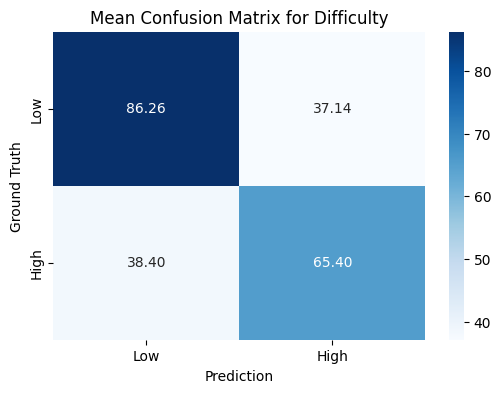

In [20]:
# (Diff) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'C': [0.1, 1, 10, 100, 1000]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = SVC(kernel='linear', random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_diff_scaled, y_diff):
        X_train, X_test = X_diff_scaled.iloc[train_idx], X_diff_scaled.iloc[test_idx]
        y_train, y_test = y_diff.iloc[train_idx], y_diff.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Difficulty')
plt.show()

Average Performance across multiple runs:
Accuracy: 69.22%, (~0.32)
Precision: 70.12%, (~0.23)
Recall: 92.38%, (~0.40)
F1 Score: 79.71%, (~0.22)


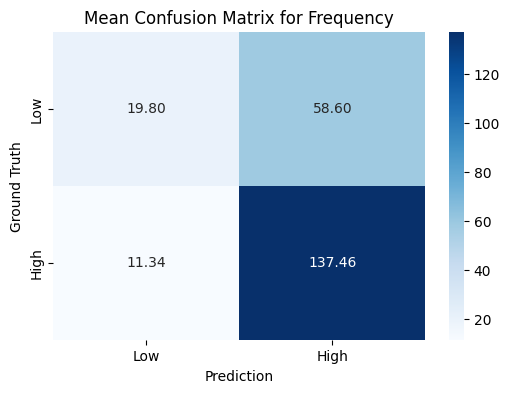

In [21]:
# (Freq) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'C': [0.1, 1, 10, 100, 1000]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = SVC(kernel='linear', random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_freq_scaled, y_freq):
        X_train, X_test = X_freq_scaled.iloc[train_idx], X_freq_scaled.iloc[test_idx]
        y_train, y_test = y_freq.iloc[train_idx], y_freq.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Frequency')
plt.show()

##### Participant-scaled SVC (Separated)

In [4]:
# Prepare Datasets
df_svc2_diff = df_diff.copy().dropna()
df_svc2_diff['difficulty'] = df_svc2_diff['difficulty'].apply(lambda x: 0 if x == 'Easy' else 1)

def scale_by_participant_diff(group):
    scaler = StandardScaler()
    features = group.drop(columns=['participant_id', 'difficulty'])
    group_scaled = pd.DataFrame(scaler.fit_transform(features), columns=features.columns, index=group.index)
    return pd.concat([group_scaled, group[['difficulty']]], axis=1)
df_svc2_diff_scaled = df_svc2_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)

X_diff_scaled = df_svc2_diff_scaled.drop(columns=['difficulty'])
y_diff = df_svc2_diff_scaled['difficulty']


df_svc2_freq = df_freq.copy().dropna()
df_svc2_freq['frequency'] = df_svc2_freq['frequency'].apply(lambda x: 0 if x == 'Slow' else 1)

def scale_by_participant_freq(group):
    scaler = StandardScaler()
    features = group.drop(columns=['participant_id', 'frequency'])
    group_scaled = pd.DataFrame(scaler.fit_transform(features), columns=features.columns, index=group.index)
    return pd.concat([group_scaled, group[['frequency']]], axis=1)
df_svc2_freq_scaled = df_svc2_freq.groupby('participant_id').apply(scale_by_participant_freq).reset_index(drop=True)

X_freq_scaled = df_svc2_freq_scaled.drop(columns=['frequency'])
y_freq = df_svc2_freq_scaled['frequency']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_5400\2440774382.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_svc2_diff_scaled = df_svc2_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)
C:\Users\vale_ad\AppData\Local\Temp\ipykernel_5400\2440774382.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_svc2_freq_scaled = df_svc2_freq.groupby('participant_id').ap

In [23]:
# Classes unbalance (NaN dropped)
print(f"Diff Low:\t{len(df_svc2_diff_scaled.query("difficulty == 0"))}")
print(f"Diff High:\t{len(df_svc2_diff_scaled.query("difficulty == 1"))}")

print()

print(f"Freq Low:\t{len(df_svc2_freq_scaled.query("frequency == 0"))}")
print(f"Freq High:\t{len(df_svc2_freq_scaled.query("frequency == 1"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


Average Performance across multiple runs:
Accuracy: 70.48%, (~0.53)
Precision: 66.66%, (~0.66)
Recall: 71.46%, (~0.70)
F1 Score: 68.84%, (~0.52)


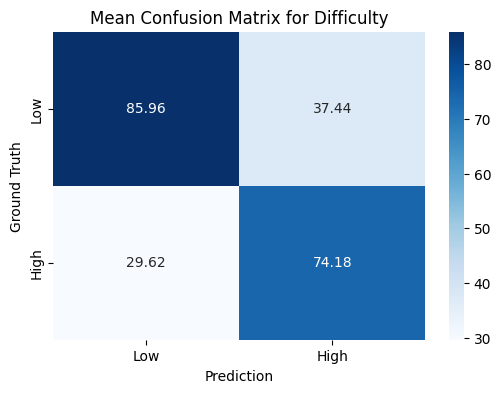

In [24]:
# (Diff) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'C': [0.1, 1, 10, 100, 1000]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = SVC(kernel='linear', random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_diff_scaled, y_diff):
        X_train, X_test = X_diff_scaled.iloc[train_idx], X_diff_scaled.iloc[test_idx]
        y_train, y_test = y_diff.iloc[train_idx], y_diff.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Difficulty')
plt.show()

Average Performance across multiple runs:
Accuracy: 71.51%, (~0.36)
Precision: 72.90%, (~0.23)
Recall: 89.96%, (~0.40)
F1 Score: 80.52%, (~0.26)


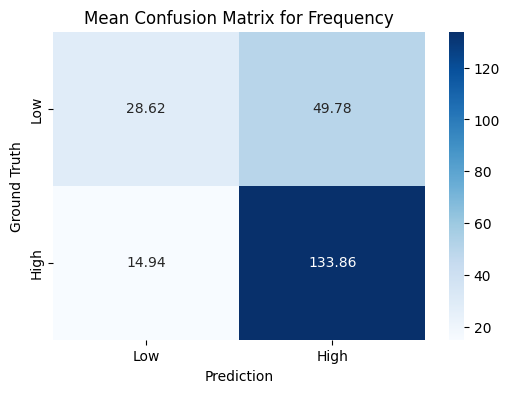

In [25]:
# (Freq) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'C': [0.1, 1, 10, 100, 1000]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = SVC(kernel='linear', random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_freq_scaled, y_freq):
        X_train, X_test = X_freq_scaled.iloc[train_idx], X_freq_scaled.iloc[test_idx]
        y_train, y_test = y_freq.iloc[train_idx], y_freq.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Frequency')
plt.show()

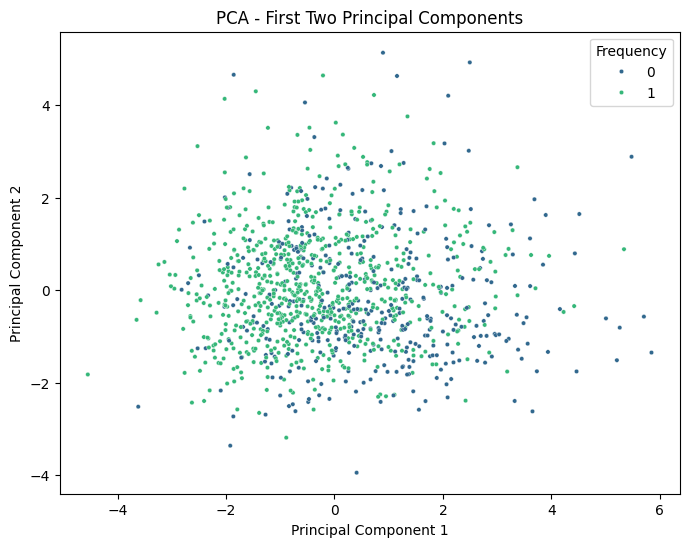

In [26]:
# 2-PC Plot
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_freq_scaled)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['frequency'] = y_freq

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='frequency', data=pca_df, palette='viridis', s=10, alpha=1)
plt.title('PCA - First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Frequency', loc='upper right')
plt.show()

Average Performance across multiple runs:
Accuracy: 71.26%, (~0.55)
Precision: 72.07%, (~0.35)
Recall: 91.71%, (~0.56)
F1 Score: 80.69%, (~0.38)


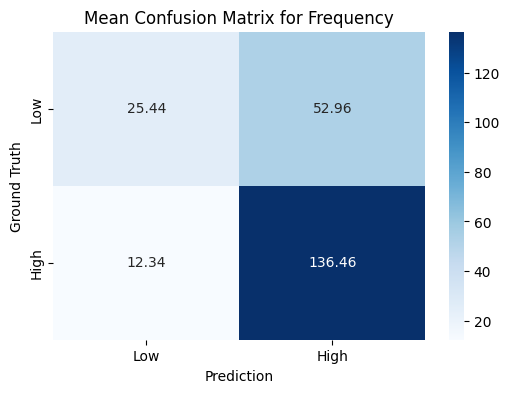

In [27]:
# rbf
# (Freq) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [0.0001, 0.001, 0.01, 0.1]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = SVC(kernel='rbf', random_state=random_state)

    inner_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}
    for train_idx, test_idx in outer_cv.split(X_freq_scaled, y_freq):
        X_train, X_test = X_freq_scaled.iloc[train_idx], X_freq_scaled.iloc[test_idx]
        y_train, y_test = y_freq.iloc[train_idx], y_freq.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Frequency')
plt.show()

##### Undersampled Participant-scaled SVC Classifier (Separated)

In [28]:
# Prepare Datasets
df_svc3_diff = df_diff.copy().dropna()
df_svc3_diff['difficulty'] = df_svc3_diff['difficulty'].apply(lambda x: 0 if x == 'Easy' else 1)

df_svc3_diff_scaled = df_svc3_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)

X_diff_scaled = df_svc3_diff_scaled.drop(columns=['difficulty'])
y_diff = df_svc3_diff_scaled['difficulty']


df_svc3_freq = df_freq.copy().dropna()
df_svc3_freq['frequency'] = df_svc3_freq['frequency'].apply(lambda x: 0 if x == 'Slow' else 1)

df_svc3_freq_scaled = df_svc3_freq.groupby('participant_id').apply(scale_by_participant_freq).reset_index(drop=True)

X_freq_scaled = df_svc3_freq_scaled.drop(columns=['frequency'])
y_freq = df_svc3_freq_scaled['frequency']

undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=random_state)
X_diff_scaled_us, y_diff_us = undersampler.fit_resample(X_diff_scaled, y_diff)
X_freq_scaled_us, y_freq_us = undersampler.fit_resample(X_freq_scaled, y_freq)

df_svc3_diff_scaled_us = X_diff_scaled_us.join(y_diff_us)
df_svc3_freq_scaled_us = X_freq_scaled_us.join(y_freq_us)

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\335927043.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_svc3_diff_scaled = df_svc3_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)
C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\335927043.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_svc3_freq_scaled = df_svc3_freq.groupby('participant_id').app

In [29]:
# Classes (un)balance
print(f"Diff Low:\t{len(df_svc3_diff_scaled_us.query("difficulty == 0"))}")
print(f"Diff High:\t{len(df_svc3_diff_scaled_us.query("difficulty == 1"))}")

print()

print(f"Freq Low:\t{len(df_svc3_freq_scaled_us.query("frequency == 0"))}")
print(f"Freq High:\t{len(df_svc3_freq_scaled_us.query("frequency == 1"))}")

Diff Low:	519
Diff High:	519

Freq Low:	392
Freq High:	392


Average Performance across multiple runs:
Accuracy: 70.39%, (~0.66)
Precision: 68.20%, (~0.75)
Recall: 76.57%, (~0.69)
F1 Score: 72.08%, (~0.57)


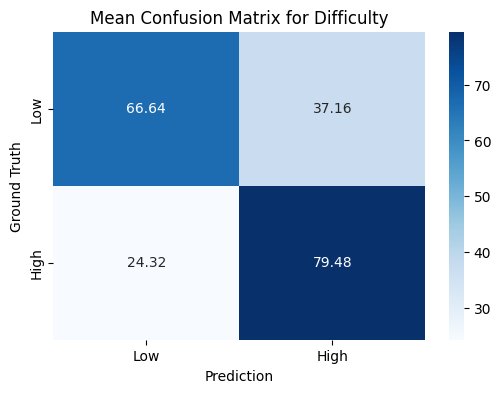

In [30]:
# (Diff) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'C': [0.1, 1, 10, 100, 1000]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=random_state)
    X_diff_scaled_us, y_diff_us = undersampler.fit_resample(X_diff_scaled, y_diff)

    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = SVC(kernel='linear', random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }    
    for train_idx, test_idx in outer_cv.split(X_diff_scaled_us, y_diff_us):
        X_train, X_test = X_diff_scaled_us.iloc[train_idx], X_diff_scaled_us.iloc[test_idx]
        y_train, y_test = y_diff_us.iloc[train_idx], y_diff_us.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Difficulty')
plt.show()

Average Performance across multiple runs:
Accuracy: 68.74%, (~0.97)
Precision: 67.74%, (~0.80)
Recall: 71.74%, (~2.12)
F1 Score: 69.58%, (~1.20)


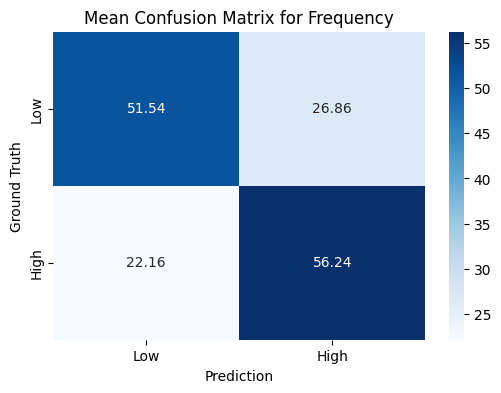

In [31]:
# (Freq) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'C': [0.1, 1, 10, 100, 1000]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=random_state)
    X_freq_scaled_us, y_freq_us = undersampler.fit_resample(X_freq_scaled, y_freq)

    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = SVC(kernel='linear', random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_freq_scaled_us, y_freq_us):
        X_train, X_test = X_freq_scaled_us.iloc[train_idx], X_freq_scaled_us.iloc[test_idx]
        y_train, y_test = y_freq_us.iloc[train_idx], y_freq_us.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Frequency')
plt.show()

##### Oversampled Participant-scaled SVC Classifier (Separated)

In [32]:
# Prepare Datasets
df_svc4_diff = df_diff.copy().dropna()
df_svc4_diff['difficulty'] = df_svc4_diff['difficulty'].apply(lambda x: 0 if x == 'Easy' else 1)

df_svc4_diff_scaled = df_svc4_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)

X_diff_scaled = df_svc4_diff_scaled.drop(columns=['difficulty'])
y_diff = df_svc4_diff_scaled['difficulty']


df_svc4_freq = df_freq.copy().dropna()
df_svc4_freq['frequency'] = df_svc4_freq['frequency'].apply(lambda x: 0 if x == 'Slow' else 1)

df_svc4_freq_scaled = df_svc4_freq.groupby('participant_id').apply(scale_by_participant_freq).reset_index(drop=True)

X_freq_scaled = df_svc4_freq_scaled.drop(columns=['frequency'])
y_freq = df_svc4_freq_scaled['frequency']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\1834839937.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_svc4_diff_scaled = df_svc4_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)
C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\1834839937.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_svc4_freq_scaled = df_svc4_freq.groupby('participant_id').a

In [33]:
# Classes (un)balance (NaN dropped)
print(f"Diff Low:\t{len(df_svc4_diff_scaled.query("difficulty == 0"))}")
print(f"Diff High:\t{len(df_svc4_diff_scaled.query("difficulty == 1"))}")

print()

print(f"Freq Low:\t{len(df_svc4_freq_scaled.query("frequency == 0"))}")
print(f"Freq High:\t{len(df_svc4_freq_scaled.query("frequency == 1"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


Average Performance across multiple runs:
Accuracy: 69.71%, (~0.33)
Precision: 64.34%, (~0.28)
Recall: 76.21%, (~0.79)
F1 Score: 69.67%, (~0.38)


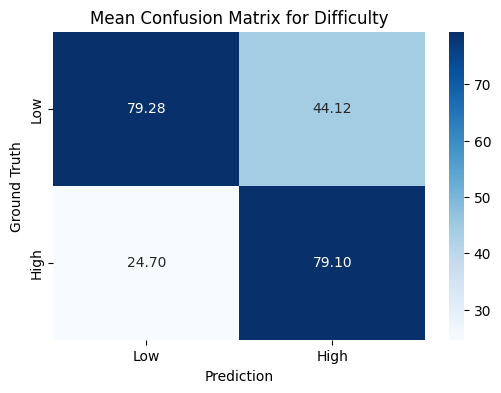

In [34]:
# (Diff) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__C': [0.1, 1, 10, 100, 1000]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        ('model', SVC(kernel='linear', random_state=random_state))
    ])
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }    
    for train_idx, test_idx in outer_cv.split(X_diff_scaled, y_diff):
        X_train, X_test = X_diff_scaled.iloc[train_idx], X_diff_scaled.iloc[test_idx]
        y_train, y_test = y_diff.iloc[train_idx], y_diff.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Difficulty')
plt.show()

Average Performance across multiple runs:
Accuracy: 69.48%, (~0.54)
Precision: 79.89%, (~0.32)
Recall: 71.42%, (~0.81)
F1 Score: 75.37%, (~0.56)


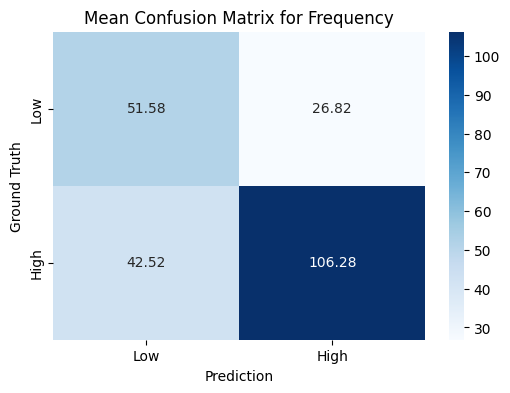

In [35]:
# (Freq) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__C': [0.1, 1, 10, 100, 1000]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        ('model', SVC(kernel='linear', random_state=random_state))
    ])
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_freq_scaled, y_freq):
        X_train, X_test = X_freq_scaled.iloc[train_idx], X_freq_scaled.iloc[test_idx]
        y_train, y_test = y_freq.iloc[train_idx], y_freq.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Frequency')
plt.show()

Average Performance across multiple runs:
Accuracy: 69.69%, (~0.17)
Precision: 71.96%, (~0.27)
Recall: 88.10%, (~0.60)
F1 Score: 79.20%, (~0.15)


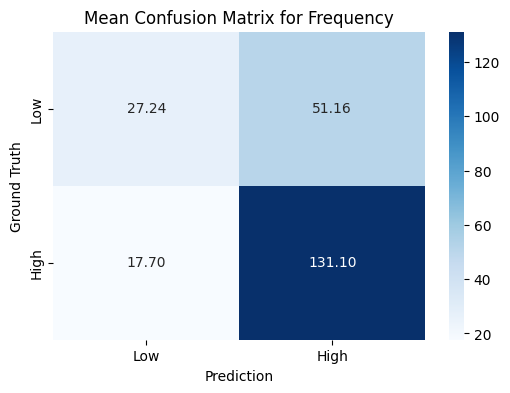

In [36]:
# rbf
# (Freq) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__C': [0.1, 1, 10, 100, 1000],
    'model__gamma': [0.0001, 0.001, 0.01, 0.1]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        ('model', SVC(kernel='rbf', random_state=random_state))
    ])
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    inner_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
}
    for train_idx, test_idx in outer_cv.split(X_freq_scaled, y_freq):
        X_train, X_test = X_freq_scaled.iloc[train_idx], X_freq_scaled.iloc[test_idx]
        y_train, y_test = y_freq.iloc[train_idx], y_freq.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Frequency')
plt.show()

##### Participant-folded SVC (Separated)

In [7]:
# Prepare Datasets
df_svc5_diff = df_diff.copy().dropna()
df_svc5_diff['difficulty'] = df_svc5_diff['difficulty'].apply(lambda x: 0 if x == 'Easy' else 1)
df_svc5_diff_scaled = df_svc5_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)
participants_ids_diff = df_svc5_diff.reset_index(drop=True)['participant_id']

X_diff_scaled = df_svc5_diff_scaled.drop(columns=['difficulty'])
y_diff = df_svc5_diff_scaled['difficulty']


df_svc5_freq = df_freq.copy().dropna()
df_svc5_freq['frequency'] = df_svc5_freq['frequency'].apply(lambda x: 0 if x == 'Slow' else 1)
df_svc5_freq_scaled = df_svc5_freq.groupby('participant_id').apply(scale_by_participant_freq).reset_index(drop=True)
participants_ids_freq = df_svc5_freq.reset_index(drop=True)['participant_id']

X_freq_scaled = df_svc5_freq_scaled.drop(columns=['frequency'])
y_freq = df_svc5_freq_scaled['frequency']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_4212\1782602246.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_svc5_diff_scaled = df_svc5_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)
C:\Users\vale_ad\AppData\Local\Temp\ipykernel_4212\1782602246.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_svc5_freq_scaled = df_svc5_freq.groupby('participant_id').app

In [288]:
# Classes unbalance (NaN dropped)
print(f"Diff Low:\t{len(df_svc5_diff_scaled.query("difficulty == 0"))}")
print(f"Diff High:\t{len(df_svc5_diff_scaled.query("difficulty == 1"))}")

print()

print(f"Freq Low:\t{len(df_svc5_freq_scaled.query("frequency == 0"))}")
print(f"Freq High:\t{len(df_svc5_freq_scaled.query("frequency == 1"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


Average Performance across multiple runs:
Accuracy: 69.29%, (~0.07)
Precision: 65.24%, (~0.08)
Recall: 70.18%, (~0.00)
F1 Score: 67.53%, (~0.05)


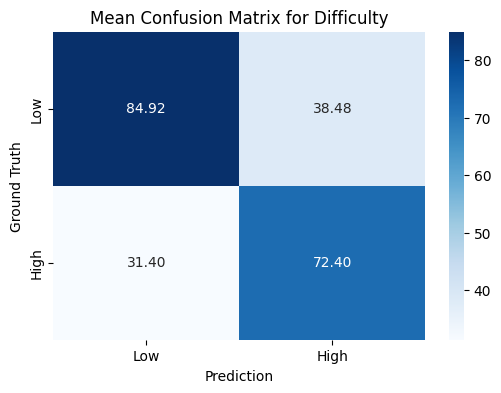

In [289]:
# (Diff) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'C': [0.1, 1, 10, 100, 1000]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_diff_scaled, y_diff, participants_ids_diff, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)
    model = SVC(kernel='linear', random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Difficulty')
plt.show()

In [290]:
outer_results['best_params']

[[{'C': 0.1}, {'C': 0.1}, {'C': 0.1}, {'C': 1}, {'C': 10}],
 [{'C': 0.1}, {'C': 0.1}, {'C': 0.1}, {'C': 1}, {'C': 1000}],
 [{'C': 0.1}, {'C': 0.1}, {'C': 0.1}, {'C': 1}, {'C': 1000}],
 [{'C': 0.1}, {'C': 0.1}, {'C': 0.1}, {'C': 1000}, {'C': 1000}],
 [{'C': 0.1}, {'C': 0.1}, {'C': 0.1}, {'C': 1}, {'C': 1000}],
 [{'C': 0.1}, {'C': 0.1}, {'C': 0.1}, {'C': 1}, {'C': 1000}],
 [{'C': 0.1}, {'C': 0.1}, {'C': 0.1}, {'C': 1}, {'C': 100}],
 [{'C': 0.1}, {'C': 0.1}, {'C': 0.1}, {'C': 1000}, {'C': 1000}],
 [{'C': 0.1}, {'C': 0.1}, {'C': 0.1}, {'C': 1}, {'C': 1000}],
 [{'C': 0.1}, {'C': 0.1}, {'C': 0.1}, {'C': 1000}, {'C': 1000}]]

Average Performance across multiple runs:
Accuracy: 71.35%, (~0.00)
Precision: 72.71%, (~0.00)
Recall: 89.89%, (~0.00)
F1 Score: 80.38%, (~0.00)


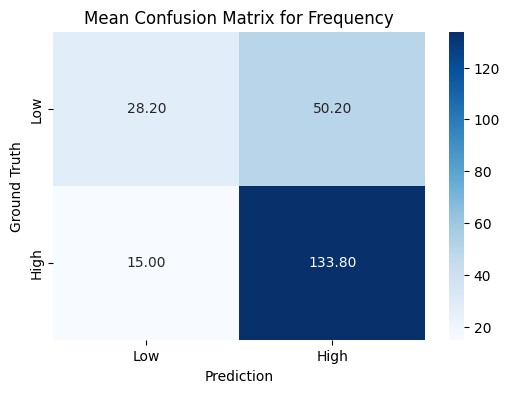

In [291]:
# (Freq) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'C': [0.1, 1, 10, 100, 1000]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_freq_scaled, y_freq, participants_ids_freq, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)
    model = SVC(kernel='linear', random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Frequency')
plt.show()

In [292]:
outer_results['best_params']

[[{'C': 0.1}, {'C': 1000}, {'C': 0.1}, {'C': 1}, {'C': 0.1}],
 [{'C': 0.1}, {'C': 10}, {'C': 0.1}, {'C': 1}, {'C': 0.1}],
 [{'C': 0.1}, {'C': 100}, {'C': 0.1}, {'C': 1}, {'C': 0.1}],
 [{'C': 0.1}, {'C': 1000}, {'C': 0.1}, {'C': 1}, {'C': 0.1}],
 [{'C': 0.1}, {'C': 100}, {'C': 0.1}, {'C': 1}, {'C': 0.1}],
 [{'C': 0.1}, {'C': 1000}, {'C': 0.1}, {'C': 1}, {'C': 0.1}],
 [{'C': 0.1}, {'C': 1000}, {'C': 0.1}, {'C': 1}, {'C': 0.1}],
 [{'C': 0.1}, {'C': 1000}, {'C': 0.1}, {'C': 1}, {'C': 0.1}],
 [{'C': 0.1}, {'C': 1}, {'C': 0.1}, {'C': 1}, {'C': 0.1}],
 [{'C': 0.1}, {'C': 1000}, {'C': 0.1}, {'C': 1}, {'C': 0.1}]]

Average Performance across multiple runs:
Accuracy: 69.55%, (~0.00)
Precision: 70.97%, (~0.00)
Recall: 90.37%, (~0.00)
F1 Score: 79.48%, (~0.00)


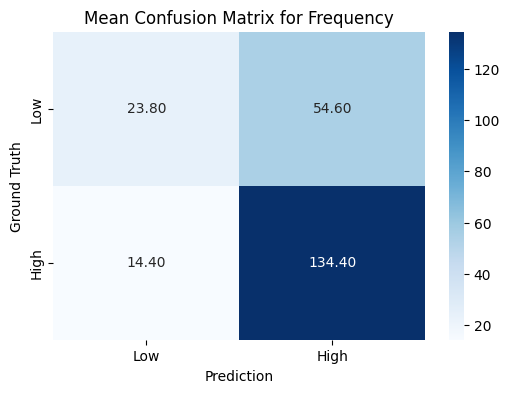

In [8]:
# rbf
# (Freq) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [0.0001, 0.001, 0.01, 0.1]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_freq_scaled, y_freq, participants_ids_freq, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)
    model = SVC(kernel='rbf', random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Frequency')
plt.show()

In [294]:
outer_results['best_params']

[[{'C': 10, 'gamma': 0.01},
  {'C': 100, 'gamma': 0.0001},
  {'C': 1, 'gamma': 0.01},
  {'C': 10, 'gamma': 0.001},
  {'C': 1000, 'gamma': 0.001}],
 [{'C': 100, 'gamma': 0.0001},
  {'C': 100, 'gamma': 0.001},
  {'C': 1, 'gamma': 0.01},
  {'C': 100, 'gamma': 0.001},
  {'C': 10, 'gamma': 0.01}],
 [{'C': 1, 'gamma': 0.01},
  {'C': 100, 'gamma': 0.001},
  {'C': 1000, 'gamma': 0.001},
  {'C': 1, 'gamma': 0.01},
  {'C': 10, 'gamma': 0.001}],
 [{'C': 100, 'gamma': 0.001},
  {'C': 100, 'gamma': 0.001},
  {'C': 1000, 'gamma': 0.0001},
  {'C': 1, 'gamma': 0.01},
  {'C': 1000, 'gamma': 0.0001}],
 [{'C': 100, 'gamma': 0.001},
  {'C': 1000, 'gamma': 0.0001},
  {'C': 1000, 'gamma': 0.001},
  {'C': 10, 'gamma': 0.01},
  {'C': 1000, 'gamma': 0.0001}],
 [{'C': 100, 'gamma': 0.01},
  {'C': 100, 'gamma': 0.001},
  {'C': 10, 'gamma': 0.01},
  {'C': 100, 'gamma': 0.001},
  {'C': 1000, 'gamma': 0.001}],
 [{'C': 10, 'gamma': 0.01},
  {'C': 10, 'gamma': 0.001},
  {'C': 1000, 'gamma': 0.001},
  {'C': 100, 'gamm

##### Oversampled Participant-folded SVC Classifier (Separated)

In [8]:
# Prepare Datasets
df_svc6_diff = df_diff.copy().dropna()
df_svc6_diff['difficulty'] = df_svc6_diff['difficulty'].apply(lambda x: 0 if x == 'Easy' else 1)
participants_ids_diff = df_svc6_diff.reset_index(drop=True)['participant_id']

df_svc6_diff_scaled = df_svc6_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)

X_diff_scaled = df_svc6_diff_scaled.drop(columns=['difficulty'])
X_diff_scaled_p = X_diff_scaled.copy()
X_diff_scaled_p['participant_id'] = participants_ids_diff
y_diff = df_svc6_diff_scaled['difficulty']



df_svc6_freq = df_freq.copy().dropna()
df_svc6_freq['frequency'] = df_svc6_freq['frequency'].apply(lambda x: 0 if x == 'Slow' else 1)
participants_ids_freq = df_svc6_freq.reset_index(drop=True)['participant_id']

df_svc6_freq_scaled = df_svc6_freq.groupby('participant_id').apply(scale_by_participant_freq).reset_index(drop=True)

X_freq_scaled = df_svc6_freq_scaled.drop(columns=['frequency'])
X_freq_scaled_p = X_freq_scaled.copy()
X_freq_scaled_p['participant_id'] = participants_ids_freq
y_freq = df_svc6_freq_scaled['frequency']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_11692\4104186174.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_svc6_diff_scaled = df_svc6_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)
C:\Users\vale_ad\AppData\Local\Temp\ipykernel_11692\4104186174.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_svc6_freq_scaled = df_svc6_freq.groupby('participant_id').a

In [9]:
# Classes (un)balance (NaN dropped)
print(f"Diff Low:\t{len(df_svc6_diff_scaled.query("difficulty == 0"))}")
print(f"Diff High:\t{len(df_svc6_diff_scaled.query("difficulty == 1"))}")

print()

print(f"Freq Low:\t{len(df_svc6_freq_scaled.query("frequency == 0"))}")
print(f"Freq High:\t{len(df_svc6_freq_scaled.query("frequency == 1"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


Average Performance across multiple runs:
Accuracy: 69.15%, (~0.31)
Precision: 63.76%, (~0.32)
Recall: 75.31%, (~0.55)
F1 Score: 68.97%, (~0.32)


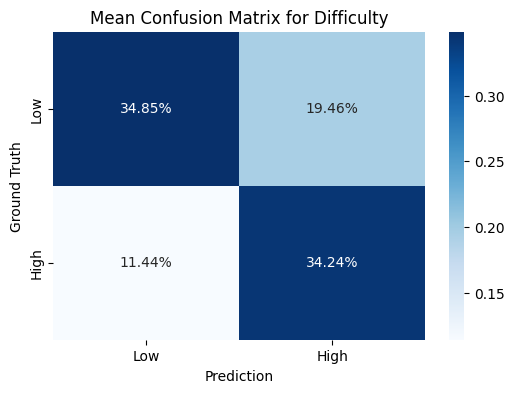

In [10]:
# Group-folded nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__C': [0.1, 1, 10, 100, 1000]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        ('model', SVC(kernel='linear', random_state=random_state))
    ])
    participants_ids_diff = X_diff_scaled_p['participant_id']
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_diff_scaled, y_diff, participants_ids_diff, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }    
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Difficulty')
plt.show()

In [298]:
outer_results['best_params']

[[{'model__C': 1000},
  {'model__C': 1},
  {'model__C': 1000},
  {'model__C': 1000},
  {'model__C': 1}],
 [{'model__C': 1000},
  {'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 1}],
 [{'model__C': 10},
  {'model__C': 1000},
  {'model__C': 10},
  {'model__C': 10},
  {'model__C': 0.1}],
 [{'model__C': 10},
  {'model__C': 0.1},
  {'model__C': 10},
  {'model__C': 0.1},
  {'model__C': 0.1}],
 [{'model__C': 10},
  {'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 1},
  {'model__C': 10}],
 [{'model__C': 100},
  {'model__C': 1000},
  {'model__C': 0.1},
  {'model__C': 10},
  {'model__C': 100}],
 [{'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 1},
  {'model__C': 1},
  {'model__C': 1000}],
 [{'model__C': 1},
  {'model__C': 0.1},
  {'model__C': 1000},
  {'model__C': 0.1},
  {'model__C': 10}],
 [{'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 10},
  {'model__C': 0.1}],
 [{'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 1},
 

Average Performance across multiple runs:
Accuracy: 68.41%, (~0.47)
Precision: 79.27%, (~0.30)
Recall: 70.14%, (~0.87)
F1 Score: 74.37%, (~0.51)


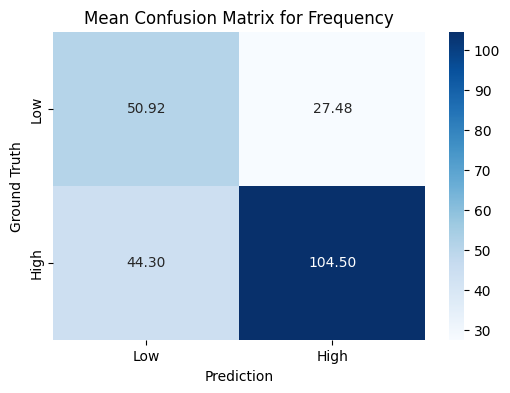

In [299]:
# (Freq) Group-folded nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__C': [0.1, 1, 10, 100, 1000]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        ('model', SVC(kernel='linear', random_state=random_state))
    ])
    participants_ids_freq = X_freq_scaled_p['participant_id']
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_freq_scaled, y_freq, participants_ids_freq, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)
    
    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }    
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Frequency')
plt.show()

In [300]:
outer_results['best_params']

[[{'model__C': 0.1},
  {'model__C': 1},
  {'model__C': 0.1},
  {'model__C': 10},
  {'model__C': 1}],
 [{'model__C': 0.1},
  {'model__C': 1},
  {'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 1000}],
 [{'model__C': 1000},
  {'model__C': 1},
  {'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 100}],
 [{'model__C': 10},
  {'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 1},
  {'model__C': 10}],
 [{'model__C': 1},
  {'model__C': 1},
  {'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 0.1}],
 [{'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 100}],
 [{'model__C': 0.1},
  {'model__C': 1000},
  {'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 0.1}],
 [{'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 10},
  {'model__C': 0.1},
  {'model__C': 10}],
 [{'model__C': 0.1},
  {'model__C': 1},
  {'model__C': 0.1},
  {'model__C': 10},
  {'model__C': 1}],
 [{'model__C': 1000},
  {'model__C': 10},
  {'model__C': 0.1},
  {'

Average Performance across multiple runs:
Accuracy: 69.67%, (~0.28)
Precision: 72.04%, (~0.30)
Recall: 87.78%, (~0.28)
F1 Score: 79.10%, (~0.15)


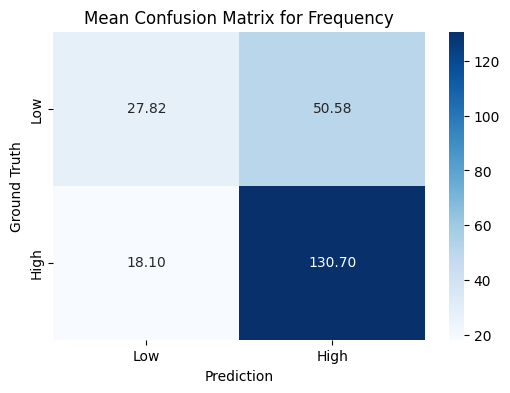

In [10]:
# rbf
# (Freq) Group-folded nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__C': [0.1, 1, 10, 100, 1000],
    'model__gamma': [0.0001, 0.001, 0.01, 0.1]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        ('model', SVC(kernel='rbf', random_state=random_state))
    ])
    participants_ids = X_freq_scaled_p['participant_id']
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_freq_scaled, y_freq, participants_ids_freq, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)

    inner_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)
    
    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Frequency')
plt.show()

In [302]:
outer_results['best_params']

[[{'model__C': 0.1, 'model__gamma': 0.0001},
  {'model__C': 0.1, 'model__gamma': 0.001},
  {'model__C': 0.1, 'model__gamma': 0.0001},
  {'model__C': 0.1, 'model__gamma': 0.001},
  {'model__C': 0.1, 'model__gamma': 0.001}],
 [{'model__C': 0.1, 'model__gamma': 0.001},
  {'model__C': 0.1, 'model__gamma': 0.001},
  {'model__C': 0.1, 'model__gamma': 0.0001},
  {'model__C': 0.1, 'model__gamma': 0.001},
  {'model__C': 0.1, 'model__gamma': 0.0001}],
 [{'model__C': 0.1, 'model__gamma': 0.0001},
  {'model__C': 0.1, 'model__gamma': 0.0001},
  {'model__C': 0.1, 'model__gamma': 0.0001},
  {'model__C': 0.1, 'model__gamma': 0.0001},
  {'model__C': 0.1, 'model__gamma': 0.0001}],
 [{'model__C': 0.1, 'model__gamma': 0.0001},
  {'model__C': 0.1, 'model__gamma': 0.001},
  {'model__C': 0.1, 'model__gamma': 0.0001},
  {'model__C': 0.1, 'model__gamma': 0.001},
  {'model__C': 0.1, 'model__gamma': 0.0001}],
 [{'model__C': 0.1, 'model__gamma': 0.001},
  {'model__C': 0.1, 'model__gamma': 0.0001},
  {'model__C': 

##### Undersampled Participant-folded SVC Classifier (Separated)

In [11]:
# Prepare Datasets
df_svc7_diff = df_diff.copy().dropna()
df_svc7_diff['difficulty'] = df_svc7_diff['difficulty'].apply(lambda x: 0 if x == 'Easy' else 1)
participants_ids_diff = df_svc7_diff.reset_index(drop=True)['participant_id']

df_svc7_diff_scaled = df_svc7_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)

X_diff_scaled = df_svc7_diff_scaled.drop(columns=['difficulty'])
X_diff_scaled_p = X_diff_scaled.copy()
X_diff_scaled_p['participant_id'] = participants_ids_diff
y_diff = df_svc7_diff_scaled['difficulty']



df_svc7_freq = df_freq.copy().dropna()
df_svc7_freq['frequency'] = df_svc7_freq['frequency'].apply(lambda x: 0 if x == 'Slow' else 1)
participants_ids_freq = df_svc7_freq.reset_index(drop=True)['participant_id']

df_svc7_freq_scaled = df_svc7_freq.groupby('participant_id').apply(scale_by_participant_freq).reset_index(drop=True)

X_freq_scaled = df_svc7_freq_scaled.drop(columns=['frequency'])
X_freq_scaled_p = X_freq_scaled.copy()
X_freq_scaled_p['participant_id'] = participants_ids_freq
y_freq = df_svc7_freq_scaled['frequency']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_4212\2052106529.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_svc7_diff_scaled = df_svc7_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)
C:\Users\vale_ad\AppData\Local\Temp\ipykernel_4212\2052106529.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_svc7_freq_scaled = df_svc7_freq.groupby('participant_id').app

In [304]:
# Classes (un)balance (NaN dropped)
print(f"Diff Low:\t{len(df_svc7_diff_scaled.query("difficulty == 0"))}")
print(f"Diff High:\t{len(df_svc7_diff_scaled.query("difficulty == 1"))}")

print()

print(f"Freq Low:\t{len(df_svc7_freq_scaled.query("frequency == 0"))}")
print(f"Freq High:\t{len(df_svc7_freq_scaled.query("frequency == 1"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


Average Performance across multiple runs:
Accuracy: 69.12%, (~0.32)
Precision: 63.78%, (~0.38)
Recall: 75.11%, (~0.57)
F1 Score: 68.89%, (~0.30)


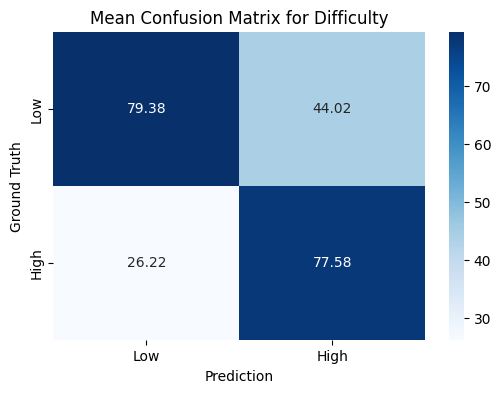

In [305]:
# (Diff) Group-folded nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__C': [0.1, 1, 10, 100, 1000]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('undersample', RandomUnderSampler(sampling_strategy='auto', random_state=random_state)),
        ('model', SVC(kernel='linear', random_state=random_state))
    ])
    participants_ids_diff = X_diff_scaled_p['participant_id']
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_diff_scaled, y_diff, participants_ids_diff, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }    
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Difficulty')
plt.show()

In [306]:
outer_results['best_params']

[[{'model__C': 1},
  {'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 1}],
 [{'model__C': 10},
  {'model__C': 0.1},
  {'model__C': 1},
  {'model__C': 1},
  {'model__C': 10}],
 [{'model__C': 1},
  {'model__C': 1},
  {'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 1000}],
 [{'model__C': 0.1},
  {'model__C': 10},
  {'model__C': 10},
  {'model__C': 0.1},
  {'model__C': 1000}],
 [{'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 1000},
  {'model__C': 10}],
 [{'model__C': 1},
  {'model__C': 1},
  {'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 0.1}],
 [{'model__C': 10},
  {'model__C': 0.1},
  {'model__C': 1},
  {'model__C': 1000},
  {'model__C': 0.1}],
 [{'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 1},
  {'model__C': 0.1}],
 [{'model__C': 0.1},
  {'model__C': 1},
  {'model__C': 1},
  {'model__C': 0.1},
  {'model__C': 10}],
 [{'model__C': 10},
  {'model__C': 0.1},
  {'model__C': 0.1},
  {'model__

Average Performance across multiple runs:
Accuracy: 68.69%, (~0.53)
Precision: 79.27%, (~0.31)
Recall: 70.66%, (~0.78)
F1 Score: 74.66%, (~0.51)


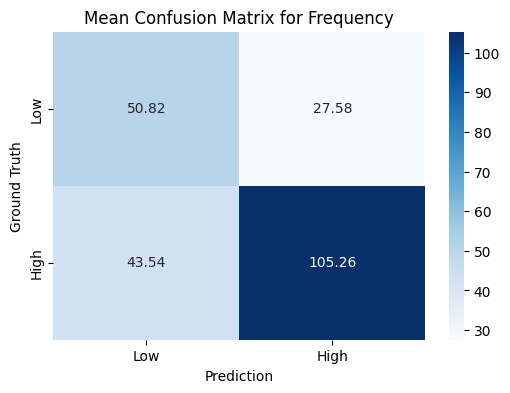

In [307]:
# (Freq) Group-folded nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__C': [0.1, 1, 10, 100, 1000]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('undersample', RandomUnderSampler(sampling_strategy='auto', random_state=random_state)),
        ('model', SVC(kernel='linear', random_state=random_state))
    ])
    participants_ids_freq = X_freq_scaled_p['participant_id']
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_freq_scaled, y_freq, participants_ids_freq, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)
    
    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }    
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Frequency')
plt.show()

In [308]:
outer_results['best_params']

[[{'model__C': 10},
  {'model__C': 10},
  {'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 0.1}],
 [{'model__C': 10},
  {'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 1},
  {'model__C': 0.1}],
 [{'model__C': 1},
  {'model__C': 1000},
  {'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 1000}],
 [{'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 1},
  {'model__C': 100},
  {'model__C': 0.1}],
 [{'model__C': 100},
  {'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 1},
  {'model__C': 0.1}],
 [{'model__C': 1000},
  {'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 1},
  {'model__C': 10}],
 [{'model__C': 1},
  {'model__C': 0.1},
  {'model__C': 10},
  {'model__C': 1},
  {'model__C': 0.1}],
 [{'model__C': 0.1},
  {'model__C': 1},
  {'model__C': 10},
  {'model__C': 1},
  {'model__C': 0.1}],
 [{'model__C': 0.1},
  {'model__C': 100},
  {'model__C': 0.1},
  {'model__C': 10},
  {'model__C': 0.1}],
 [{'model__C': 10},
  {'model__C': 1},
  {'model__C': 0.1},
  {'mode

Average Performance across multiple runs:
Accuracy: 69.64%, (~0.41)
Precision: 72.10%, (~0.47)
Recall: 87.56%, (~0.62)
F1 Score: 79.04%, (~0.23)


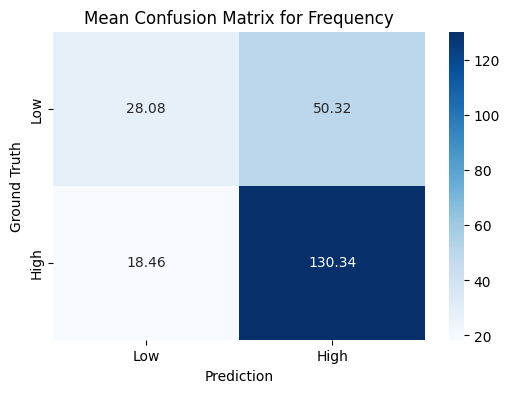

In [12]:
# rbf
# (Freq) Group-folded nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__C': [0.1, 1, 10, 100, 1000],
    'model__gamma': [0.0001, 0.001, 0.01, 0.1]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('undersample', RandomUnderSampler(sampling_strategy='auto', random_state=random_state)),
        ('model', SVC(kernel='rbf', random_state=random_state))
    ])
    participants_ids = X_freq_scaled_p['participant_id']
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_freq_scaled, y_freq, participants_ids_freq, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)

    inner_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)
    
    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Frequency')
plt.show()

In [310]:
outer_results['best_params']

[[{'model__C': 0.1, 'model__gamma': 0.0001},
  {'model__C': 0.1, 'model__gamma': 0.001},
  {'model__C': 0.1, 'model__gamma': 0.0001},
  {'model__C': 0.1, 'model__gamma': 0.0001},
  {'model__C': 0.1, 'model__gamma': 0.001}],
 [{'model__C': 0.1, 'model__gamma': 0.001},
  {'model__C': 0.1, 'model__gamma': 0.001},
  {'model__C': 0.1, 'model__gamma': 0.001},
  {'model__C': 0.1, 'model__gamma': 0.0001},
  {'model__C': 0.1, 'model__gamma': 0.0001}],
 [{'model__C': 0.1, 'model__gamma': 0.001},
  {'model__C': 0.1, 'model__gamma': 0.0001},
  {'model__C': 0.1, 'model__gamma': 0.001},
  {'model__C': 0.1, 'model__gamma': 0.0001},
  {'model__C': 0.1, 'model__gamma': 0.001}],
 [{'model__C': 0.1, 'model__gamma': 0.001},
  {'model__C': 0.1, 'model__gamma': 0.0001},
  {'model__C': 0.1, 'model__gamma': 0.0001},
  {'model__C': 0.1, 'model__gamma': 0.001},
  {'model__C': 0.1, 'model__gamma': 0.001}],
 [{'model__C': 0.1, 'model__gamma': 0.0001},
  {'model__C': 0.1, 'model__gamma': 0.001},
  {'model__C': 0.1

##### Participant-folded SVC (MultiClass)

In [23]:
# Prepare Dataset
df_svc8 = df.copy().dropna()
df_svc8_scaled = df_svc8.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)
participants_ids = df_svc8.reset_index(drop=True)['participant_id']

X_scaled = df_svc8_scaled.drop(columns=['condition'])
X_scaled_p = X_scaled.copy()
X_scaled_p['participant_id'] = participants_ids
y = df_svc8_scaled['condition']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_14632\1372906193.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_svc8_scaled = df_svc8.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [24]:
# Classes unbalance (NaN dropped)
print(f"Diff Low:\t{len(df_svc8_scaled.query("condition == 'Easy_Slow' | condition == 'Easy_Fast'"))}")
print(f"Diff High:\t{len(df_svc8_scaled.query("condition == 'Hard_Slow' | condition == 'Hard_Fast'"))}")

print()

print(f"Freq Low:\t{len(df_svc8_scaled.query("condition == 'Easy_Slow' | condition == 'Hard_Slow'"))}")
print(f"Freq High:\t{len(df_svc8_scaled.query("condition == 'Easy_Fast' | condition == 'Hard_Fast'"))}")

print()
print()

print(f"Easy Slow:\t{len(df_svc8_scaled.query("condition == 'Easy_Slow'"))}")
print(f"Easy Fast:\t{len(df_svc8_scaled.query("condition == 'Easy_Fast'"))}")
print(f"Hard Slow:\t{len(df_svc8_scaled.query("condition == 'Hard_Slow'"))}")
print(f"Hard Fast:\t{len(df_svc8_scaled.query("condition == 'Hard_Fast'"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


Easy Slow:	205
Easy Fast:	412
Hard Slow:	187
Hard Fast:	332


Average Performance across multiple runs:
Accuracy: 51.65%, (~0.08)
Precision: 50.84%, (~0.09)
Recall: 46.91%, (~0.07)
F1 Score: 47.47%, (~0.07)


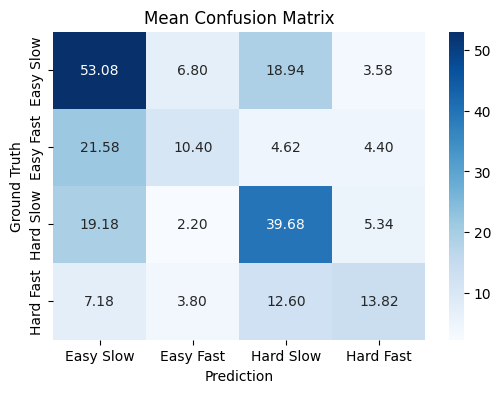

In [6]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__C': [0.1, 1, 10, 100, 1000],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        # ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        # ('undersample', RandomUnderSampler(sampling_strategy='auto', random_state=random_state)),
        ('model', SVC(kernel='linear', random_state=random_state))
    ])
    participants_ids = X_scaled_p['participant_id']
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_scaled, y, participants_ids, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='recall_macro', refit='recall_macro', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred, average='macro', zero_division=0))
        inner_results['recall'].append(recall_score(y_test, y_pred, average='macro'))
        inner_results['f1'].append(f1_score(y_test, y_pred, average='macro'))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred, labels=class_order))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

In [7]:
outer_results['best_params']

[[{'model__C': 1000},
  {'model__C': 10},
  {'model__C': 1},
  {'model__C': 1},
  {'model__C': 1000}],
 [{'model__C': 1000},
  {'model__C': 10},
  {'model__C': 1},
  {'model__C': 1},
  {'model__C': 1000}],
 [{'model__C': 1000},
  {'model__C': 1},
  {'model__C': 1},
  {'model__C': 1},
  {'model__C': 1000}],
 [{'model__C': 1000},
  {'model__C': 100},
  {'model__C': 1},
  {'model__C': 1},
  {'model__C': 1000}],
 [{'model__C': 1000},
  {'model__C': 100},
  {'model__C': 1},
  {'model__C': 1},
  {'model__C': 10}],
 [{'model__C': 1000},
  {'model__C': 100},
  {'model__C': 1},
  {'model__C': 1},
  {'model__C': 1000}],
 [{'model__C': 1000},
  {'model__C': 1},
  {'model__C': 1},
  {'model__C': 1},
  {'model__C': 1000}],
 [{'model__C': 1000},
  {'model__C': 10},
  {'model__C': 1},
  {'model__C': 1},
  {'model__C': 1000}],
 [{'model__C': 1000},
  {'model__C': 10},
  {'model__C': 1},
  {'model__C': 1},
  {'model__C': 1000}],
 [{'model__C': 1000},
  {'model__C': 1},
  {'model__C': 1},
  {'model__C':

Average Performance across multiple runs:
Accuracy: 51.77%, (~0.00)
Precision: 48.90%, (~0.00)
Recall: 46.19%, (~0.00)
F1 Score: 46.28%, (~0.00)


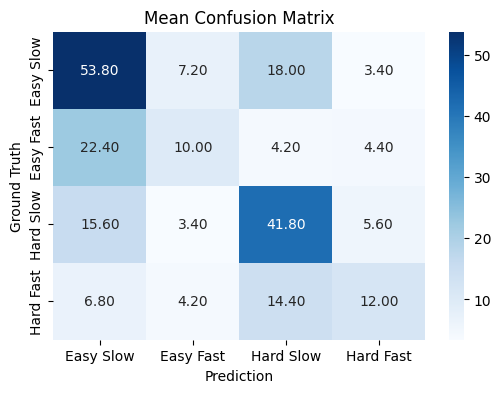

In [8]:
# rbf
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__C': [0.1, 1, 10, 100, 1000],
    'model__gamma': [0.0001, 0.001, 0.01, 0.1]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        # ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        # ('undersample', RandomUnderSampler(sampling_strategy='auto', random_state=random_state)),
        ('model', SVC(kernel='rbf', random_state=random_state))
    ])
    participants_ids = X_scaled_p['participant_id']
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_scaled, y, participants_ids, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='recall_macro', refit='recall_macro', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred, average='macro', zero_division=0))
        inner_results['recall'].append(recall_score(y_test, y_pred, average='macro'))
        inner_results['f1'].append(f1_score(y_test, y_pred, average='macro'))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred, labels=class_order))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

In [9]:
outer_results['best_params']

[[{'model__C': 10, 'model__gamma': 0.01},
  {'model__C': 1000, 'model__gamma': 0.001},
  {'model__C': 1000, 'model__gamma': 0.0001},
  {'model__C': 10, 'model__gamma': 0.01},
  {'model__C': 10, 'model__gamma': 0.01}],
 [{'model__C': 10, 'model__gamma': 0.01},
  {'model__C': 1000, 'model__gamma': 0.001},
  {'model__C': 1000, 'model__gamma': 0.0001},
  {'model__C': 10, 'model__gamma': 0.01},
  {'model__C': 10, 'model__gamma': 0.01}],
 [{'model__C': 10, 'model__gamma': 0.01},
  {'model__C': 1000, 'model__gamma': 0.001},
  {'model__C': 1000, 'model__gamma': 0.0001},
  {'model__C': 10, 'model__gamma': 0.01},
  {'model__C': 10, 'model__gamma': 0.01}],
 [{'model__C': 10, 'model__gamma': 0.01},
  {'model__C': 1000, 'model__gamma': 0.001},
  {'model__C': 1000, 'model__gamma': 0.0001},
  {'model__C': 10, 'model__gamma': 0.01},
  {'model__C': 10, 'model__gamma': 0.01}],
 [{'model__C': 10, 'model__gamma': 0.01},
  {'model__C': 1000, 'model__gamma': 0.001},
  {'model__C': 1000, 'model__gamma': 0.00

##### Oversampled Participant-folded SVC (MultiClass)

In [26]:
# Prepare Dataset
df_svc8 = df.copy().dropna()
df_svc8_scaled = df_svc8.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)
participants_ids = df_svc8.reset_index(drop=True)['participant_id']

X_scaled = df_svc8_scaled.drop(columns=['condition'])
X_scaled_p = X_scaled.copy()
X_scaled_p['participant_id'] = participants_ids
y = df_svc8_scaled['condition']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_14632\1372906193.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_svc8_scaled = df_svc8.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [27]:
# Classes unbalance (NaN dropped)
print(f"Diff Low:\t{len(df_svc8_scaled.query("condition == 'Easy_Slow' | condition == 'Easy_Fast'"))}")
print(f"Diff High:\t{len(df_svc8_scaled.query("condition == 'Hard_Slow' | condition == 'Hard_Fast'"))}")

print()

print(f"Freq Low:\t{len(df_svc8_scaled.query("condition == 'Easy_Slow' | condition == 'Hard_Slow'"))}")
print(f"Freq High:\t{len(df_svc8_scaled.query("condition == 'Easy_Fast' | condition == 'Hard_Fast'"))}")

print()
print()

print(f"Easy Slow:\t{len(df_svc8_scaled.query("condition == 'Easy_Slow'"))}")
print(f"Easy Fast:\t{len(df_svc8_scaled.query("condition == 'Easy_Fast'"))}")
print(f"Hard Slow:\t{len(df_svc8_scaled.query("condition == 'Hard_Slow'"))}")
print(f"Hard Fast:\t{len(df_svc8_scaled.query("condition == 'Hard_Fast'"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


Easy Slow:	205
Easy Fast:	412
Hard Slow:	187
Hard Fast:	332


Average Performance across multiple runs:
Accuracy: 48.50%, (~0.51)
Precision: 47.48%, (~0.56)
Recall: 48.55%, (~0.61)
F1 Score: 47.43%, (~0.56)


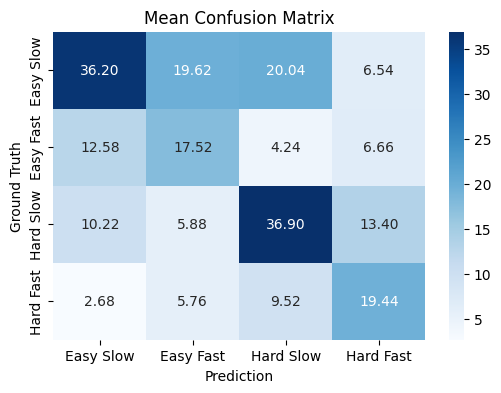

In [12]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__C': [0.1, 1, 10, 100, 1000],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        # ('undersample', RandomUnderSampler(sampling_strategy='auto', random_state=random_state)),
        ('model', SVC(kernel='linear', random_state=random_state))
    ])
    participants_ids = X_scaled_p['participant_id']
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_scaled, y, participants_ids, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='recall_macro', refit='recall_macro', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred, average='macro', zero_division=0))
        inner_results['recall'].append(recall_score(y_test, y_pred, average='macro'))
        inner_results['f1'].append(f1_score(y_test, y_pred, average='macro'))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred, labels=class_order))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

In [13]:
outer_results['best_params']

[[{'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 1},
  {'model__C': 100},
  {'model__C': 0.1}],
 [{'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 1},
  {'model__C': 0.1}],
 [{'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 1}],
 [{'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 100},
  {'model__C': 1000}],
 [{'model__C': 0.1},
  {'model__C': 1},
  {'model__C': 1000},
  {'model__C': 0.1},
  {'model__C': 0.1}],
 [{'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 100},
  {'model__C': 0.1}],
 [{'model__C': 0.1},
  {'model__C': 1},
  {'model__C': 1},
  {'model__C': 0.1},
  {'model__C': 0.1}],
 [{'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 1000},
  {'model__C': 0.1},
  {'model__C': 0.1}],
 [{'model__C': 10},
  {'model__C': 0.1},
  {'model__C': 1},
  {'model__C': 100},
  {'model__C': 0.1}],
 [{'model__C': 1},
  {'model__C': 0.1},
  {'model__C': 1},

Average Performance across multiple runs:
Accuracy: 49.32%, (~0.59)
Precision: 48.33%, (~0.62)
Recall: 49.46%, (~0.69)
F1 Score: 48.25%, (~0.62)


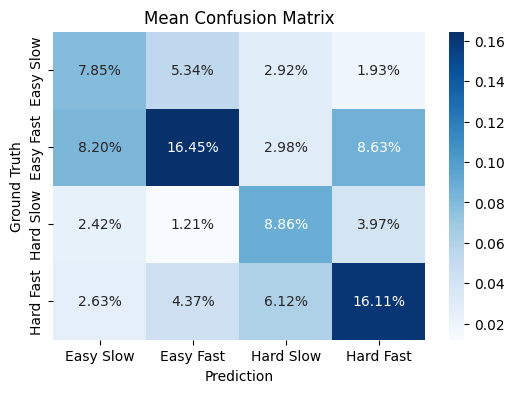

In [28]:
# rbf
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__C': [0.1, 1, 10, 100, 1000],
    'model__gamma': [0.0001, 0.001, 0.01, 0.1]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        # ('undersample', RandomUnderSampler(sampling_strategy='auto', random_state=random_state)),
        ('model', SVC(kernel='rbf', random_state=random_state))
    ])
    participants_ids = X_scaled_p['participant_id']
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_scaled, y, participants_ids, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='recall_macro', refit='recall_macro', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred, average='macro', zero_division=0))
        inner_results['recall'].append(recall_score(y_test, y_pred, average='macro'))
        inner_results['f1'].append(f1_score(y_test, y_pred, average='macro'))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred, labels=class_order))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

In [29]:
outer_results['best_params']

[[{'model__C': 100, 'model__gamma': 0.001},
  {'model__C': 1, 'model__gamma': 0.01},
  {'model__C': 10, 'model__gamma': 0.001},
  {'model__C': 1, 'model__gamma': 0.01},
  {'model__C': 1, 'model__gamma': 0.01}],
 [{'model__C': 1000, 'model__gamma': 0.0001},
  {'model__C': 100, 'model__gamma': 0.001},
  {'model__C': 100, 'model__gamma': 0.001},
  {'model__C': 100, 'model__gamma': 0.001},
  {'model__C': 10, 'model__gamma': 0.01}],
 [{'model__C': 100, 'model__gamma': 0.0001},
  {'model__C': 1, 'model__gamma': 0.01},
  {'model__C': 1000, 'model__gamma': 0.0001},
  {'model__C': 1, 'model__gamma': 0.01},
  {'model__C': 10, 'model__gamma': 0.001}],
 [{'model__C': 1, 'model__gamma': 0.01},
  {'model__C': 1, 'model__gamma': 0.01},
  {'model__C': 1, 'model__gamma': 0.01},
  {'model__C': 1, 'model__gamma': 0.01},
  {'model__C': 1000, 'model__gamma': 0.0001}],
 [{'model__C': 100, 'model__gamma': 0.001},
  {'model__C': 1, 'model__gamma': 0.01},
  {'model__C': 1000, 'model__gamma': 0.001},
  {'model_

##### Undersampled Participant-folded SVC (MultiClass)

In [16]:
# Prepare Dataset
df_svc8 = df.copy().dropna()
df_svc8_scaled = df_svc8.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)
participants_ids = df_svc8.reset_index(drop=True)['participant_id']

X_scaled = df_svc8_scaled.drop(columns=['condition'])
X_scaled_p = X_scaled.copy()
X_scaled_p['participant_id'] = participants_ids
y = df_svc8_scaled['condition']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_17796\1372906193.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_svc8_scaled = df_svc8.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [17]:
# Classes unbalance (NaN dropped)
print(f"Diff Low:\t{len(df_svc8_scaled.query("condition == 'Easy_Slow' | condition == 'Easy_Fast'"))}")
print(f"Diff High:\t{len(df_svc8_scaled.query("condition == 'Hard_Slow' | condition == 'Hard_Fast'"))}")

print()

print(f"Freq Low:\t{len(df_svc8_scaled.query("condition == 'Easy_Slow' | condition == 'Hard_Slow'"))}")
print(f"Freq High:\t{len(df_svc8_scaled.query("condition == 'Easy_Fast' | condition == 'Hard_Fast'"))}")

print()
print()

print(f"Easy Slow:\t{len(df_svc8_scaled.query("condition == 'Easy_Slow'"))}")
print(f"Easy Fast:\t{len(df_svc8_scaled.query("condition == 'Easy_Fast'"))}")
print(f"Hard Slow:\t{len(df_svc8_scaled.query("condition == 'Hard_Slow'"))}")
print(f"Hard Fast:\t{len(df_svc8_scaled.query("condition == 'Hard_Fast'"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


Easy Slow:	205
Easy Fast:	412
Hard Slow:	187
Hard Fast:	332


Average Performance across multiple runs:
Accuracy: 48.01%, (~0.76)
Precision: 46.87%, (~0.72)
Recall: 47.92%, (~0.72)
F1 Score: 46.87%, (~0.70)


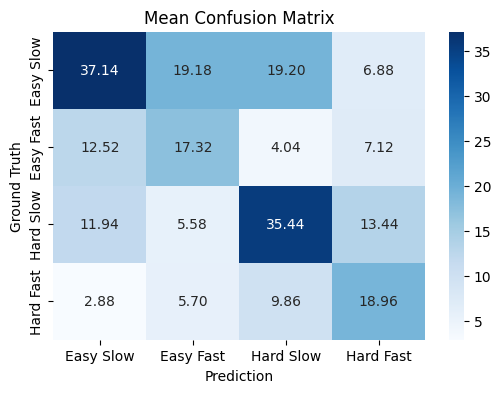

In [18]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__C': [0.1, 1, 10, 100, 1000],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        # ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        ('undersample', RandomUnderSampler(sampling_strategy='auto', random_state=random_state)),
        ('model', SVC(kernel='linear', random_state=random_state))
    ])
    participants_ids = X_scaled_p['participant_id']
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_scaled, y, participants_ids, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='recall_macro', refit='recall_macro', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred, average='macro', zero_division=0))
        inner_results['recall'].append(recall_score(y_test, y_pred, average='macro'))
        inner_results['f1'].append(f1_score(y_test, y_pred, average='macro'))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred, labels=class_order))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

In [19]:
outer_results['best_params']

[[{'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 1000},
  {'model__C': 0.1},
  {'model__C': 1}],
 [{'model__C': 0.1},
  {'model__C': 1},
  {'model__C': 1},
  {'model__C': 10},
  {'model__C': 100}],
 [{'model__C': 10},
  {'model__C': 0.1},
  {'model__C': 1},
  {'model__C': 1},
  {'model__C': 0.1}],
 [{'model__C': 10},
  {'model__C': 0.1},
  {'model__C': 10},
  {'model__C': 0.1},
  {'model__C': 1}],
 [{'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 1000},
  {'model__C': 10}],
 [{'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 1},
  {'model__C': 1}],
 [{'model__C': 1},
  {'model__C': 1},
  {'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 0.1}],
 [{'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 1}],
 [{'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 10},
  {'model__C': 1000}],
 [{'model__C': 1},
  {'model__C': 0.1},
  {'model__C': 1000},
  {'model

Average Performance across multiple runs:
Accuracy: 47.90%, (~0.82)
Precision: 46.83%, (~0.78)
Recall: 47.85%, (~0.76)
F1 Score: 46.72%, (~0.80)


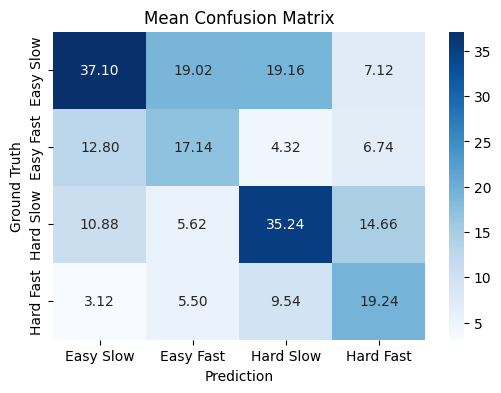

In [20]:
# rbf
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__C': [0.1, 1, 10, 100, 1000],
    'model__gamma': [0.0001, 0.001, 0.01, 0.1]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        # ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        ('undersample', RandomUnderSampler(sampling_strategy='auto', random_state=random_state)),
        ('model', SVC(kernel='rbf', random_state=random_state))
    ])
    participants_ids = X_scaled_p['participant_id']
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_scaled, y, participants_ids, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='recall_macro', refit='recall_macro', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred, average='macro', zero_division=0))
        inner_results['recall'].append(recall_score(y_test, y_pred, average='macro'))
        inner_results['f1'].append(f1_score(y_test, y_pred, average='macro'))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred, labels=class_order))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

In [21]:
outer_results['best_params']

[[{'model__C': 10, 'model__gamma': 0.01},
  {'model__C': 100, 'model__gamma': 0.001},
  {'model__C': 10, 'model__gamma': 0.01},
  {'model__C': 1, 'model__gamma': 0.1},
  {'model__C': 100, 'model__gamma': 0.001}],
 [{'model__C': 100, 'model__gamma': 0.001},
  {'model__C': 10, 'model__gamma': 0.01},
  {'model__C': 10, 'model__gamma': 0.01},
  {'model__C': 10, 'model__gamma': 0.01},
  {'model__C': 100, 'model__gamma': 0.001}],
 [{'model__C': 10, 'model__gamma': 0.01},
  {'model__C': 100, 'model__gamma': 0.001},
  {'model__C': 10, 'model__gamma': 0.01},
  {'model__C': 1, 'model__gamma': 0.1},
  {'model__C': 10, 'model__gamma': 0.01}],
 [{'model__C': 1000, 'model__gamma': 0.0001},
  {'model__C': 10, 'model__gamma': 0.01},
  {'model__C': 10, 'model__gamma': 0.01},
  {'model__C': 1, 'model__gamma': 0.01},
  {'model__C': 10, 'model__gamma': 0.01}],
 [{'model__C': 1, 'model__gamma': 0.01},
  {'model__C': 1, 'model__gamma': 0.1},
  {'model__C': 10, 'model__gamma': 0.01},
  {'model__C': 10, 'mode

### 2. Decision Tree Classifier

##### Basic DT Classifier (MultiClass)

In [61]:
# Prepare Dataset
df_dt1 = df.copy()
df_dt1 = df_dt1.drop(columns=['participant_id'])

X = df_dt1.drop(columns=['condition', 'difficulty', 'frequency'])
y = df_dt1['condition']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

df_dt1_scaled = pd.concat([X_scaled, y.reset_index(drop=True)], axis=1)

In [62]:
# Classes unbalance
print(f"Diff Low:\t{len(df_dt1_scaled.query("condition == 'Easy_Slow' | condition == 'Easy_Fast'"))}")
print(f"Diff High:\t{len(df_dt1_scaled.query("condition == 'Hard_Slow' | condition == 'Hard_Fast'"))}")

print()

print(f"Freq Low:\t{len(df_dt1_scaled.query("condition == 'Easy_Slow' | condition == 'Hard_Slow'"))}")
print(f"Freq High:\t{len(df_dt1_scaled.query("condition == 'Easy_Fast' | condition == 'Hard_Fast'"))}")

print()
print()

print(f"Easy Slow:\t{len(df_dt1_scaled.query("condition == 'Easy_Slow'"))}")
print(f"Easy Fast:\t{len(df_dt1_scaled.query("condition == 'Easy_Fast'"))}")
print(f"Hard Slow:\t{len(df_dt1_scaled.query("condition == 'Hard_Slow'"))}")
print(f"Hard Fast:\t{len(df_dt1_scaled.query("condition == 'Hard_Fast'"))}")

Diff Low:	709
Diff High:	540

Freq Low:	432
Freq High:	817


Easy Slow:	236
Easy Fast:	473
Hard Slow:	196
Hard Fast:	344


Average Performance across multiple runs:
Accuracy: 37.44%, (~1.39)
Precision: 36.12%, (~1.59)
Recall: 36.64%, (~1.62)
F1 Score: 35.93%, (~1.52)


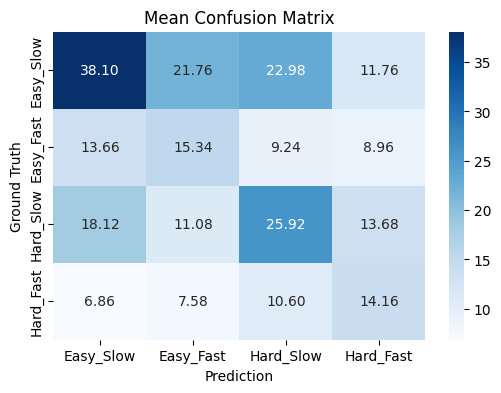

In [63]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = DecisionTreeClassifier(criterion='entropy', class_weight='balanced', random_state=random_state)

    inner_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}
    for train_idx, test_idx in outer_cv.split(X_scaled, y):
        X_train, X_test = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1_macro', refit='f1_macro', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred, average='macro'))
        inner_results['recall'].append(recall_score(y_test, y_pred, average='macro'))
        inner_results['f1'].append(f1_score(y_test, y_pred, average='macro'))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues',
            xticklabels=['Easy_Slow', 'Easy_Fast', 'Hard_Slow', 'Hard_Fast'], 
            yticklabels=['Easy_Slow', 'Easy_Fast', 'Hard_Slow', 'Hard_Fast'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

##### Participant-scaled DT Classifier (MultiClass)

In [64]:
# Prepare Dataset
df_dt2 = df.copy() #.dropna()

df_dt2_scaled = df_dt2.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)

X_scaled = df_dt2_scaled.drop(columns=['condition'])
y = df_dt2_scaled['condition']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\2637670949.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_dt2_scaled = df_dt2.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [65]:
# Classes unbalance
print(f"Diff Low:\t{len(df_dt2_scaled.query("condition == 'Easy_Slow' | condition == 'Easy_Fast'"))}")
print(f"Diff High:\t{len(df_dt2_scaled.query("condition == 'Hard_Slow' | condition == 'Hard_Fast'"))}")

print()

print(f"Freq Low:\t{len(df_dt2_scaled.query("condition == 'Easy_Slow' | condition == 'Hard_Slow'"))}")
print(f"Freq High:\t{len(df_dt2_scaled.query("condition == 'Easy_Fast' | condition == 'Hard_Fast'"))}")

print()
print()

print(f"Easy Slow:\t{len(df_dt2_scaled.query("condition == 'Easy_Slow'"))}")
print(f"Easy Fast:\t{len(df_dt2_scaled.query("condition == 'Easy_Fast'"))}")
print(f"Hard Slow:\t{len(df_dt2_scaled.query("condition == 'Hard_Slow'"))}")
print(f"Hard Fast:\t{len(df_dt2_scaled.query("condition == 'Hard_Fast'"))}")

Diff Low:	709
Diff High:	540

Freq Low:	432
Freq High:	817


Easy Slow:	236
Easy Fast:	473
Hard Slow:	196
Hard Fast:	344


Average Performance across multiple runs:
Accuracy: 37.43%, (~1.36)
Precision: 35.92%, (~1.23)
Recall: 36.49%, (~1.23)
F1 Score: 35.75%, (~1.28)


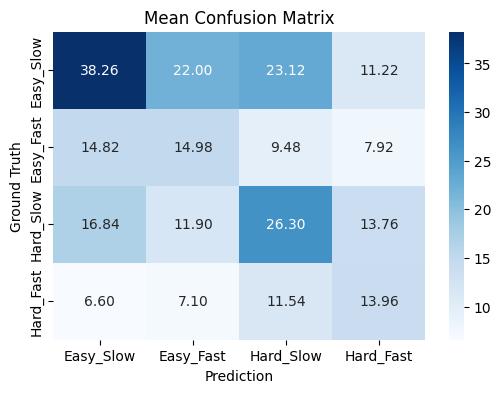

In [66]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'max_depth': [None, 10, 20, 30], #1, 2, 3, 5 also
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = DecisionTreeClassifier(criterion='entropy', class_weight='balanced', random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_scaled, y):
        X_train, X_test = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1_macro', refit='f1_macro', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred, average='macro'))
        inner_results['recall'].append(recall_score(y_test, y_pred, average='macro'))
        inner_results['f1'].append(f1_score(y_test, y_pred, average='macro'))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues',
            xticklabels=['Easy_Slow', 'Easy_Fast', 'Hard_Slow', 'Hard_Fast'], 
            yticklabels=['Easy_Slow', 'Easy_Fast', 'Hard_Slow', 'Hard_Fast'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

##### Basic DT Classifier (Separated)

In [67]:
# Prepare Datasets
df_dt1_diff = df_diff.copy()
df_dt1_diff = df_dt1_diff.drop(columns=['participant_id'])
df_dt1_diff['difficulty'] = df_dt1_diff['difficulty'].apply(lambda x: 0 if x == 'Easy' else 1)

X_diff = df_dt1_diff.drop(columns=['difficulty'])
y_diff = df_dt1_diff['difficulty']

scaler = StandardScaler()
X_diff_scaled = scaler.fit_transform(X_diff)
X_diff_scaled = pd.DataFrame(X_diff_scaled, columns=X_diff.columns)

df_dt1_diff_scaled = pd.concat([X_diff_scaled, y_diff.reset_index(drop=True)], axis=1)


df_dt1_freq = df_freq.copy()
df_dt1_freq = df_dt1_freq.drop(columns=['participant_id'])
df_dt1_freq['frequency'] = df_dt1_freq['frequency'].apply(lambda x: 0 if x == 'Slow' else 1)

X_freq = df_dt1_freq.drop(columns=['frequency'])
y_freq = df_dt1_freq['frequency']

scaler = StandardScaler()
X_freq_scaled = scaler.fit_transform(X_freq)
X_freq_scaled = pd.DataFrame(X_freq_scaled, columns=X_freq.columns)

df_dt1_freq_scaled = pd.concat([X_freq_scaled, y_freq.reset_index(drop=True)], axis=1)

In [68]:
# Classes unbalance
print(f"Diff Low:\t{len(df_dt1_diff_scaled.query("difficulty == 0"))}")
print(f"Diff High:\t{len(df_dt1_diff_scaled.query("difficulty == 1"))}")

print()

print(f"Freq Low:\t{len(df_dt1_freq_scaled.query("frequency == 0"))}")
print(f"Freq High:\t{len(df_dt1_freq_scaled.query("frequency == 1"))}")

Diff Low:	709
Diff High:	540

Freq Low:	432
Freq High:	817


Average Performance across multiple runs:
Accuracy: 62.91%, (~1.28)
Precision: 56.38%, (~1.37)
Recall: 64.65%, (~2.31)
F1 Score: 60.02%, (~1.50)


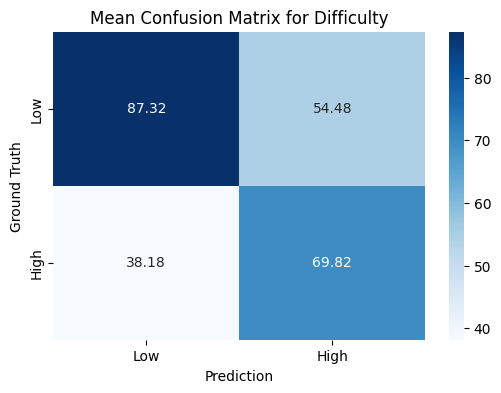

In [69]:
# (Diff) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = DecisionTreeClassifier(criterion='entropy', class_weight='balanced', random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_diff_scaled, y_diff):
        X_train, X_test = X_diff_scaled.iloc[train_idx], X_diff_scaled.iloc[test_idx]
        y_train, y_test = y_diff.iloc[train_idx], y_diff.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Difficulty')
plt.show()

Average Performance across multiple runs:
Accuracy: 63.58%, (~1.30)
Precision: 72.61%, (~0.93)
Recall: 71.24%, (~1.93)
F1 Score: 71.86%, (~1.21)


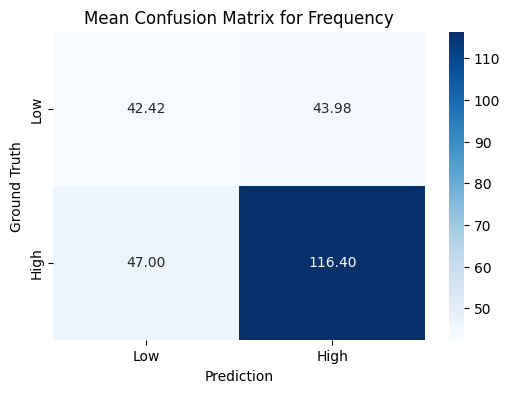

In [70]:
# (Freq) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = DecisionTreeClassifier(criterion='entropy', class_weight='balanced', random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_freq_scaled, y_freq):
        X_train, X_test = X_freq_scaled.iloc[train_idx], X_freq_scaled.iloc[test_idx]
        y_train, y_test = y_freq.iloc[train_idx], y_freq.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Frequency')
plt.show()

##### Participant-scaled DT Classifier (Separated)

In [71]:
# Prepare Datasets
df_dt2_diff = df_diff.copy().dropna()
df_dt2_diff['difficulty'] = df_dt2_diff['difficulty'].apply(lambda x: 0 if x == 'Easy' else 1)

df_dt2_diff_scaled = df_dt2_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)

X_diff_scaled = df_dt2_diff_scaled.drop(columns=['difficulty'])
y_diff = df_dt2_diff_scaled['difficulty']


df_dt2_freq = df_freq.copy().dropna()
df_dt2_freq['frequency'] = df_dt2_freq['frequency'].apply(lambda x: 0 if x == 'Slow' else 1)

df_dt2_freq_scaled = df_dt2_freq.groupby('participant_id').apply(scale_by_participant_freq).reset_index(drop=True)

X_freq_scaled = df_dt2_freq_scaled.drop(columns=['frequency'])
y_freq = df_dt2_freq_scaled['frequency']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\4119570273.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_dt2_diff_scaled = df_dt2_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)
C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\4119570273.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_dt2_freq_scaled = df_dt2_freq.groupby('participant_id').apply

In [72]:
# Classes unbalance
print(f"Diff Low:\t{len(df_dt2_diff_scaled.query("difficulty == 0"))}")
print(f"Diff High:\t{len(df_dt2_diff_scaled.query("difficulty == 1"))}")

print()

print(f"Freq Low:\t{len(df_dt2_freq_scaled.query("frequency == 0"))}")
print(f"Freq High:\t{len(df_dt2_freq_scaled.query("frequency == 1"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


Average Performance across multiple runs:
Accuracy: 63.50%, (~1.16)
Precision: 59.16%, (~1.36)
Recall: 66.66%, (~3.26)
F1 Score: 62.25%, (~1.57)


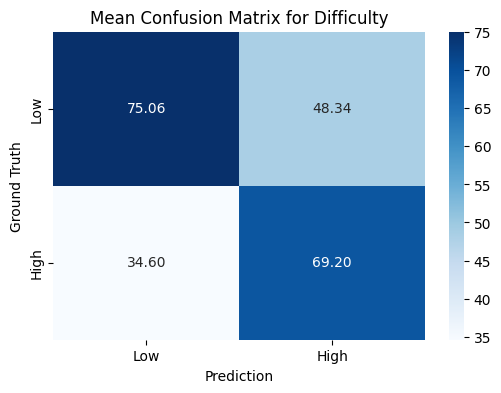

In [73]:
# (Diff) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'max_depth': [None, 1, 2, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = DecisionTreeClassifier(criterion='entropy', class_weight='balanced', random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }    
    for train_idx, test_idx in outer_cv.split(X_diff_scaled, y_diff):
        X_train, X_test = X_diff_scaled.iloc[train_idx], X_diff_scaled.iloc[test_idx]
        y_train, y_test = y_diff.iloc[train_idx], y_diff.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Difficulty')
plt.show()

Average Performance across multiple runs:
Accuracy: 62.37%, (~2.07)
Precision: 72.41%, (~1.31)
Recall: 69.10%, (~3.06)
F1 Score: 70.43%, (~1.97)


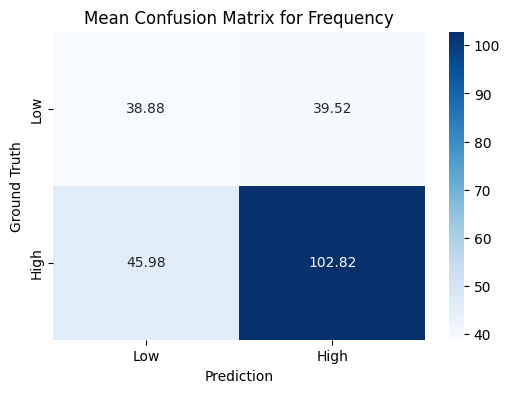

In [74]:
# (Freq) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'max_depth': [None, 1, 2, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = DecisionTreeClassifier(criterion='entropy', class_weight='balanced', random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_freq_scaled, y_freq):
        X_train, X_test = X_freq_scaled.iloc[train_idx], X_freq_scaled.iloc[test_idx]
        y_train, y_test = y_freq.iloc[train_idx], y_freq.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Frequency')
plt.show()

##### Undersampled Participant-scaled DT Classifier (Separated)

In [75]:
# Prepare Datasets
df_dt3_diff = df_diff.copy().dropna()
df_dt3_diff['difficulty'] = df_dt3_diff['difficulty'].apply(lambda x: 0 if x == 'Easy' else 1)

df_dt3_diff_scaled = df_dt3_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)

X_diff_scaled = df_dt3_diff_scaled.drop(columns=['difficulty'])
y_diff = df_dt3_diff_scaled['difficulty']


df_dt3_freq = df_freq.copy().dropna()
df_dt3_freq['frequency'] = df_dt3_freq['frequency'].apply(lambda x: 0 if x == 'Slow' else 1)

df_dt3_freq_scaled = df_dt3_freq.groupby('participant_id').apply(scale_by_participant_freq).reset_index(drop=True)

X_freq_scaled = df_dt3_freq_scaled.drop(columns=['frequency'])
y_freq = df_dt3_freq_scaled['frequency']

undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=random_state)
X_diff_scaled_us, y_diff_us = undersampler.fit_resample(X_diff_scaled, y_diff)
X_freq_scaled_us, y_freq_us = undersampler.fit_resample(X_freq_scaled, y_freq)

df_dt3_diff_scaled_us = X_diff_scaled_us.join(y_diff_us)
df_dt3_freq_scaled_us = X_freq_scaled_us.join(y_freq_us)

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\3991968839.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_dt3_diff_scaled = df_dt3_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)
C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\3991968839.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_dt3_freq_scaled = df_dt3_freq.groupby('participant_id').apply

In [76]:
# Classes (un)balance
print(f"Diff Low:\t{len(df_dt3_diff_scaled_us.query("difficulty == 0"))}")
print(f"Diff High:\t{len(df_dt3_diff_scaled_us.query("difficulty == 1"))}")

print()

print(f"Freq Low:\t{len(df_dt3_freq_scaled_us.query("frequency == 0"))}")
print(f"Freq High:\t{len(df_dt3_freq_scaled_us.query("frequency == 1"))}")

Diff Low:	519
Diff High:	519

Freq Low:	392
Freq High:	392


Average Performance across multiple runs:
Accuracy: 64.70%, (~1.65)
Precision: 64.50%, (~1.58)
Recall: 66.25%, (~3.64)
F1 Score: 65.10%, (~2.18)


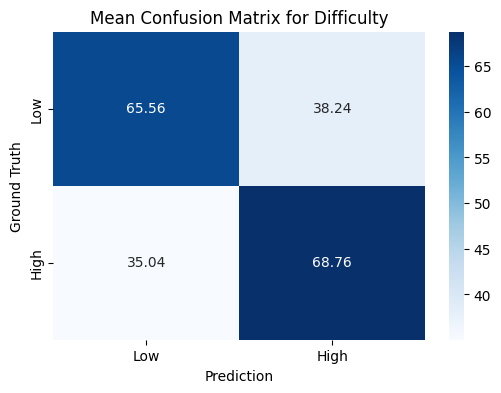

In [77]:
# (Diff) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'max_depth': [None, 1, 2, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=random_state)
    X_diff_scaled_us, y_diff_us = undersampler.fit_resample(X_diff_scaled, y_diff)

    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = DecisionTreeClassifier(criterion='gini', random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }    
    for train_idx, test_idx in outer_cv.split(X_diff_scaled_us, y_diff_us):
        X_train, X_test = X_diff_scaled_us.iloc[train_idx], X_diff_scaled_us.iloc[test_idx]
        y_train, y_test = y_diff_us.iloc[train_idx], y_diff_us.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Difficulty')
plt.show()

Average Performance across multiple runs:
Accuracy: 61.88%, (~1.41)
Precision: 62.14%, (~1.40)
Recall: 61.21%, (~3.90)
F1 Score: 61.35%, (~2.30)


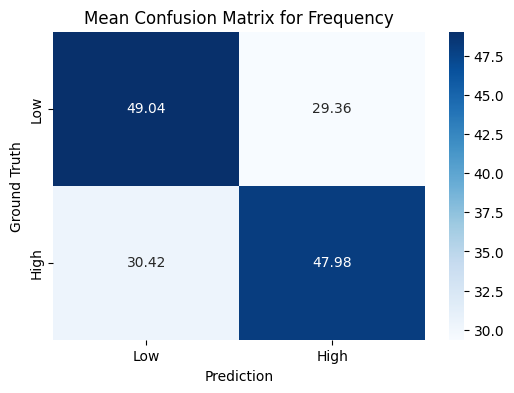

In [78]:
# (Freq) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'max_depth': [None, 1, 2, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=random_state)
    X_freq_scaled_us, y_freq_us = undersampler.fit_resample(X_freq_scaled, y_freq)

    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = DecisionTreeClassifier(criterion='gini', random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_freq_scaled_us, y_freq_us):
        X_train, X_test = X_freq_scaled_us.iloc[train_idx], X_freq_scaled_us.iloc[test_idx]
        y_train, y_test = y_freq_us.iloc[train_idx], y_freq_us.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Frequency')
plt.show()

##### Oversampled Participant-scaled DT Classifier (Separated)

In [79]:
# Prepare Datasets
df_dt4_diff = df_diff.copy().dropna()
df_dt4_diff['difficulty'] = df_dt4_diff['difficulty'].apply(lambda x: 0 if x == 'Easy' else 1)

df_dt4_diff_scaled = df_dt4_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)

X_diff_scaled = df_dt4_diff_scaled.drop(columns=['difficulty'])
y_diff = df_dt4_diff_scaled['difficulty']


df_dt4_freq = df_freq.copy().dropna()
df_dt4_freq['frequency'] = df_dt4_freq['frequency'].apply(lambda x: 0 if x == 'Slow' else 1)

df_dt4_freq_scaled = df_dt4_freq.groupby('participant_id').apply(scale_by_participant_freq).reset_index(drop=True)

X_freq_scaled = df_dt4_freq_scaled.drop(columns=['frequency'])
y_freq = df_dt4_freq_scaled['frequency']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\536520406.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_dt4_diff_scaled = df_dt4_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)
C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\536520406.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_dt4_freq_scaled = df_dt4_freq.groupby('participant_id').apply(s

In [80]:
# Classes (un)balance (NaN dropped)
print(f"Diff Low:\t{len(df_dt4_diff_scaled.query("difficulty == 0"))}")
print(f"Diff High:\t{len(df_dt4_diff_scaled.query("difficulty == 1"))}")

print()

print(f"Freq Low:\t{len(df_dt4_freq_scaled.query("frequency == 0"))}")
print(f"Freq High:\t{len(df_dt4_freq_scaled.query("frequency == 1"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


Average Performance across multiple runs:
Accuracy: 64.43%, (~1.12)
Precision: 60.31%, (~1.17)
Recall: 65.68%, (~2.37)
F1 Score: 62.59%, (~1.44)


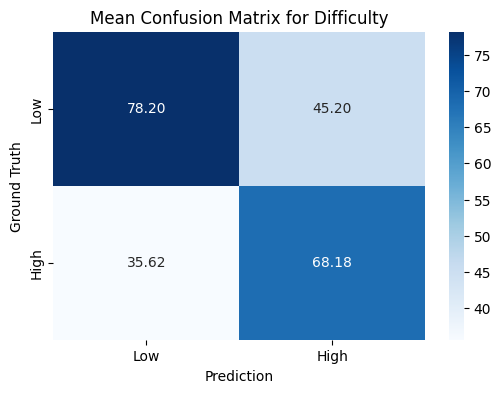

In [81]:
# (Diff) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__max_depth': [None, 1, 2, 3, 5, 10],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        ('model', DecisionTreeClassifier(criterion='gini', random_state=random_state))
    ])
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }    
    for train_idx, test_idx in outer_cv.split(X_diff_scaled, y_diff):
        X_train, X_test = X_diff_scaled.iloc[train_idx], X_diff_scaled.iloc[test_idx]
        y_train, y_test = y_diff.iloc[train_idx], y_diff.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Difficulty')
plt.show()

Average Performance across multiple runs:
Accuracy: 63.00%, (~1.24)
Precision: 74.53%, (~0.94)
Recall: 66.54%, (~3.37)
F1 Score: 69.77%, (~1.91)


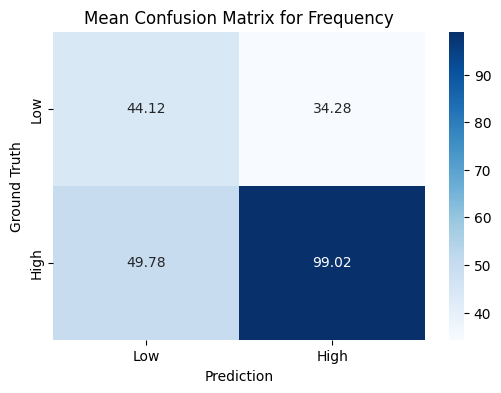

In [82]:
# (Freq) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__max_depth': [None, 1, 2, 3, 5, 10],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        ('model', DecisionTreeClassifier(criterion='gini', random_state=random_state))
    ])
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_freq_scaled, y_freq):
        X_train, X_test = X_freq_scaled.iloc[train_idx], X_freq_scaled.iloc[test_idx]
        y_train, y_test = y_freq.iloc[train_idx], y_freq.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Frequency')
plt.show()

##### Participant-folded DT Classifier (Separated)

In [311]:
# Prepare Datasets
df_dt5_diff = df_diff.copy().dropna()
df_dt5_diff['difficulty'] = df_dt5_diff['difficulty'].apply(lambda x: 0 if x == 'Easy' else 1)
df_dt5_diff_scaled = df_dt5_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)
participants_ids_diff = df_dt5_diff.reset_index(drop=True)['participant_id']

X_diff_scaled = df_dt5_diff_scaled.drop(columns=['difficulty'])
y_diff = df_dt5_diff_scaled['difficulty']


df_dt5_freq = df_freq.copy().dropna()
df_dt5_freq['frequency'] = df_dt5_freq['frequency'].apply(lambda x: 0 if x == 'Slow' else 1)
df_dt5_freq_scaled = df_dt5_freq.groupby('participant_id').apply(scale_by_participant_freq).reset_index(drop=True)
participants_ids_freq = df_dt5_freq.reset_index(drop=True)['participant_id']

X_freq_scaled = df_dt5_freq_scaled.drop(columns=['frequency'])
y_freq = df_dt5_freq_scaled['frequency']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\3824101746.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_dt5_diff_scaled = df_dt5_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)
C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\3824101746.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_dt5_freq_scaled = df_dt5_freq.groupby('participant_id').apply

In [312]:
# Classes unbalance (NaN dropped)
print(f"Diff Low:\t{len(df_dt5_diff_scaled.query("difficulty == 0"))}")
print(f"Diff High:\t{len(df_dt5_diff_scaled.query("difficulty == 1"))}")

print()

print(f"Freq Low:\t{len(df_dt5_freq_scaled.query("frequency == 0"))}")
print(f"Freq High:\t{len(df_dt5_freq_scaled.query("frequency == 1"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


Average Performance across multiple runs:
Accuracy: 60.70%, (~0.44)
Precision: 56.87%, (~0.46)
Recall: 60.55%, (~0.71)
F1 Score: 58.07%, (~0.40)


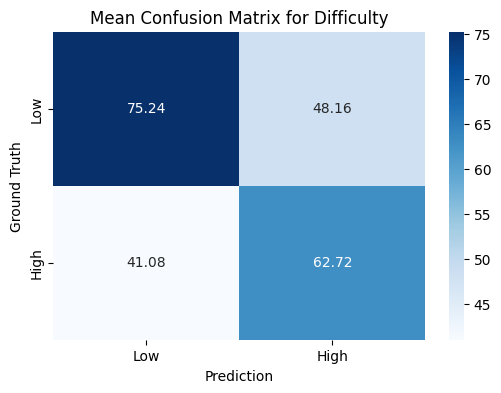

In [313]:
# (Diff) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'max_depth': [None, 1, 2, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_diff_scaled, y_diff, participants_ids_diff, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)
    model = DecisionTreeClassifier(criterion='entropy', class_weight='balanced', random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Difficulty')
plt.show()

In [314]:
outer_results['best_params']

[[{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2},
  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10},
  {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2},
  {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10},
  {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}],
 [{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2},
  {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2},
  {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2},
  {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2},
  {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}],
 [{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2},
  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10},
  {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2},
  {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10},
  {'max_depth': 10, 'min_samples_leaf': 

Average Performance across multiple runs:
Accuracy: 66.33%, (~0.72)
Precision: 77.35%, (~0.41)
Recall: 68.35%, (~0.87)
F1 Score: 72.01%, (~0.65)


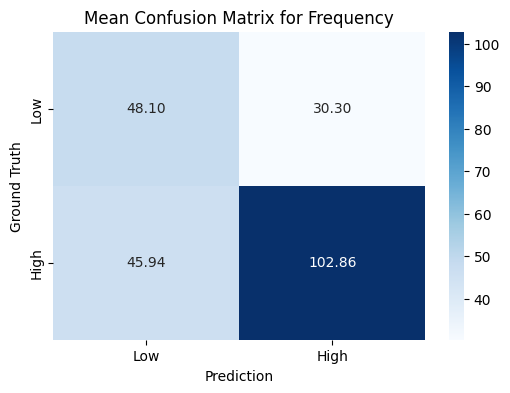

In [315]:
# (Freq) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'max_depth': [None, 1, 2, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_freq_scaled, y_freq, participants_ids_freq, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)
    model = DecisionTreeClassifier(criterion='entropy', class_weight='balanced', random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Frequency')
plt.show()

In [316]:
outer_results['best_params']

[[{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2},
  {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5},
  {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2},
  {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2},
  {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}],
 [{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2},
  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5},
  {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5},
  {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2},
  {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}],
 [{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2},
  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2},
  {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2},
  {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2},
  {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_sp

##### Oversampled Participant-folded DT Classifier (Separate)

In [317]:
# Prepare Datasets
df_dt6_diff = df_diff.copy().dropna()
df_dt6_diff['difficulty'] = df_dt6_diff['difficulty'].apply(lambda x: 0 if x == 'Easy' else 1)
participants_ids_diff = df_dt6_diff.reset_index(drop=True)['participant_id']

df_dt6_diff_scaled = df_dt6_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)

X_diff_scaled = df_dt6_diff_scaled.drop(columns=['difficulty'])
X_diff_scaled_p = X_diff_scaled.copy()
X_diff_scaled_p['participant_id'] = participants_ids_diff
y_diff = df_dt6_diff_scaled['difficulty']



df_dt6_freq = df_freq.copy().dropna()
df_dt6_freq['frequency'] = df_dt6_freq['frequency'].apply(lambda x: 0 if x == 'Slow' else 1)
participants_ids_freq = df_dt6_freq.reset_index(drop=True)['participant_id']

df_dt6_freq_scaled = df_dt6_freq.groupby('participant_id').apply(scale_by_participant_freq).reset_index(drop=True)

X_freq_scaled = df_dt6_freq_scaled.drop(columns=['frequency'])
X_freq_scaled_p = X_freq_scaled.copy()
X_freq_scaled_p['participant_id'] = participants_ids_freq
y_freq = df_dt6_freq_scaled['frequency']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\1886648956.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_dt6_diff_scaled = df_dt6_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)
C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\1886648956.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_dt6_freq_scaled = df_dt6_freq.groupby('participant_id').apply

In [318]:
# Classes (un)balance (NaN dropped)
print(f"Diff Low:\t{len(df_dt5_diff_scaled.query("difficulty == 0"))}")
print(f"Diff High:\t{len(df_dt5_diff_scaled.query("difficulty == 1"))}")

print()

print(f"Freq Low:\t{len(df_dt5_freq_scaled.query("frequency == 0"))}")
print(f"Freq High:\t{len(df_dt5_freq_scaled.query("frequency == 1"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


Average Performance across multiple runs:
Accuracy: 63.77%, (~0.96)
Precision: 60.27%, (~1.71)
Recall: 61.55%, (~2.90)
F1 Score: 60.58%, (~0.72)


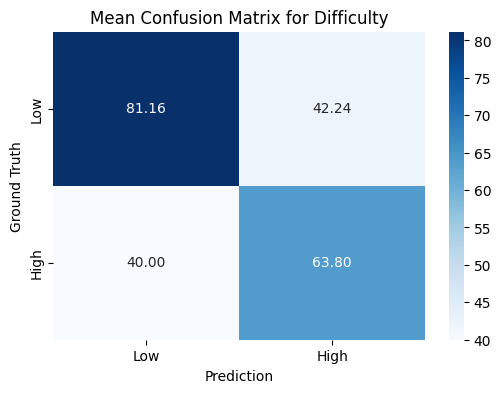

In [319]:
# (Diff) Group-folded nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__max_depth': [None, 1, 2, 3, 5, 10],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        ('model', DecisionTreeClassifier(criterion='gini', random_state=random_state))
    ])
    participants_ids = X_diff_scaled_p['participant_id']
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_diff_scaled, y_diff, participants_ids_diff, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }    
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Difficulty')
plt.show()

In [320]:
outer_results['best_params']

[[{'model__max_depth': 10,
   'model__min_samples_leaf': 4,
   'model__min_samples_split': 2},
  {'model__max_depth': 5,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 10},
  {'model__max_depth': 5,
   'model__min_samples_leaf': 2,
   'model__min_samples_split': 10},
  {'model__max_depth': 10,
   'model__min_samples_leaf': 2,
   'model__min_samples_split': 5},
  {'model__max_depth': 10,
   'model__min_samples_leaf': 2,
   'model__min_samples_split': 10}],
 [{'model__max_depth': 5,
   'model__min_samples_leaf': 2,
   'model__min_samples_split': 2},
  {'model__max_depth': 5,
   'model__min_samples_leaf': 4,
   'model__min_samples_split': 2},
  {'model__max_depth': 5,
   'model__min_samples_leaf': 2,
   'model__min_samples_split': 2},
  {'model__max_depth': 10,
   'model__min_samples_leaf': 2,
   'model__min_samples_split': 10},
  {'model__max_depth': 10,
   'model__min_samples_leaf': 2,
   'model__min_samples_split': 10}],
 [{'model__max_depth': 10,
   'model__min_sample

Average Performance across multiple runs:
Accuracy: 60.07%, (~1.28)
Precision: 73.55%, (~1.14)
Recall: 60.77%, (~2.77)
F1 Score: 66.11%, (~1.52)


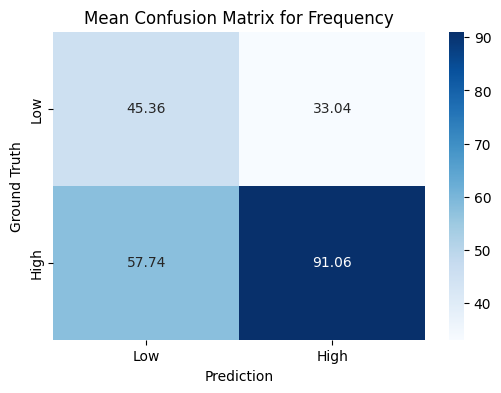

In [321]:
# (Freq) Group-folded nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__max_depth': [None, 1, 2, 3, 5, 10],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        ('model', DecisionTreeClassifier(criterion='gini', random_state=random_state))
    ])
    participants_ids = X_freq_scaled_p['participant_id']
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_freq_scaled, y_freq, participants_ids_freq, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)
    
    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }    
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Frequency')
plt.show()

In [322]:
outer_results['best_params']

[[{'model__max_depth': 5,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 2},
  {'model__max_depth': 5,
   'model__min_samples_leaf': 2,
   'model__min_samples_split': 2},
  {'model__max_depth': 5,
   'model__min_samples_leaf': 4,
   'model__min_samples_split': 2},
  {'model__max_depth': 5,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 2},
  {'model__max_depth': 5,
   'model__min_samples_leaf': 4,
   'model__min_samples_split': 10}],
 [{'model__max_depth': 5,
   'model__min_samples_leaf': 4,
   'model__min_samples_split': 2},
  {'model__max_depth': 5,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 2},
  {'model__max_depth': 5,
   'model__min_samples_leaf': 2,
   'model__min_samples_split': 10},
  {'model__max_depth': 5,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 10},
  {'model__max_depth': 5,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 10}],
 [{'model__max_depth': None,
   'model__min_samples_le

##### Undersampled Participant-folded DT Classifier (Separate)

In [323]:
# Prepare Datasets
df_dt7_diff = df_diff.copy().dropna()
df_dt7_diff['difficulty'] = df_dt7_diff['difficulty'].apply(lambda x: 0 if x == 'Easy' else 1)
participants_ids_diff = df_dt7_diff.reset_index(drop=True)['participant_id']

df_dt7_diff_scaled = df_dt7_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)

X_diff_scaled = df_dt7_diff_scaled.drop(columns=['difficulty'])
X_diff_scaled_p = X_diff_scaled.copy()
X_diff_scaled_p['participant_id'] = participants_ids_diff
y_diff = df_dt7_diff_scaled['difficulty']



df_dt7_freq = df_freq.copy().dropna()
df_dt7_freq['frequency'] = df_dt7_freq['frequency'].apply(lambda x: 0 if x == 'Slow' else 1)
participants_ids_freq = df_dt7_freq.reset_index(drop=True)['participant_id']

df_dt7_freq_scaled = df_dt7_freq.groupby('participant_id').apply(scale_by_participant_freq).reset_index(drop=True)

X_freq_scaled = df_dt7_freq_scaled.drop(columns=['frequency'])
X_freq_scaled_p = X_freq_scaled.copy()
X_freq_scaled_p['participant_id'] = participants_ids_freq
y_freq = df_dt7_freq_scaled['frequency']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\3108576270.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_dt7_diff_scaled = df_dt7_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)
C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\3108576270.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_dt7_freq_scaled = df_dt7_freq.groupby('participant_id').apply

In [324]:
# Classes (un)balance (NaN dropped)
print(f"Diff Low:\t{len(df_dt7_diff_scaled.query("difficulty == 0"))}")
print(f"Diff High:\t{len(df_dt7_diff_scaled.query("difficulty == 1"))}")

print()

print(f"Freq Low:\t{len(df_dt7_freq_scaled.query("frequency == 0"))}")
print(f"Freq High:\t{len(df_dt7_freq_scaled.query("frequency == 1"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


Average Performance across multiple runs:
Accuracy: 63.95%, (~1.33)
Precision: 60.27%, (~1.56)
Recall: 62.95%, (~2.80)
F1 Score: 61.25%, (~1.69)


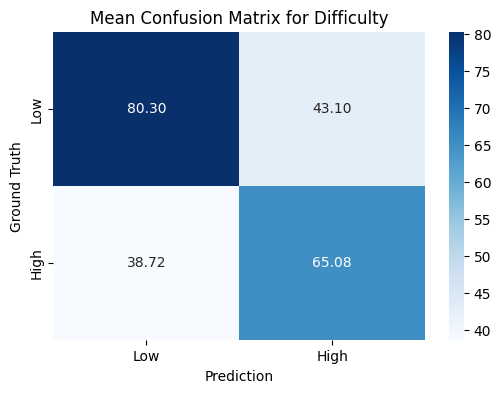

In [325]:
# (Diff) Group-folded nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__max_depth': [None, 1, 2, 3, 5, 10],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('undersample', RandomUnderSampler(sampling_strategy='auto', random_state=random_state)),
        ('model', DecisionTreeClassifier(criterion='gini', random_state=random_state))
    ])
    participants_ids = X_diff_scaled_p['participant_id']
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_diff_scaled, y_diff, participants_ids_diff, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }    
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Difficulty')
plt.show()

In [326]:
outer_results['best_params']

[[{'model__max_depth': 5,
   'model__min_samples_leaf': 2,
   'model__min_samples_split': 10},
  {'model__max_depth': 5,
   'model__min_samples_leaf': 2,
   'model__min_samples_split': 2},
  {'model__max_depth': 5,
   'model__min_samples_leaf': 2,
   'model__min_samples_split': 2},
  {'model__max_depth': None,
   'model__min_samples_leaf': 4,
   'model__min_samples_split': 2},
  {'model__max_depth': 5,
   'model__min_samples_leaf': 4,
   'model__min_samples_split': 10}],
 [{'model__max_depth': None,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 2},
  {'model__max_depth': 5,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 5},
  {'model__max_depth': None,
   'model__min_samples_leaf': 2,
   'model__min_samples_split': 2},
  {'model__max_depth': 10,
   'model__min_samples_leaf': 4,
   'model__min_samples_split': 10},
  {'model__max_depth': 5,
   'model__min_samples_leaf': 4,
   'model__min_samples_split': 10}],
 [{'model__max_depth': 5,
   'model__min_sam

Average Performance across multiple runs:
Accuracy: 62.05%, (~2.10)
Precision: 74.77%, (~0.92)
Recall: 63.65%, (~6.21)
F1 Score: 67.86%, (~3.66)


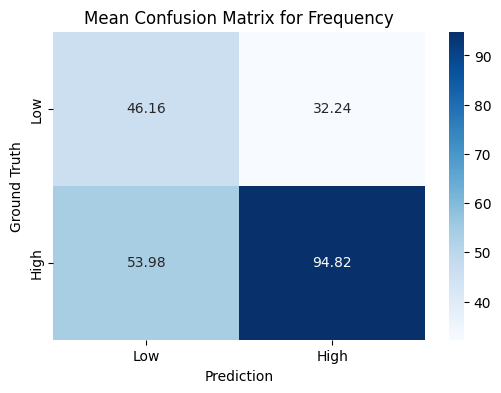

In [327]:
# (Freq) Group-folded nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__max_depth': [None, 1, 2, 3, 5, 10],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('undersample', RandomUnderSampler(sampling_strategy='auto', random_state=random_state)),
        ('model', DecisionTreeClassifier(criterion='gini', random_state=random_state))
    ])
    participants_ids = X_freq_scaled_p['participant_id']
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_freq_scaled, y_freq, participants_ids_freq, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)
    
    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }    
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Frequency')
plt.show()

In [328]:
outer_results['best_params']

[[{'model__max_depth': 3,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 2},
  {'model__max_depth': 5,
   'model__min_samples_leaf': 4,
   'model__min_samples_split': 2},
  {'model__max_depth': 1,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 2},
  {'model__max_depth': 3,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 2},
  {'model__max_depth': 1,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 2}],
 [{'model__max_depth': 3,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 2},
  {'model__max_depth': 5,
   'model__min_samples_leaf': 4,
   'model__min_samples_split': 2},
  {'model__max_depth': 5,
   'model__min_samples_leaf': 4,
   'model__min_samples_split': 10},
  {'model__max_depth': 3,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 2},
  {'model__max_depth': 5,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 5}],
 [{'model__max_depth': 5,
   'model__min_samples_leaf': 1

##### Participant-folded DT (MultiClass)

In [22]:
# Prepare Dataset
df_dt8 = df.copy().dropna()
df_dt8_scaled = df_dt8.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)
participants_ids = df_dt8.reset_index(drop=True)['participant_id']

X_scaled = df_dt8_scaled.drop(columns=['condition'])
X_scaled_p = X_scaled.copy()
X_scaled_p['participant_id'] = participants_ids
y = df_dt8_scaled['condition']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_17796\3384771440.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_dt8_scaled = df_dt8.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [23]:
# Classes unbalance (NaN dropped)
print(f"Diff Low:\t{len(df_dt8_scaled.query("condition == 'Easy_Slow' | condition == 'Easy_Fast'"))}")
print(f"Diff High:\t{len(df_dt8_scaled.query("condition == 'Hard_Slow' | condition == 'Hard_Fast'"))}")

print()

print(f"Freq Low:\t{len(df_dt8_scaled.query("condition == 'Easy_Slow' | condition == 'Hard_Slow'"))}")
print(f"Freq High:\t{len(df_dt8_scaled.query("condition == 'Easy_Fast' | condition == 'Hard_Fast'"))}")

print()
print()

print(f"Easy Slow:\t{len(df_dt8_scaled.query("condition == 'Easy_Slow'"))}")
print(f"Easy Fast:\t{len(df_dt8_scaled.query("condition == 'Easy_Fast'"))}")
print(f"Hard Slow:\t{len(df_dt8_scaled.query("condition == 'Hard_Slow'"))}")
print(f"Hard Fast:\t{len(df_dt8_scaled.query("condition == 'Hard_Fast'"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


Easy Slow:	205
Easy Fast:	412
Hard Slow:	187
Hard Fast:	332


Average Performance across multiple runs:
Accuracy: 36.60%, (~0.20)
Precision: 37.55%, (~0.23)
Recall: 37.03%, (~0.15)
F1 Score: 34.57%, (~0.19)


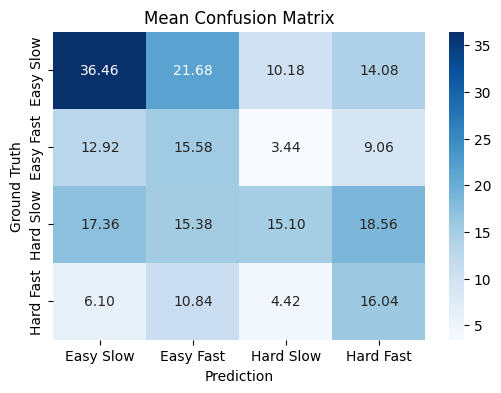

In [24]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__max_depth': [None, 1, 2, 3, 5, 10],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        # ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        # ('undersample', RandomUnderSampler(sampling_strategy='auto', random_state=random_state)),
        ('model', DecisionTreeClassifier(criterion='entropy', class_weight='balanced', random_state=random_state))
    ])
    participants_ids = X_scaled_p['participant_id']
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_scaled, y, participants_ids, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='recall_macro', refit='recall_macro', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred, average='macro', zero_division=0))
        inner_results['recall'].append(recall_score(y_test, y_pred, average='macro'))
        inner_results['f1'].append(f1_score(y_test, y_pred, average='macro'))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred, labels=class_order))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

In [25]:
outer_results['best_params']

[[{'model__max_depth': 5,
   'model__min_samples_leaf': 2,
   'model__min_samples_split': 10},
  {'model__max_depth': 3,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 2},
  {'model__max_depth': 3,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 2},
  {'model__max_depth': 5,
   'model__min_samples_leaf': 4,
   'model__min_samples_split': 2},
  {'model__max_depth': None,
   'model__min_samples_leaf': 2,
   'model__min_samples_split': 10}],
 [{'model__max_depth': 5,
   'model__min_samples_leaf': 2,
   'model__min_samples_split': 10},
  {'model__max_depth': 3,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 2},
  {'model__max_depth': 3,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 2},
  {'model__max_depth': 5,
   'model__min_samples_leaf': 4,
   'model__min_samples_split': 2},
  {'model__max_depth': None,
   'model__min_samples_leaf': 2,
   'model__min_samples_split': 2}],
 [{'model__max_depth': 5,
   'model__min_samples_

##### Oversampled Participant-folded DT (MultiClass)

In [26]:
# Prepare Dataset
df_dt8 = df.copy().dropna()
df_dt8_scaled = df_dt8.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)
participants_ids = df_dt8.reset_index(drop=True)['participant_id']

X_scaled = df_dt8_scaled.drop(columns=['condition'])
X_scaled_p = X_scaled.copy()
X_scaled_p['participant_id'] = participants_ids
y = df_dt8_scaled['condition']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_17796\3384771440.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_dt8_scaled = df_dt8.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [27]:
# Classes unbalance (NaN dropped)
print(f"Diff Low:\t{len(df_dt8_scaled.query("condition == 'Easy_Slow' | condition == 'Easy_Fast'"))}")
print(f"Diff High:\t{len(df_dt8_scaled.query("condition == 'Hard_Slow' | condition == 'Hard_Fast'"))}")

print()

print(f"Freq Low:\t{len(df_dt8_scaled.query("condition == 'Easy_Slow' | condition == 'Hard_Slow'"))}")
print(f"Freq High:\t{len(df_dt8_scaled.query("condition == 'Easy_Fast' | condition == 'Hard_Fast'"))}")

print()
print()

print(f"Easy Slow:\t{len(df_dt8_scaled.query("condition == 'Easy_Slow'"))}")
print(f"Easy Fast:\t{len(df_dt8_scaled.query("condition == 'Easy_Fast'"))}")
print(f"Hard Slow:\t{len(df_dt8_scaled.query("condition == 'Hard_Slow'"))}")
print(f"Hard Fast:\t{len(df_dt8_scaled.query("condition == 'Hard_Fast'"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


Easy Slow:	205
Easy Fast:	412
Hard Slow:	187
Hard Fast:	332


Average Performance across multiple runs:
Accuracy: 35.23%, (~1.64)
Precision: 34.90%, (~1.97)
Recall: 36.20%, (~1.20)
F1 Score: 33.76%, (~1.65)


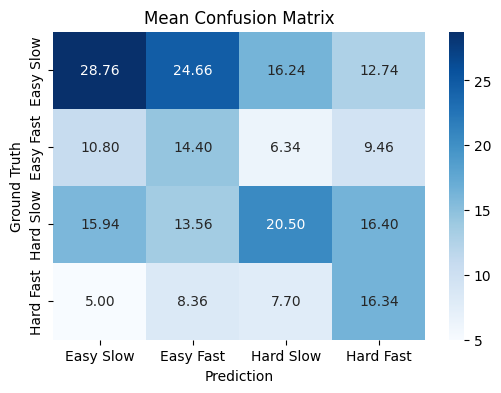

In [28]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__max_depth': [None, 1, 2, 3, 5, 10],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        # ('undersample', RandomUnderSampler(sampling_strategy='auto', random_state=random_state)),
        ('model', DecisionTreeClassifier(criterion='entropy', class_weight='balanced', random_state=random_state))
    ])
    participants_ids = X_scaled_p['participant_id']
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_scaled, y, participants_ids, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='recall_macro', refit='recall_macro', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred, average='macro', zero_division=0))
        inner_results['recall'].append(recall_score(y_test, y_pred, average='macro'))
        inner_results['f1'].append(f1_score(y_test, y_pred, average='macro'))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred, labels=class_order))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

In [29]:
outer_results['best_params']

[[{'model__max_depth': 5,
   'model__min_samples_leaf': 4,
   'model__min_samples_split': 2},
  {'model__max_depth': 5,
   'model__min_samples_leaf': 4,
   'model__min_samples_split': 10},
  {'model__max_depth': 2,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 2},
  {'model__max_depth': 2,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 2},
  {'model__max_depth': 5,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 2}],
 [{'model__max_depth': 5,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 2},
  {'model__max_depth': 5,
   'model__min_samples_leaf': 4,
   'model__min_samples_split': 10},
  {'model__max_depth': None,
   'model__min_samples_leaf': 2,
   'model__min_samples_split': 5},
  {'model__max_depth': 3,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 2},
  {'model__max_depth': 5,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 2}],
 [{'model__max_depth': 10,
   'model__min_samples_lea

##### Undersampled Participant-folded DT (MultiClass)

In [30]:
# Prepare Dataset
df_dt8 = df.copy().dropna()
df_dt8_scaled = df_dt8.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)
participants_ids = df_dt8.reset_index(drop=True)['participant_id']

X_scaled = df_dt8_scaled.drop(columns=['condition'])
X_scaled_p = X_scaled.copy()
X_scaled_p['participant_id'] = participants_ids
y = df_dt8_scaled['condition']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_17796\3384771440.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_dt8_scaled = df_dt8.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [31]:
# Classes unbalance (NaN dropped)
print(f"Diff Low:\t{len(df_dt8_scaled.query("condition == 'Easy_Slow' | condition == 'Easy_Fast'"))}")
print(f"Diff High:\t{len(df_dt8_scaled.query("condition == 'Hard_Slow' | condition == 'Hard_Fast'"))}")

print()

print(f"Freq Low:\t{len(df_dt8_scaled.query("condition == 'Easy_Slow' | condition == 'Hard_Slow'"))}")
print(f"Freq High:\t{len(df_dt8_scaled.query("condition == 'Easy_Fast' | condition == 'Hard_Fast'"))}")

print()
print()

print(f"Easy Slow:\t{len(df_dt8_scaled.query("condition == 'Easy_Slow'"))}")
print(f"Easy Fast:\t{len(df_dt8_scaled.query("condition == 'Easy_Fast'"))}")
print(f"Hard Slow:\t{len(df_dt8_scaled.query("condition == 'Hard_Slow'"))}")
print(f"Hard Fast:\t{len(df_dt8_scaled.query("condition == 'Hard_Fast'"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


Easy Slow:	205
Easy Fast:	412
Hard Slow:	187
Hard Fast:	332


Average Performance across multiple runs:
Accuracy: 35.43%, (~1.57)
Precision: 34.43%, (~1.95)
Recall: 35.18%, (~1.85)
F1 Score: 33.09%, (~1.83)


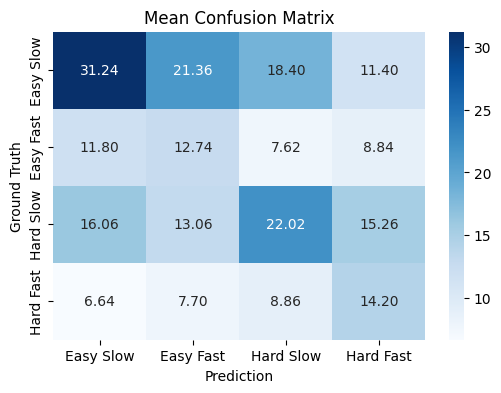

In [32]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__max_depth': [None, 1, 2, 3, 5, 10],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        # ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        ('undersample', RandomUnderSampler(sampling_strategy='auto', random_state=random_state)),
        ('model', DecisionTreeClassifier(criterion='entropy', class_weight='balanced', random_state=random_state))
    ])
    participants_ids = X_scaled_p['participant_id']
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_scaled, y, participants_ids, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='recall_macro', refit='recall_macro', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred, average='macro', zero_division=0))
        inner_results['recall'].append(recall_score(y_test, y_pred, average='macro'))
        inner_results['f1'].append(f1_score(y_test, y_pred, average='macro'))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred, labels=class_order))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

In [33]:
outer_results['best_params']

[[{'model__max_depth': 5,
   'model__min_samples_leaf': 4,
   'model__min_samples_split': 2},
  {'model__max_depth': 5,
   'model__min_samples_leaf': 4,
   'model__min_samples_split': 10},
  {'model__max_depth': 3,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 2},
  {'model__max_depth': 5,
   'model__min_samples_leaf': 4,
   'model__min_samples_split': 2},
  {'model__max_depth': 3,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 2}],
 [{'model__max_depth': None,
   'model__min_samples_leaf': 4,
   'model__min_samples_split': 2},
  {'model__max_depth': 5,
   'model__min_samples_leaf': 4,
   'model__min_samples_split': 2},
  {'model__max_depth': None,
   'model__min_samples_leaf': 2,
   'model__min_samples_split': 2},
  {'model__max_depth': 3,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 2},
  {'model__max_depth': 10,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 5}],
 [{'model__max_depth': None,
   'model__min_sample

### 3. Random Forest Classifier

##### Basic RF Classifier (Separated)

In [101]:
# Prepare Datasets
df_rf1_diff = df_diff.copy()
df_rf1_diff = df_rf1_diff.drop(columns=['participant_id'])
df_rf1_diff['difficulty'] = df_rf1_diff['difficulty'].apply(lambda x: 0 if x == 'Easy' else 1)

X_diff = df_rf1_diff.drop(columns=['difficulty'])
y_diff = df_rf1_diff['difficulty']

scaler = StandardScaler()
X_diff_scaled = scaler.fit_transform(X_diff)
X_diff_scaled = pd.DataFrame(X_diff_scaled, columns=X_diff.columns)

df_rf1_diff_scaled = pd.concat([X_diff_scaled, y_diff.reset_index(drop=True)], axis=1)


df_rf1_freq = df_freq.copy()
df_rf1_freq = df_rf1_freq.drop(columns=['participant_id'])
df_rf1_freq['frequency'] = df_rf1_freq['frequency'].apply(lambda x: 0 if x == 'Slow' else 1)

X_freq = df_rf1_freq.drop(columns=['frequency'])
y_freq = df_rf1_freq['frequency']

scaler = StandardScaler()
X_freq_scaled = scaler.fit_transform(X_freq)
X_freq_scaled = pd.DataFrame(X_freq_scaled, columns=X_freq.columns)

df_rf1_freq_scaled = pd.concat([X_freq_scaled, y_freq.reset_index(drop=True)], axis=1)

In [102]:
# Classes unbalance
print(f"Diff Low:\t{len(df_rf1_diff_scaled.query("difficulty == 0"))}")
print(f"Diff High:\t{len(df_rf1_diff_scaled.query("difficulty == 1"))}")

print()

print(f"Freq Low:\t{len(df_rf1_freq_scaled.query("frequency == 0"))}")
print(f"Freq High:\t{len(df_rf1_freq_scaled.query("frequency == 1"))}")

Diff Low:	709
Diff High:	540

Freq Low:	432
Freq High:	817


Average Performance across multiple runs:
Accuracy: 71.26%, (~0.58)
Precision: 66.74%, (~0.57)
Recall: 67.43%, (~1.54)
F1 Score: 66.96%, (~0.89)


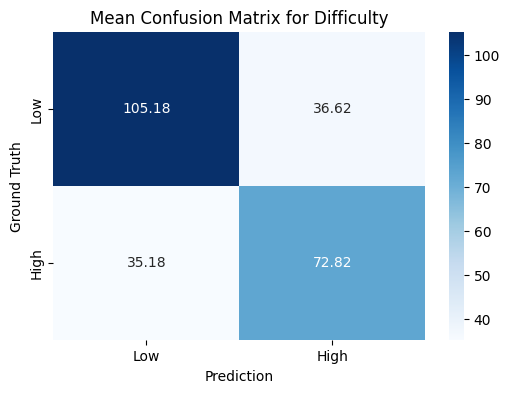

In [103]:
# (Diff) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'n_estimators': [100, 1000],
    'max_depth': [None, 1, 2, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = RandomForestClassifier(criterion='entropy', class_weight='balanced', random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }    
    for train_idx, test_idx in outer_cv.split(X_diff_scaled, y_diff):
        X_train, X_test = X_diff_scaled.iloc[train_idx], X_diff_scaled.iloc[test_idx]
        y_train, y_test = y_diff.iloc[train_idx], y_diff.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Difficulty')
plt.show()

Average Performance across multiple runs:
Accuracy: 71.32%, (~0.27)
Precision: 73.02%, (~0.37)
Recall: 89.12%, (~0.67)
F1 Score: 80.25%, (~0.18)


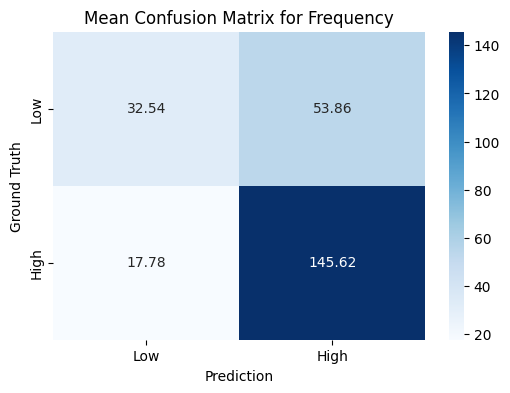

In [104]:
# (Freq) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'n_estimators': [100, 1000],
    'max_depth': [None, 1, 2, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = RandomForestClassifier(criterion='entropy', class_weight='balanced', random_state=random_state)

    inner_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}
    for train_idx, test_idx in outer_cv.split(X_freq_scaled, y_freq):
        X_train, X_test = X_freq_scaled.iloc[train_idx], X_freq_scaled.iloc[test_idx]
        y_train, y_test = y_freq.iloc[train_idx], y_freq.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Frequency')
plt.show()

##### Participant-scaled RF Classifier (Separated)

In [105]:
# Prepare Datasets
df_rf2_diff = df_diff.copy().dropna()
df_rf2_diff['difficulty'] = df_rf2_diff['difficulty'].apply(lambda x: 0 if x == 'Easy' else 1)

df_rf2_diff_scaled = df_rf2_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)

X_diff_scaled = df_rf2_diff_scaled.drop(columns=['difficulty'])
y_diff = df_rf2_diff_scaled['difficulty']


df_rf2_freq = df_freq.copy().dropna()
df_rf2_freq['frequency'] = df_rf2_freq['frequency'].apply(lambda x: 0 if x == 'Slow' else 1)

df_rf2_freq_scaled = df_rf2_freq.groupby('participant_id').apply(scale_by_participant_freq).reset_index(drop=True)

X_freq_scaled = df_rf2_freq_scaled.drop(columns=['frequency'])
y_freq = df_rf2_freq_scaled['frequency']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\2397805282.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_rf2_diff_scaled = df_rf2_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)
C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\2397805282.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_rf2_freq_scaled = df_rf2_freq.groupby('participant_id').apply

In [106]:
# Classes unbalance
print(f"Diff Low:\t{len(df_rf2_diff_scaled.query("difficulty == 0"))}")
print(f"Diff High:\t{len(df_rf2_diff_scaled.query("difficulty == 1"))}")

print()

print(f"Freq Low:\t{len(df_rf2_freq_scaled.query("frequency == 0"))}")
print(f"Freq High:\t{len(df_rf2_freq_scaled.query("frequency == 1"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


Average Performance across multiple runs:
Accuracy: 73.40%, (~0.66)
Precision: 70.56%, (~0.92)
Recall: 71.91%, (~1.01)
F1 Score: 71.14%, (~0.64)


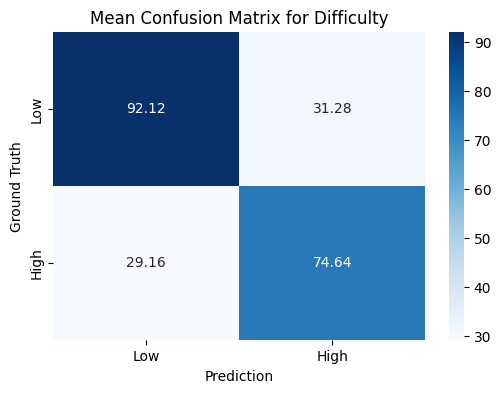

In [107]:
# (Diff) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'n_estimators': [100, 1000],
    'max_depth': [None, 1, 2, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = RandomForestClassifier(criterion='entropy', class_weight='balanced', random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_diff_scaled, y_diff):
        X_train, X_test = X_diff_scaled.iloc[train_idx], X_diff_scaled.iloc[test_idx]
        y_train, y_test = y_diff.iloc[train_idx], y_diff.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Difficulty')
plt.show()

Average Performance across multiple runs:
Accuracy: 72.08%, (~0.32)
Precision: 73.74%, (~0.29)
Recall: 89.22%, (~0.73)
F1 Score: 80.71%, (~0.27)


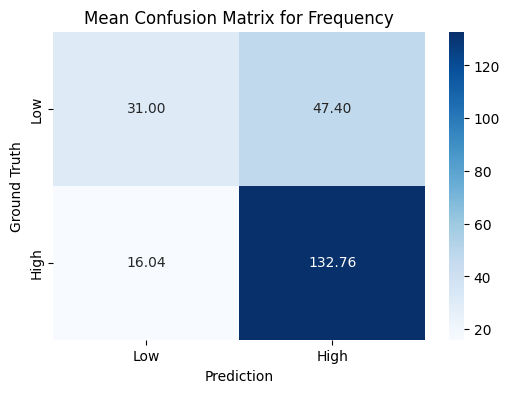

In [108]:
# (Freq) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'n_estimators': [100, 1000],
    'max_depth': [None, 1, 2, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = RandomForestClassifier(criterion='entropy', class_weight='balanced', random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_freq_scaled, y_freq):
        X_train, X_test = X_freq_scaled.iloc[train_idx], X_freq_scaled.iloc[test_idx]
        y_train, y_test = y_freq.iloc[train_idx], y_freq.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Frequency')
plt.show()

##### Undersampled Participant-scaled RF Classifier (Separated)

In [109]:
# Prepare Datasets
df_rf3_diff = df_diff.copy().dropna()
df_rf3_diff['difficulty'] = df_rf3_diff['difficulty'].apply(lambda x: 0 if x == 'Easy' else 1)

df_rf3_diff_scaled = df_rf3_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)

X_diff_scaled = df_rf3_diff_scaled.drop(columns=['difficulty'])
y_diff = df_rf3_diff_scaled['difficulty']


df_rf3_freq = df_freq.copy().dropna()
df_rf3_freq['frequency'] = df_rf3_freq['frequency'].apply(lambda x: 0 if x == 'Slow' else 1)

df_rf3_freq_scaled = df_rf3_freq.groupby('participant_id').apply(scale_by_participant_freq).reset_index(drop=True)

X_freq_scaled = df_rf3_freq_scaled.drop(columns=['frequency'])
y_freq = df_rf3_freq_scaled['frequency']

undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=random_state)
X_diff_scaled_us, y_diff_us = undersampler.fit_resample(X_diff_scaled, y_diff)
X_freq_scaled_us, y_freq_us = undersampler.fit_resample(X_freq_scaled, y_freq)

df_rf3_diff_scaled_us = X_diff_scaled_us.join(y_diff_us)
df_rf3_freq_scaled_us = X_freq_scaled_us.join(y_freq_us)

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\461379336.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_rf3_diff_scaled = df_rf3_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)
C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\461379336.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_rf3_freq_scaled = df_rf3_freq.groupby('participant_id').apply(s

In [110]:
# Classes (un)balance
print(f"Diff Low:\t{len(df_rf3_diff_scaled_us.query("difficulty == 0"))}")
print(f"Diff High:\t{len(df_rf3_diff_scaled_us.query("difficulty == 1"))}")

print()

print(f"Freq Low:\t{len(df_rf3_freq_scaled_us.query("frequency == 0"))}")
print(f"Freq High:\t{len(df_rf3_freq_scaled_us.query("frequency == 1"))}")

Diff Low:	519
Diff High:	519

Freq Low:	392
Freq High:	392


Average Performance across multiple runs:
Accuracy: 73.29%, (~0.78)
Precision: 73.53%, (~0.92)
Recall: 72.93%, (~0.69)
F1 Score: 73.15%, (~0.71)


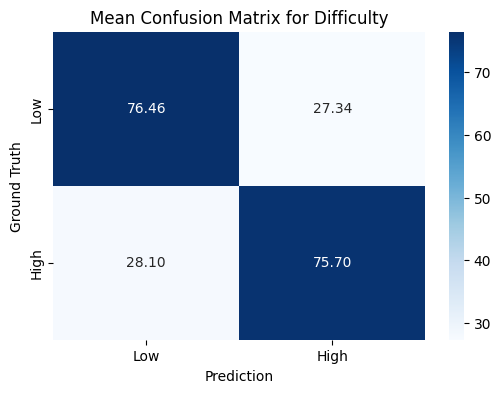

In [111]:
# (Diff) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'n_estimators': [100, 1000],
    'max_depth': [None, 1, 2, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=random_state)
    X_diff_scaled_us, y_diff_us = undersampler.fit_resample(X_diff_scaled, y_diff)

    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = RandomForestClassifier(criterion='gini', random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_diff_scaled_us, y_diff_us):
        X_train, X_test = X_diff_scaled_us.iloc[train_idx], X_diff_scaled_us.iloc[test_idx]
        y_train, y_test = y_diff_us.iloc[train_idx], y_diff_us.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Difficulty')
plt.show()

Average Performance across multiple runs:
Accuracy: 67.68%, (~1.61)
Precision: 67.76%, (~1.54)
Recall: 67.61%, (~2.29)
F1 Score: 67.57%, (~1.80)


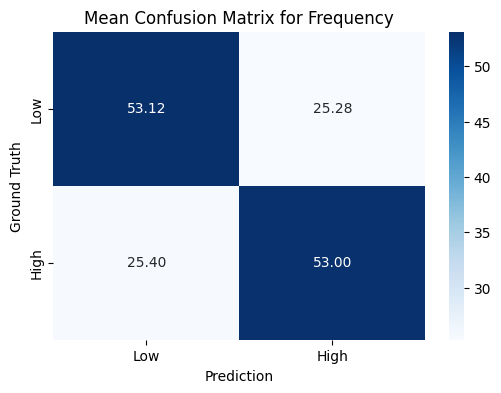

In [112]:
# (Freq) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'n_estimators': [100, 1000],
    'max_depth': [None, 1, 2, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=random_state)
    X_freq_scaled_us, y_freq_us = undersampler.fit_resample(X_freq_scaled, y_freq)

    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = RandomForestClassifier(criterion='gini', random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_freq_scaled_us, y_freq_us):
        X_train, X_test = X_freq_scaled_us.iloc[train_idx], X_freq_scaled_us.iloc[test_idx]
        y_train, y_test = y_freq_us.iloc[train_idx], y_freq_us.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Frequency')
plt.show()

##### Oversampled Participant-scaled RF Classifier (Separated)

In [113]:
# Prepare Datasets
df_rf4_diff = df_diff.copy().dropna()
df_rf4_diff['difficulty'] = df_rf4_diff['difficulty'].apply(lambda x: 0 if x == 'Easy' else 1)

df_rf4_diff_scaled = df_rf4_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)

X_diff_scaled = df_rf4_diff_scaled.drop(columns=['difficulty'])
y_diff = df_rf4_diff_scaled['difficulty']


df_rf4_freq = df_freq.copy().dropna()
df_rf4_freq['frequency'] = df_rf4_freq['frequency'].apply(lambda x: 0 if x == 'Slow' else 1)

df_rf4_freq_scaled = df_rf4_freq.groupby('participant_id').apply(scale_by_participant_freq).reset_index(drop=True)

X_freq_scaled = df_rf4_freq_scaled.drop(columns=['frequency'])
y_freq = df_rf4_freq_scaled['frequency']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\1920263610.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_rf4_diff_scaled = df_rf4_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)
C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\1920263610.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_rf4_freq_scaled = df_rf4_freq.groupby('participant_id').apply

In [114]:
# Classes (un)balance
print(f"Diff Low:\t{len(df_rf4_diff_scaled.query("difficulty == 0"))}")
print(f"Diff High:\t{len(df_rf4_diff_scaled.query("difficulty == 1"))}")

print()

print(f"Freq Low:\t{len(df_rf4_freq_scaled.query("frequency == 0"))}")
print(f"Freq High:\t{len(df_rf4_freq_scaled.query("frequency == 1"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


Average Performance across multiple runs:
Accuracy: 73.55%, (~0.77)
Precision: 71.38%, (~0.91)
Recall: 70.45%, (~1.21)
F1 Score: 70.80%, (~0.91)


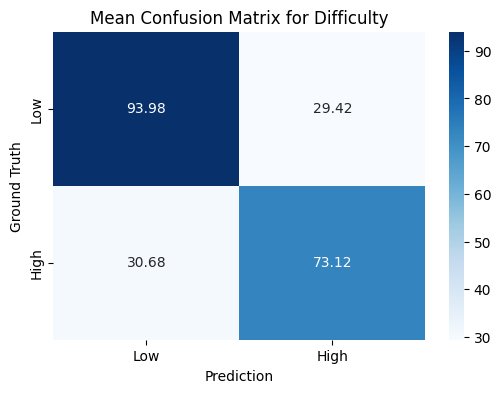

In [115]:
# (Diff) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__n_estimators': [100, 1000],
    'model__max_depth': [None, 1, 2, 3, 5, 10],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        ('model', RandomForestClassifier(criterion='gini', random_state=random_state))
    ])
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_diff_scaled, y_diff):
        X_train, X_test = X_diff_scaled.iloc[train_idx], X_diff_scaled.iloc[test_idx]
        y_train, y_test = y_diff.iloc[train_idx], y_diff.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Difficulty')
plt.show()

Average Performance across multiple runs:
Accuracy: 69.56%, (~1.08)
Precision: 76.78%, (~0.81)
Recall: 76.79%, (~1.19)
F1 Score: 76.74%, (~0.88)


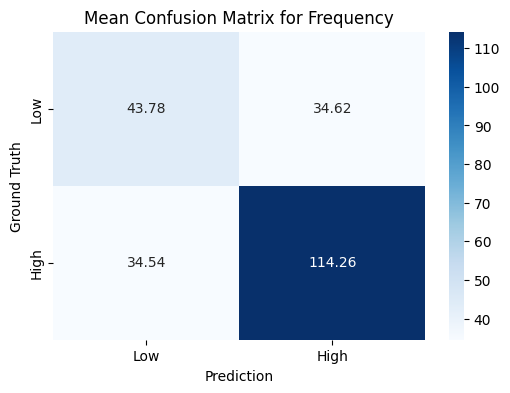

In [116]:
# (Freq) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__n_estimators': [100, 1000],
    'model__max_depth': [None, 1, 2, 5, 10],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        ('model', RandomForestClassifier(criterion='gini', random_state=random_state))
    ])
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_freq_scaled, y_freq):
        X_train, X_test = X_freq_scaled.iloc[train_idx], X_freq_scaled.iloc[test_idx]
        y_train, y_test = y_freq.iloc[train_idx], y_freq.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Frequency')
plt.show()

##### Participant-folded RF Classifier (Separated)

In [383]:
# Prepare Datasets
df_rf5_diff = df_diff.copy().dropna()
df_rf5_diff['difficulty'] = df_rf5_diff['difficulty'].apply(lambda x: 0 if x == 'Easy' else 1)
df_rf5_diff_scaled = df_rf5_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)
participants_ids_diff = df_rf5_diff.reset_index(drop=True)['participant_id']

X_diff_scaled = df_rf5_diff_scaled.drop(columns=['difficulty'])
y_diff = df_rf5_diff_scaled['difficulty']


df_rf5_freq = df_freq.copy().dropna()
df_rf5_freq['frequency'] = df_rf5_freq['frequency'].apply(lambda x: 0 if x == 'Slow' else 1)
df_rf5_freq_scaled = df_rf5_freq.groupby('participant_id').apply(scale_by_participant_freq).reset_index(drop=True)
participants_ids_freq = df_rf5_freq.reset_index(drop=True)['participant_id']

X_freq_scaled = df_rf5_freq_scaled.drop(columns=['frequency'])
y_freq = df_rf5_freq_scaled['frequency']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\588403285.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_rf5_diff_scaled = df_rf5_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)
C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\588403285.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_rf5_freq_scaled = df_rf5_freq.groupby('participant_id').apply(s

In [384]:
# Classes unbalance (NaN dropped)
print(f"Diff Low:\t{len(df_rf5_diff_scaled.query("difficulty == 0"))}")
print(f"Diff High:\t{len(df_rf5_diff_scaled.query("difficulty == 1"))}")

print()

print(f"Freq Low:\t{len(df_rf5_freq_scaled.query("frequency == 0"))}")
print(f"Freq High:\t{len(df_rf5_freq_scaled.query("frequency == 1"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


Average Performance across multiple runs:
Accuracy: 72.56%, (~0.56)
Precision: 70.18%, (~0.80)
Recall: 70.04%, (~0.74)
F1 Score: 69.90%, (~0.57)


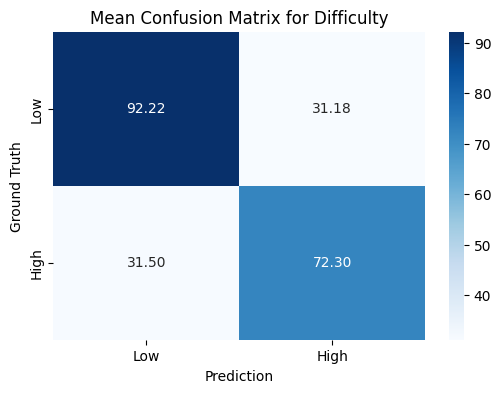

In [385]:
# (Diff) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'n_estimators': [100, 1000],
    'max_depth': [None, 1, 2, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_diff_scaled, y_diff, participants_ids_diff, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)
    model = RandomForestClassifier(criterion='entropy', class_weight='balanced', random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Difficulty')
plt.show()

In [386]:
outer_results['best_params']

[[{'max_depth': 10,
   'min_samples_leaf': 4,
   'min_samples_split': 10,
   'n_estimators': 100},
  {'max_depth': 5,
   'min_samples_leaf': 1,
   'min_samples_split': 10,
   'n_estimators': 100},
  {'max_depth': 5,
   'min_samples_leaf': 2,
   'min_samples_split': 10,
   'n_estimators': 100},
  {'max_depth': None,
   'min_samples_leaf': 1,
   'min_samples_split': 10,
   'n_estimators': 1000},
  {'max_depth': None,
   'min_samples_leaf': 4,
   'min_samples_split': 2,
   'n_estimators': 100}],
 [{'max_depth': 10,
   'min_samples_leaf': 4,
   'min_samples_split': 2,
   'n_estimators': 1000},
  {'max_depth': 10,
   'min_samples_leaf': 1,
   'min_samples_split': 2,
   'n_estimators': 100},
  {'max_depth': 10,
   'min_samples_leaf': 1,
   'min_samples_split': 2,
   'n_estimators': 1000},
  {'max_depth': 5,
   'min_samples_leaf': 2,
   'min_samples_split': 2,
   'n_estimators': 100},
  {'max_depth': 10,
   'min_samples_leaf': 1,
   'min_samples_split': 2,
   'n_estimators': 100}],
 [{'max_de

Average Performance across multiple runs:
Accuracy: 71.27%, (~0.27)
Precision: 73.49%, (~0.31)
Recall: 87.75%, (~0.42)
F1 Score: 79.95%, (~0.15)


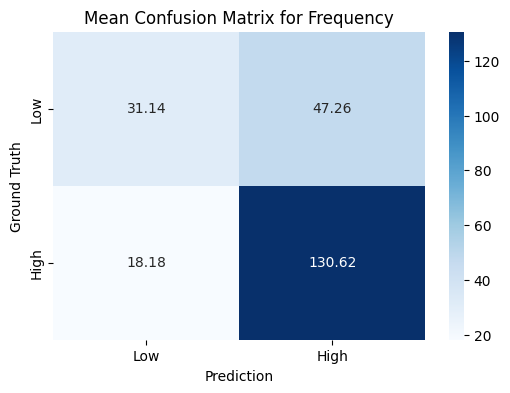

In [387]:
# (Freq) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'n_estimators': [100, 1000],
    'max_depth': [None, 1, 2, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_freq_scaled, y_freq, participants_ids_freq, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)
    model = RandomForestClassifier(criterion='entropy', class_weight='balanced', random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Frequency')
plt.show()

In [388]:
outer_results['best_params']

[[{'max_depth': 10,
   'min_samples_leaf': 1,
   'min_samples_split': 5,
   'n_estimators': 100},
  {'max_depth': None,
   'min_samples_leaf': 1,
   'min_samples_split': 2,
   'n_estimators': 1000},
  {'max_depth': None,
   'min_samples_leaf': 1,
   'min_samples_split': 2,
   'n_estimators': 1000},
  {'max_depth': 10,
   'min_samples_leaf': 1,
   'min_samples_split': 2,
   'n_estimators': 1000},
  {'max_depth': None,
   'min_samples_leaf': 1,
   'min_samples_split': 2,
   'n_estimators': 100}],
 [{'max_depth': None,
   'min_samples_leaf': 1,
   'min_samples_split': 2,
   'n_estimators': 100},
  {'max_depth': None,
   'min_samples_leaf': 1,
   'min_samples_split': 2,
   'n_estimators': 1000},
  {'max_depth': 10,
   'min_samples_leaf': 1,
   'min_samples_split': 2,
   'n_estimators': 100},
  {'max_depth': None,
   'min_samples_leaf': 1,
   'min_samples_split': 2,
   'n_estimators': 100},
  {'max_depth': None,
   'min_samples_leaf': 1,
   'min_samples_split': 2,
   'n_estimators': 1000}],

##### Oversampled Participant-folded RF Classifier (Separate)

In [5]:
# Prepare Datasets
df_rf6_diff = df_diff.copy().dropna()
df_rf6_diff['difficulty'] = df_rf6_diff['difficulty'].apply(lambda x: 0 if x == 'Easy' else 1)
participants_ids_diff = df_rf6_diff.reset_index(drop=True)['participant_id']

df_rf6_diff_scaled = df_rf6_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)

X_diff_scaled = df_rf6_diff_scaled.drop(columns=['difficulty'])
X_diff_scaled_p = X_diff_scaled.copy()
X_diff_scaled_p['participant_id'] = participants_ids_diff
y_diff = df_rf6_diff_scaled['difficulty']



df_rf6_freq = df_freq.copy().dropna()
df_rf6_freq['frequency'] = df_rf6_freq['frequency'].apply(lambda x: 0 if x == 'Slow' else 1)
participants_ids_freq = df_rf6_freq.reset_index(drop=True)['participant_id']

df_rf6_freq_scaled = df_rf6_freq.groupby('participant_id').apply(scale_by_participant_freq).reset_index(drop=True)

X_freq_scaled = df_rf6_freq_scaled.drop(columns=['frequency'])
X_freq_scaled_p = X_freq_scaled.copy()
X_freq_scaled_p['participant_id'] = participants_ids_freq
y_freq = df_rf6_freq_scaled['frequency']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_1936\3742820304.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_rf6_diff_scaled = df_rf6_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)
C:\Users\vale_ad\AppData\Local\Temp\ipykernel_1936\3742820304.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_rf6_freq_scaled = df_rf6_freq.groupby('participant_id').apply(s

In [6]:
# Classes (un)balance (NaN dropped)
print(f"Diff Low:\t{len(df_rf6_diff_scaled.query("difficulty == 0"))}")
print(f"Diff High:\t{len(df_rf6_diff_scaled.query("difficulty == 1"))}")

print()

print(f"Freq Low:\t{len(df_rf6_freq_scaled.query("frequency == 0"))}")
print(f"Freq High:\t{len(df_rf6_freq_scaled.query("frequency == 1"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


Average Performance across multiple runs:
Accuracy: 72.59%, (~0.48)
Precision: 70.55%, (~0.55)
Recall: 69.13%, (~0.77)
F1 Score: 69.64%, (~0.55)


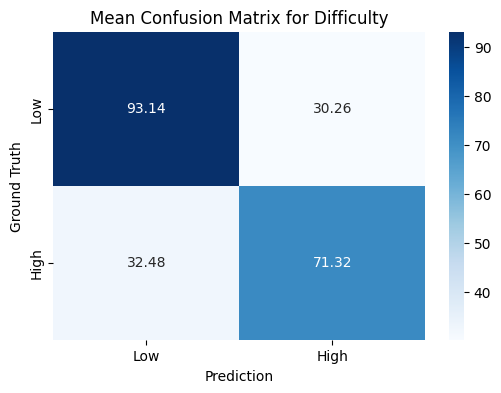

In [391]:
# (Diff) Group-folded nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__n_estimators': [100, 1000],
    'model__max_depth': [None, 1, 2, 3, 5, 10],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        ('model', RandomForestClassifier(criterion='gini', random_state=random_state))
    ])
    participants_ids = X_diff_scaled_p['participant_id']
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_diff_scaled, y_diff, participants_ids_diff, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }    
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Difficulty')
plt.show()

In [392]:
outer_results['best_params']

[[{'model__max_depth': None,
   'model__min_samples_leaf': 4,
   'model__min_samples_split': 10,
   'model__n_estimators': 1000},
  {'model__max_depth': None,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 5,
   'model__n_estimators': 100},
  {'model__max_depth': None,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 5,
   'model__n_estimators': 100},
  {'model__max_depth': None,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 5,
   'model__n_estimators': 1000},
  {'model__max_depth': None,
   'model__min_samples_leaf': 2,
   'model__min_samples_split': 5,
   'model__n_estimators': 100}],
 [{'model__max_depth': 10,
   'model__min_samples_leaf': 2,
   'model__min_samples_split': 2,
   'model__n_estimators': 1000},
  {'model__max_depth': None,
   'model__min_samples_leaf': 2,
   'model__min_samples_split': 10,
   'model__n_estimators': 100},
  {'model__max_depth': 10,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 2,
   'mo

Average Performance across multiple runs:
Accuracy: 68.06%, (~0.58)
Precision: 76.74%, (~0.45)
Recall: 73.45%, (~0.82)
F1 Score: 75.00%, (~0.54)


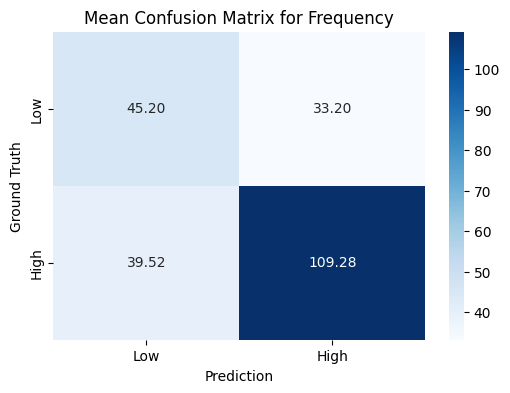

In [7]:
# (Freq) Group-folded nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__n_estimators': [100, 1000],
    'model__max_depth': [None, 1, 2, 3, 5, 10],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        ('model', RandomForestClassifier(criterion='gini', random_state=random_state))
    ])
    participants_ids = X_freq_scaled_p['participant_id']
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_freq_scaled, y_freq, participants_ids_freq, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)
    
    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }    
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Frequency')
plt.show()

In [8]:
outer_results['best_params']

[[{'model__max_depth': 10,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 2,
   'model__n_estimators': 100},
  {'model__max_depth': None,
   'model__min_samples_leaf': 2,
   'model__min_samples_split': 10,
   'model__n_estimators': 1000},
  {'model__max_depth': 10,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 5,
   'model__n_estimators': 1000},
  {'model__max_depth': 10,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 5,
   'model__n_estimators': 1000},
  {'model__max_depth': 10,
   'model__min_samples_leaf': 2,
   'model__min_samples_split': 5,
   'model__n_estimators': 100}],
 [{'model__max_depth': None,
   'model__min_samples_leaf': 4,
   'model__min_samples_split': 10,
   'model__n_estimators': 1000},
  {'model__max_depth': None,
   'model__min_samples_leaf': 2,
   'model__min_samples_split': 2,
   'model__n_estimators': 100},
  {'model__max_depth': None,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 10,
   'mode

##### Undersampled Participant-folded RF Classifier (Separate)

In [9]:
# Prepare Datasets
df_rf7_diff = df_diff.copy().dropna()
df_rf7_diff['difficulty'] = df_rf7_diff['difficulty'].apply(lambda x: 0 if x == 'Easy' else 1)
participants_ids_diff = df_rf7_diff.reset_index(drop=True)['participant_id']

df_rf7_diff_scaled = df_rf7_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)

X_diff_scaled = df_rf7_diff_scaled.drop(columns=['difficulty'])
X_diff_scaled_p = X_diff_scaled.copy()
X_diff_scaled_p['participant_id'] = participants_ids_diff
y_diff = df_rf7_diff_scaled['difficulty']



df_rf7_freq = df_freq.copy().dropna()
df_rf7_freq['frequency'] = df_rf7_freq['frequency'].apply(lambda x: 0 if x == 'Slow' else 1)
participants_ids_freq = df_rf7_freq.reset_index(drop=True)['participant_id']

df_rf7_freq_scaled = df_rf7_freq.groupby('participant_id').apply(scale_by_participant_freq).reset_index(drop=True)

X_freq_scaled = df_rf7_freq_scaled.drop(columns=['frequency'])
X_freq_scaled_p = X_freq_scaled.copy()
X_freq_scaled_p['participant_id'] = participants_ids_freq
y_freq = df_rf7_freq_scaled['frequency']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_1936\4164382249.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_rf7_diff_scaled = df_rf7_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)
C:\Users\vale_ad\AppData\Local\Temp\ipykernel_1936\4164382249.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_rf7_freq_scaled = df_rf7_freq.groupby('participant_id').apply(s

In [10]:
# Classes (un)balance (NaN dropped)
print(f"Diff Low:\t{len(df_rf7_diff_scaled.query("difficulty == 0"))}")
print(f"Diff High:\t{len(df_rf7_diff_scaled.query("difficulty == 1"))}")

print()

print(f"Freq Low:\t{len(df_rf7_freq_scaled.query("frequency == 0"))}")
print(f"Freq High:\t{len(df_rf7_freq_scaled.query("frequency == 1"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


Average Performance across multiple runs:
Accuracy: 72.37%, (~0.49)
Precision: 69.33%, (~0.57)
Recall: 71.42%, (~0.99)
F1 Score: 70.18%, (~0.63)


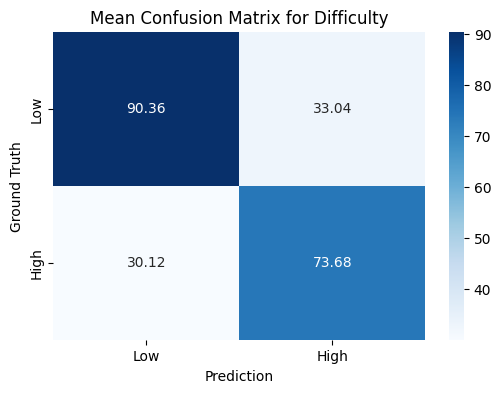

In [11]:
# (Diff) Group-folded nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__n_estimators': [100, 1000],
    'model__max_depth': [None, 1, 2, 3, 5, 10],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('undersample', RandomUnderSampler(sampling_strategy='auto', random_state=random_state)),
        ('model', RandomForestClassifier(criterion='gini', random_state=random_state))
    ])
    participants_ids = X_diff_scaled_p['participant_id']
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_diff_scaled, y_diff, participants_ids_diff, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }    
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Difficulty')
plt.show()

In [12]:
outer_results['best_params']

[[{'model__max_depth': 10,
   'model__min_samples_leaf': 4,
   'model__min_samples_split': 2,
   'model__n_estimators': 100},
  {'model__max_depth': 10,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 10,
   'model__n_estimators': 1000},
  {'model__max_depth': None,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 2,
   'model__n_estimators': 1000},
  {'model__max_depth': None,
   'model__min_samples_leaf': 2,
   'model__min_samples_split': 10,
   'model__n_estimators': 100},
  {'model__max_depth': 10,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 5,
   'model__n_estimators': 100}],
 [{'model__max_depth': 10,
   'model__min_samples_leaf': 2,
   'model__min_samples_split': 2,
   'model__n_estimators': 1000},
  {'model__max_depth': 10,
   'model__min_samples_leaf': 4,
   'model__min_samples_split': 10,
   'model__n_estimators': 100},
  {'model__max_depth': None,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 5,
   'model__

Average Performance across multiple runs:
Accuracy: 65.65%, (~0.77)
Precision: 78.22%, (~0.75)
Recall: 65.64%, (~1.04)
F1 Score: 71.26%, (~0.73)


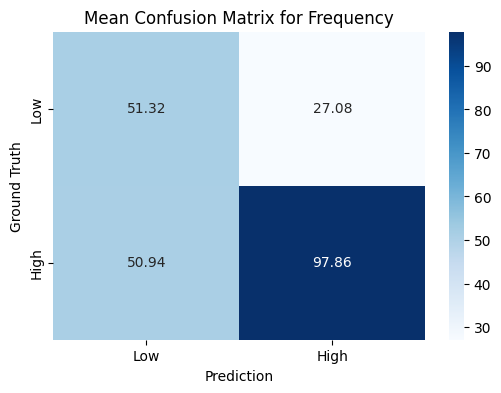

In [13]:
# (Freq) Group-folded nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__n_estimators': [100, 1000],
    'model__max_depth': [None, 1, 2, 3, 5, 10],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('undersample', RandomUnderSampler(sampling_strategy='auto', random_state=random_state)),
        ('model', RandomForestClassifier(criterion='gini', random_state=random_state))
    ])
    participants_ids = X_freq_scaled_p['participant_id']
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_freq_scaled, y_freq, participants_ids_freq, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)
    
    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }    
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Frequency')
plt.show()

In [14]:
outer_results['best_params']

[[{'model__max_depth': 5,
   'model__min_samples_leaf': 4,
   'model__min_samples_split': 10,
   'model__n_estimators': 100},
  {'model__max_depth': 5,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 5,
   'model__n_estimators': 100},
  {'model__max_depth': 3,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 2,
   'model__n_estimators': 100},
  {'model__max_depth': 5,
   'model__min_samples_leaf': 2,
   'model__min_samples_split': 10,
   'model__n_estimators': 100},
  {'model__max_depth': 5,
   'model__min_samples_leaf': 2,
   'model__min_samples_split': 10,
   'model__n_estimators': 100}],
 [{'model__max_depth': 5,
   'model__min_samples_leaf': 2,
   'model__min_samples_split': 2,
   'model__n_estimators': 100},
  {'model__max_depth': 5,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 10,
   'model__n_estimators': 100},
  {'model__max_depth': 5,
   'model__min_samples_leaf': 4,
   'model__min_samples_split': 2,
   'model__n_estimators': 1

##### Participant-folded RF (MultiClass)

In [73]:
# Prepare Dataset
df_rf9 = df.copy().dropna()
df_rf9_scaled = df_rf9.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)
participants_ids = df_rf9.reset_index(drop=True)['participant_id']

X_scaled = df_rf9_scaled.drop(columns=['condition'])
X_scaled_p = X_scaled.copy()
X_scaled_p['participant_id'] = participants_ids
y = df_rf9_scaled['condition']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_17796\1555873916.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_rf9_scaled = df_rf9.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [74]:
# Classes unbalance (NaN dropped)
print(f"Diff Low:\t{len(df_rf9_scaled.query("condition == 'Easy_Slow' | condition == 'Easy_Fast'"))}")
print(f"Diff High:\t{len(df_rf9_scaled.query("condition == 'Hard_Slow' | condition == 'Hard_Fast'"))}")

print()

print(f"Freq Low:\t{len(df_rf9_scaled.query("condition == 'Easy_Slow' | condition == 'Hard_Slow'"))}")
print(f"Freq High:\t{len(df_rf9_scaled.query("condition == 'Easy_Fast' | condition == 'Hard_Fast'"))}")

print()
print()

print(f"Easy Slow:\t{len(df_rf9_scaled.query("condition == 'Easy_Slow'"))}")
print(f"Easy Fast:\t{len(df_rf9_scaled.query("condition == 'Easy_Fast'"))}")
print(f"Hard Slow:\t{len(df_rf9_scaled.query("condition == 'Hard_Slow'"))}")
print(f"Hard Fast:\t{len(df_rf9_scaled.query("condition == 'Hard_Fast'"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


Easy Slow:	205
Easy Fast:	412
Hard Slow:	187
Hard Fast:	332


Average Performance across multiple runs:
Accuracy: 50.39%, (~1.22)
Precision: 47.56%, (~1.13)
Recall: 47.26%, (~0.89)
F1 Score: 46.72%, (~0.95)


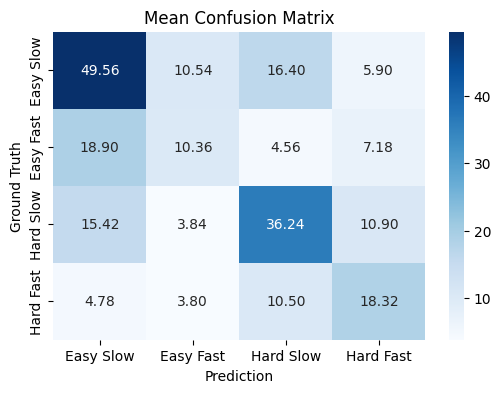

In [75]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__n_estimators': [100, 1000],
    'model__max_depth': [None, 1, 2, 3, 5, 10],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        # ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        # ('undersample', RandomUnderSampler(sampling_strategy='auto', random_state=random_state)),
        ('model', RandomForestClassifier(criterion='entropy', class_weight='balanced', random_state=random_state))
    ])
    participants_ids = X_scaled_p['participant_id']
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_scaled, y, participants_ids, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='recall_macro', refit='recall_macro', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred, average='macro', zero_division=0))
        inner_results['recall'].append(recall_score(y_test, y_pred, average='macro'))
        inner_results['f1'].append(f1_score(y_test, y_pred, average='macro'))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred, labels=class_order))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

In [76]:
outer_results['best_params']

[[{'model__max_depth': None,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 10,
   'model__n_estimators': 1000},
  {'model__max_depth': None,
   'model__min_samples_leaf': 4,
   'model__min_samples_split': 10,
   'model__n_estimators': 1000},
  {'model__max_depth': None,
   'model__min_samples_leaf': 4,
   'model__min_samples_split': 10,
   'model__n_estimators': 1000},
  {'model__max_depth': None,
   'model__min_samples_leaf': 4,
   'model__min_samples_split': 2,
   'model__n_estimators': 100},
  {'model__max_depth': None,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 10,
   'model__n_estimators': 100}],
 [{'model__max_depth': 10,
   'model__min_samples_leaf': 4,
   'model__min_samples_split': 10,
   'model__n_estimators': 1000},
  {'model__max_depth': 5,
   'model__min_samples_leaf': 4,
   'model__min_samples_split': 10,
   'model__n_estimators': 1000},
  {'model__max_depth': 10,
   'model__min_samples_leaf': 4,
   'model__min_samples_split': 10,
  

##### Oversampled Participant-folded RF (MultiClass)

In [77]:
# Prepare Dataset
df_rf9 = df.copy().dropna()
df_rf9_scaled = df_rf9.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)
participants_ids = df_rf9.reset_index(drop=True)['participant_id']

X_scaled = df_rf9_scaled.drop(columns=['condition'])
X_scaled_p = X_scaled.copy()
X_scaled_p['participant_id'] = participants_ids
y = df_rf9_scaled['condition']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_17796\1555873916.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_rf9_scaled = df_rf9.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [78]:
# Classes unbalance (NaN dropped)
print(f"Diff Low:\t{len(df_rf9_scaled.query("condition == 'Easy_Slow' | condition == 'Easy_Fast'"))}")
print(f"Diff High:\t{len(df_rf9_scaled.query("condition == 'Hard_Slow' | condition == 'Hard_Fast'"))}")

print()

print(f"Freq Low:\t{len(df_rf9_scaled.query("condition == 'Easy_Slow' | condition == 'Hard_Slow'"))}")
print(f"Freq High:\t{len(df_rf9_scaled.query("condition == 'Easy_Fast' | condition == 'Hard_Fast'"))}")

print()
print()

print(f"Easy Slow:\t{len(df_rf9_scaled.query("condition == 'Easy_Slow'"))}")
print(f"Easy Fast:\t{len(df_rf9_scaled.query("condition == 'Easy_Fast'"))}")
print(f"Hard Slow:\t{len(df_rf9_scaled.query("condition == 'Hard_Slow'"))}")
print(f"Hard Fast:\t{len(df_rf9_scaled.query("condition == 'Hard_Fast'"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


Easy Slow:	205
Easy Fast:	412
Hard Slow:	187
Hard Fast:	332


Average Performance across multiple runs:
Accuracy: 49.00%, (~0.91)
Precision: 46.74%, (~0.92)
Recall: 47.59%, (~0.80)
F1 Score: 46.63%, (~0.87)


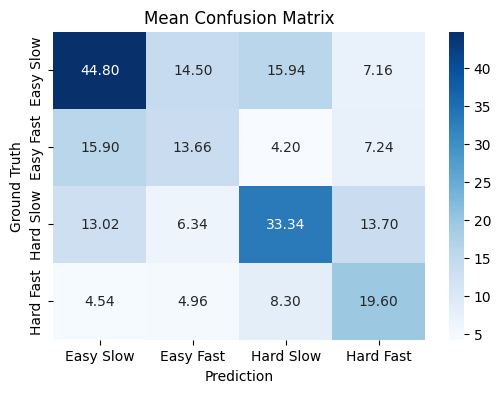

In [79]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__n_estimators': [100, 1000],
    'model__max_depth': [None, 1, 2, 3, 5, 10],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        # ('undersample', RandomUnderSampler(sampling_strategy='auto', random_state=random_state)),
        ('model', RandomForestClassifier(criterion='entropy', class_weight='balanced', random_state=random_state))
    ])
    participants_ids = X_scaled_p['participant_id']
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_scaled, y, participants_ids, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='recall_macro', refit='recall_macro', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred, average='macro', zero_division=0))
        inner_results['recall'].append(recall_score(y_test, y_pred, average='macro'))
        inner_results['f1'].append(f1_score(y_test, y_pred, average='macro'))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred, labels=class_order))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

In [80]:
outer_results['best_params']

[[{'model__max_depth': 10,
   'model__min_samples_leaf': 4,
   'model__min_samples_split': 2,
   'model__n_estimators': 100},
  {'model__max_depth': None,
   'model__min_samples_leaf': 2,
   'model__min_samples_split': 2,
   'model__n_estimators': 1000},
  {'model__max_depth': None,
   'model__min_samples_leaf': 2,
   'model__min_samples_split': 10,
   'model__n_estimators': 100},
  {'model__max_depth': 5,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 5,
   'model__n_estimators': 100},
  {'model__max_depth': 10,
   'model__min_samples_leaf': 4,
   'model__min_samples_split': 2,
   'model__n_estimators': 1000}],
 [{'model__max_depth': None,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 5,
   'model__n_estimators': 1000},
  {'model__max_depth': 10,
   'model__min_samples_leaf': 2,
   'model__min_samples_split': 10,
   'model__n_estimators': 100},
  {'model__max_depth': 10,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 5,
   'model__n_

##### Undersampled Participant-folded RF (MultiClass)

In [81]:
# Prepare Dataset
df_rf9 = df.copy().dropna()
df_rf9_scaled = df_rf9.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)
participants_ids = df_rf9.reset_index(drop=True)['participant_id']

X_scaled = df_rf9_scaled.drop(columns=['condition'])
X_scaled_p = X_scaled.copy()
X_scaled_p['participant_id'] = participants_ids
y = df_rf9_scaled['condition']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_17796\1555873916.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_rf9_scaled = df_rf9.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [82]:
# Classes unbalance (NaN dropped)
print(f"Diff Low:\t{len(df_rf9_scaled.query("condition == 'Easy_Slow' | condition == 'Easy_Fast'"))}")
print(f"Diff High:\t{len(df_rf9_scaled.query("condition == 'Hard_Slow' | condition == 'Hard_Fast'"))}")

print()

print(f"Freq Low:\t{len(df_rf9_scaled.query("condition == 'Easy_Slow' | condition == 'Hard_Slow'"))}")
print(f"Freq High:\t{len(df_rf9_scaled.query("condition == 'Easy_Fast' | condition == 'Hard_Fast'"))}")

print()
print()

print(f"Easy Slow:\t{len(df_rf9_scaled.query("condition == 'Easy_Slow'"))}")
print(f"Easy Fast:\t{len(df_rf9_scaled.query("condition == 'Easy_Fast'"))}")
print(f"Hard Slow:\t{len(df_rf9_scaled.query("condition == 'Hard_Slow'"))}")
print(f"Hard Fast:\t{len(df_rf9_scaled.query("condition == 'Hard_Fast'"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


Easy Slow:	205
Easy Fast:	412
Hard Slow:	187
Hard Fast:	332


Average Performance across multiple runs:
Accuracy: 46.22%, (~0.94)
Precision: 45.51%, (~1.08)
Recall: 46.89%, (~0.99)
F1 Score: 45.14%, (~1.03)


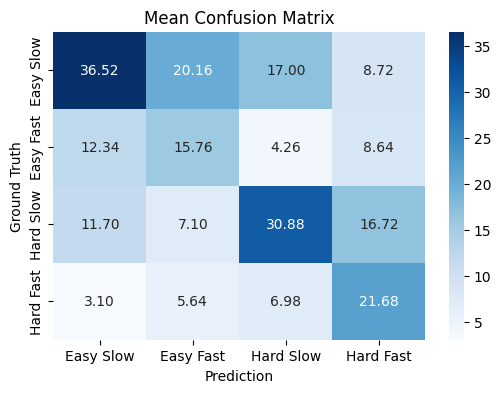

In [83]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__n_estimators': [100, 1000],
    'model__max_depth': [None, 1, 2, 3, 5, 10],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        # ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        ('undersample', RandomUnderSampler(sampling_strategy='auto', random_state=random_state)),
        ('model', RandomForestClassifier(criterion='entropy', class_weight='balanced', random_state=random_state))
    ])
    participants_ids = X_scaled_p['participant_id']
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_scaled, y, participants_ids, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='recall_macro', refit='recall_macro', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred, average='macro', zero_division=0))
        inner_results['recall'].append(recall_score(y_test, y_pred, average='macro'))
        inner_results['f1'].append(f1_score(y_test, y_pred, average='macro'))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred, labels=class_order))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

In [84]:
outer_results['best_params']

[[{'model__max_depth': None,
   'model__min_samples_leaf': 4,
   'model__min_samples_split': 2,
   'model__n_estimators': 1000},
  {'model__max_depth': 10,
   'model__min_samples_leaf': 2,
   'model__min_samples_split': 2,
   'model__n_estimators': 1000},
  {'model__max_depth': None,
   'model__min_samples_leaf': 2,
   'model__min_samples_split': 5,
   'model__n_estimators': 1000},
  {'model__max_depth': 10,
   'model__min_samples_leaf': 2,
   'model__min_samples_split': 5,
   'model__n_estimators': 1000},
  {'model__max_depth': 10,
   'model__min_samples_leaf': 1,
   'model__min_samples_split': 10,
   'model__n_estimators': 1000}],
 [{'model__max_depth': None,
   'model__min_samples_leaf': 2,
   'model__min_samples_split': 5,
   'model__n_estimators': 1000},
  {'model__max_depth': 10,
   'model__min_samples_leaf': 4,
   'model__min_samples_split': 2,
   'model__n_estimators': 100},
  {'model__max_depth': None,
   'model__min_samples_leaf': 4,
   'model__min_samples_split': 2,
   'mode

### 4. Gradient Boosting Machines Classifier

##### Basic GBM (MultiClass)

! Participant_id and NaN are dropped 

- Change kernel (?)

In [135]:
# Prepare Dataset
df_gbm1 = df.copy()
df_gbm1 = df_gbm1.drop(columns=['participant_id']).dropna()

X = df_gbm1.drop(columns=['condition', 'difficulty', 'frequency'])
y = df_gbm1['condition']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

df_gbm1_scaled = pd.concat([X_scaled, y.reset_index(drop=True)], axis=1)

In [136]:
# Classes unbalance (NaN dropped)
print(f"Diff Low:\t{len(df_gbm1_scaled.query("condition == 'Easy_Slow' | condition == 'Easy_Fast'"))}")
print(f"Diff High:\t{len(df_gbm1_scaled.query("condition == 'Hard_Slow' | condition == 'Hard_Fast'"))}")

print()

print(f"Freq Low:\t{len(df_gbm1_scaled.query("condition == 'Easy_Slow' | condition == 'Hard_Slow'"))}")
print(f"Freq High:\t{len(df_gbm1_scaled.query("condition == 'Easy_Fast' | condition == 'Hard_Fast'"))}")

print()
print()

print(f"Easy Slow:\t{len(df_gbm1_scaled.query("condition == 'Easy_Slow'"))}")
print(f"Easy Fast:\t{len(df_gbm1_scaled.query("condition == 'Easy_Fast'"))}")
print(f"Hard Slow:\t{len(df_gbm1_scaled.query("condition == 'Hard_Slow'"))}")
print(f"Hard Fast:\t{len(df_gbm1_scaled.query("condition == 'Hard_Fast'"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


Easy Slow:	205
Easy Fast:	412
Hard Slow:	187
Hard Fast:	332


Average Performance across multiple runs:
Accuracy: 47.14%, (~1.57)
Precision: 45.45%, (~1.75)
Recall: 43.45%, (~1.54)
F1 Score: 43.87%, (~1.61)


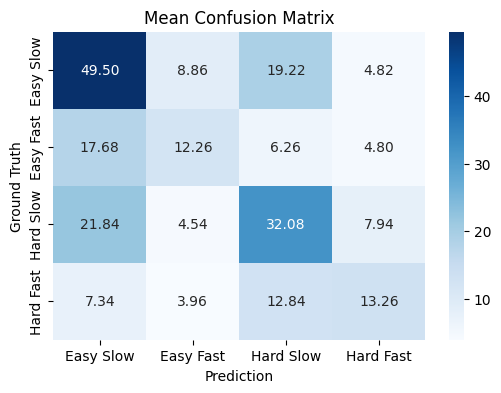

In [137]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [1, 2, 3, 5]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = GradientBoostingClassifier(random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_scaled, y):
        X_train, X_test = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1_macro', refit='f1_macro', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred, average='macro'))
        inner_results['recall'].append(recall_score(y_test, y_pred, average='macro'))
        inner_results['f1'].append(f1_score(y_test, y_pred, average='macro'))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

##### Participant-scaled GBM (MultiClass)

In [138]:
# Prepare Dataset
df_gbm2 = df.copy().dropna()
df_gbm2_scaled = df_gbm2.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)

X_scaled = df_gbm2_scaled.drop(columns=['condition'])
y = df_gbm2_scaled['condition']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\3685357741.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_gbm2_scaled = df_gbm2.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [139]:
# Classes unbalance (NaN dropped)
print(f"Diff Low:\t{len(df_gbm2_scaled.query("condition == 'Easy_Slow' | condition == 'Easy_Fast'"))}")
print(f"Diff High:\t{len(df_gbm2_scaled.query("condition == 'Hard_Slow' | condition == 'Hard_Fast'"))}")

print()

print(f"Freq Low:\t{len(df_gbm2_scaled.query("condition == 'Easy_Slow' | condition == 'Hard_Slow'"))}")
print(f"Freq High:\t{len(df_gbm2_scaled.query("condition == 'Easy_Fast' | condition == 'Hard_Fast'"))}")

print()
print()

print(f"Easy Slow:\t{len(df_gbm2_scaled.query("condition == 'Easy_Slow'"))}")
print(f"Easy Fast:\t{len(df_gbm2_scaled.query("condition == 'Easy_Fast'"))}")
print(f"Hard Slow:\t{len(df_gbm2_scaled.query("condition == 'Hard_Slow'"))}")
print(f"Hard Fast:\t{len(df_gbm2_scaled.query("condition == 'Hard_Fast'"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


Easy Slow:	205
Easy Fast:	412
Hard Slow:	187
Hard Fast:	332


Average Performance across multiple runs:
Accuracy: 50.80%, (~0.83)
Precision: 48.67%, (~0.78)
Recall: 46.18%, (~0.91)
F1 Score: 46.53%, (~0.88)


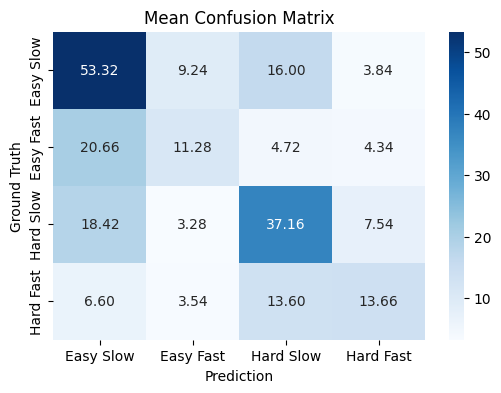

In [140]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [1, 2, 3, 5]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = GradientBoostingClassifier(random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_scaled, y):
        X_train, X_test = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1_macro', refit='f1_macro', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred, average='macro'))
        inner_results['recall'].append(recall_score(y_test, y_pred, average='macro'))
        inner_results['f1'].append(f1_score(y_test, y_pred, average='macro'))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

##### Basic GBM (Separated)

In [141]:
# Prepare Datasets
df_gbm1_diff = df_diff.copy()
df_gbm1_diff = df_gbm1_diff.drop(columns=['participant_id']).dropna()
df_gbm1_diff['difficulty'] = df_gbm1_diff['difficulty'].apply(lambda x: 0 if x == 'Easy' else 1)

X_diff = df_gbm1_diff.drop(columns=['difficulty'])
y_diff = df_gbm1_diff['difficulty']

scaler = StandardScaler()
X_diff_scaled = scaler.fit_transform(X_diff)
X_diff_scaled = pd.DataFrame(X_diff_scaled, columns=X_diff.columns)

df_gbm1_diff_scaled = pd.concat([X_diff_scaled, y_diff.reset_index(drop=True)], axis=1)


df_gbm1_freq = df_freq.copy()
df_gbm1_freq = df_gbm1_freq.drop(columns=['participant_id']).dropna()
df_gbm1_freq['frequency'] = df_gbm1_freq['frequency'].apply(lambda x: 0 if x == 'Slow' else 1)

X_freq = df_gbm1_freq.drop(columns=['frequency'])
y_freq = df_gbm1_freq['frequency']

scaler = StandardScaler()
X_freq_scaled = scaler.fit_transform(X_freq)
X_freq_scaled = pd.DataFrame(X_freq_scaled, columns=X_freq.columns)

df_gbm1_freq_scaled = pd.concat([X_freq_scaled, y_freq.reset_index(drop=True)], axis=1)

In [142]:
# Classes unbalance (NaN dropped)
print(f"Diff Low:\t{len(df_gbm1_diff_scaled.query("difficulty == 0"))}")
print(f"Diff High:\t{len(df_gbm1_diff_scaled.query("difficulty == 1"))}")

print()

print(f"Freq Low:\t{len(df_gbm1_freq_scaled.query("frequency == 0"))}")
print(f"Freq High:\t{len(df_gbm1_freq_scaled.query("frequency == 1"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


Average Performance across multiple runs:
Accuracy: 69.41%, (~0.72)
Precision: 67.43%, (~0.86)
Recall: 64.04%, (~1.35)
F1 Score: 65.61%, (~0.95)


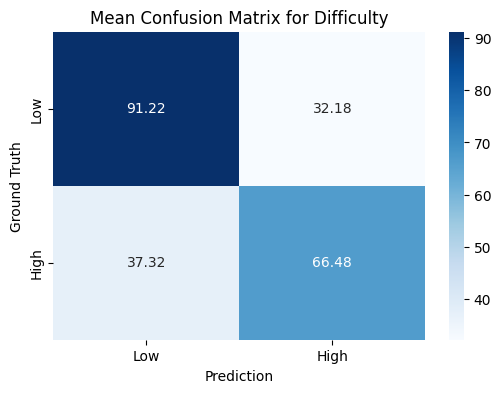

In [143]:
# (Diff) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [1, 2, 3, 5]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = GradientBoostingClassifier(random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_diff_scaled, y_diff):
        X_train, X_test = X_diff_scaled.iloc[train_idx], X_diff_scaled.iloc[test_idx]
        y_train, y_test = y_diff.iloc[train_idx], y_diff.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Difficulty')
plt.show()

Average Performance across multiple runs:
Accuracy: 70.49%, (~1.03)
Precision: 71.18%, (~1.06)
Recall: 92.80%, (~1.47)
F1 Score: 80.45%, (~0.56)


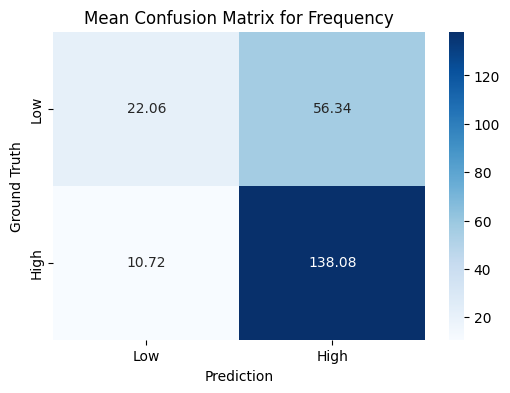

In [144]:
# (Freq) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [1, 2, 3, 5]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = GradientBoostingClassifier(random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_freq_scaled, y_freq):
        X_train, X_test = X_freq_scaled.iloc[train_idx], X_freq_scaled.iloc[test_idx]
        y_train, y_test = y_freq.iloc[train_idx], y_freq.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Frequency')
plt.show()

##### Participant-scaled GBM (Separated)

In [145]:
# Prepare Datasets
df_gbm2_diff = df_diff.copy().dropna()
df_gbm2_diff['difficulty'] = df_gbm2_diff['difficulty'].apply(lambda x: 0 if x == 'Easy' else 1)
df_gbm2_diff_scaled = df_gbm2_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)

X_diff_scaled = df_gbm2_diff_scaled.drop(columns=['difficulty'])
y_diff = df_gbm2_diff_scaled['difficulty']


df_gbm2_freq = df_freq.copy().dropna()
df_gbm2_freq['frequency'] = df_gbm2_freq['frequency'].apply(lambda x: 0 if x == 'Slow' else 1)
df_gbm2_freq_scaled = df_gbm2_freq.groupby('participant_id').apply(scale_by_participant_freq).reset_index(drop=True)

X_freq_scaled = df_gbm2_freq_scaled.drop(columns=['frequency'])
y_freq = df_gbm2_freq_scaled['frequency']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\2262376787.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_gbm2_diff_scaled = df_gbm2_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)
C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\2262376787.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_gbm2_freq_scaled = df_gbm2_freq.groupby('participant_id').a

In [146]:
# Classes unbalance (NaN dropped)
print(f"Diff Low:\t{len(df_gbm2_diff_scaled.query("difficulty == 0"))}")
print(f"Diff High:\t{len(df_gbm2_diff_scaled.query("difficulty == 1"))}")

print()

print(f"Freq Low:\t{len(df_gbm2_freq_scaled.query("frequency == 0"))}")
print(f"Freq High:\t{len(df_gbm2_freq_scaled.query("frequency == 1"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


Average Performance across multiple runs:
Accuracy: 73.17%, (~1.05)
Precision: 70.89%, (~1.37)
Recall: 70.22%, (~1.30)
F1 Score: 70.44%, (~1.09)


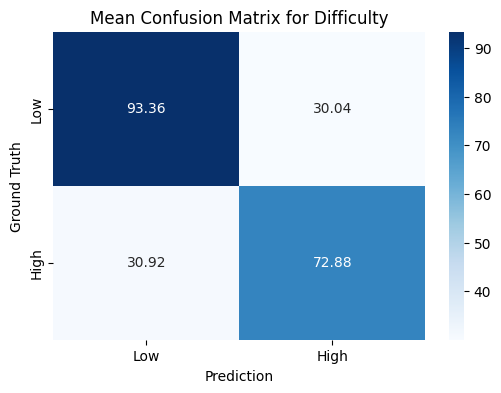

In [147]:
# (Diff) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [1, 2, 3, 5]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = GradientBoostingClassifier(random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_diff_scaled, y_diff):
        X_train, X_test = X_diff_scaled.iloc[train_idx], X_diff_scaled.iloc[test_idx]
        y_train, y_test = y_diff.iloc[train_idx], y_diff.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Difficulty')
plt.show()

Average Performance across multiple runs:
Accuracy: 71.31%, (~0.61)
Precision: 71.69%, (~0.48)
Recall: 93.05%, (~1.20)
F1 Score: 80.94%, (~0.47)


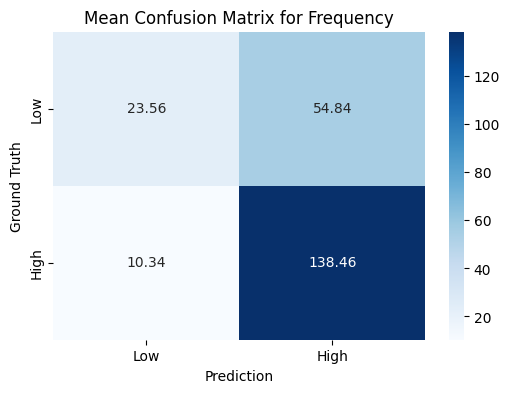

In [148]:
# (Freq) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [1, 2, 3, 5]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = GradientBoostingClassifier(random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_freq_scaled, y_freq):
        X_train, X_test = X_freq_scaled.iloc[train_idx], X_freq_scaled.iloc[test_idx]
        y_train, y_test = y_freq.iloc[train_idx], y_freq.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Frequency')
plt.show()

##### Undersampled Participant-scaled GBM Classifier (Separated)

In [149]:
# Prepare Datasets
df_gbm3_diff = df_diff.copy().dropna()
df_gbm3_diff['difficulty'] = df_gbm3_diff['difficulty'].apply(lambda x: 0 if x == 'Easy' else 1)

df_gbm3_diff_scaled = df_gbm3_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)

X_diff_scaled = df_gbm3_diff_scaled.drop(columns=['difficulty'])
y_diff = df_gbm3_diff_scaled['difficulty']


df_gbm3_freq = df_freq.copy().dropna()
df_gbm3_freq['frequency'] = df_gbm3_freq['frequency'].apply(lambda x: 0 if x == 'Slow' else 1)

df_gbm3_freq_scaled = df_gbm3_freq.groupby('participant_id').apply(scale_by_participant_freq).reset_index(drop=True)

X_freq_scaled = df_gbm3_freq_scaled.drop(columns=['frequency'])
y_freq = df_gbm3_freq_scaled['frequency']

undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=random_state)
X_diff_scaled_us, y_diff_us = undersampler.fit_resample(X_diff_scaled, y_diff)
X_freq_scaled_us, y_freq_us = undersampler.fit_resample(X_freq_scaled, y_freq)

df_gbm3_diff_scaled_us = X_diff_scaled_us.join(y_diff_us)
df_gbm3_freq_scaled_us = X_freq_scaled_us.join(y_freq_us)

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\2641035952.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_gbm3_diff_scaled = df_gbm3_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)
C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\2641035952.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_gbm3_freq_scaled = df_gbm3_freq.groupby('participant_id').a

In [150]:
# Classes (un)balance
print(f"Diff Low:\t{len(df_gbm3_diff_scaled_us.query("difficulty == 0"))}")
print(f"Diff High:\t{len(df_gbm3_diff_scaled_us.query("difficulty == 1"))}")

print()

print(f"Freq Low:\t{len(df_gbm3_freq_scaled_us.query("frequency == 0"))}")
print(f"Freq High:\t{len(df_gbm3_freq_scaled_us.query("frequency == 1"))}")

Diff Low:	519
Diff High:	519

Freq Low:	392
Freq High:	392


Average Performance across multiple runs:
Accuracy: 72.74%, (~0.94)
Precision: 72.17%, (~1.13)
Recall: 74.22%, (~1.40)
F1 Score: 73.10%, (~0.94)


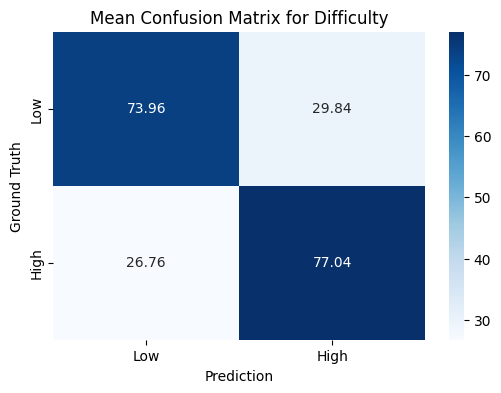

In [151]:
# (Diff) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [1, 2, 3, 5]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=random_state)
    X_diff_scaled_us, y_diff_us = undersampler.fit_resample(X_diff_scaled, y_diff)

    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = GradientBoostingClassifier(random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }    
    for train_idx, test_idx in outer_cv.split(X_diff_scaled_us, y_diff_us):
        X_train, X_test = X_diff_scaled_us.iloc[train_idx], X_diff_scaled_us.iloc[test_idx]
        y_train, y_test = y_diff_us.iloc[train_idx], y_diff_us.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Difficulty')
plt.show()

Average Performance across multiple runs:
Accuracy: 66.05%, (~1.53)
Precision: 65.92%, (~1.45)
Recall: 66.49%, (~2.23)
F1 Score: 66.11%, (~1.74)


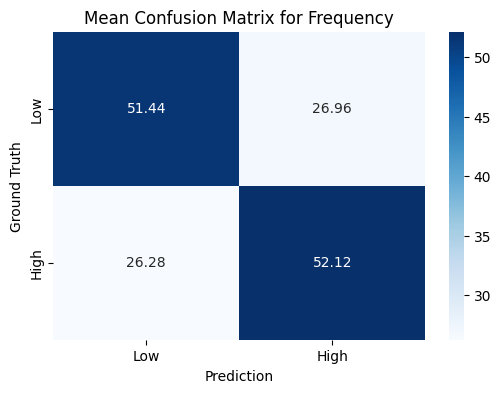

In [152]:
# (Freq) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [1, 2, 3, 5]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=random_state)
    X_freq_scaled_us, y_freq_us = undersampler.fit_resample(X_freq_scaled, y_freq)

    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = GradientBoostingClassifier(random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_freq_scaled_us, y_freq_us):
        X_train, X_test = X_freq_scaled_us.iloc[train_idx], X_freq_scaled_us.iloc[test_idx]
        y_train, y_test = y_freq_us.iloc[train_idx], y_freq_us.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Frequency')
plt.show()

##### Oversampled Participant-scaled GBM Classifier (Separated)

In [153]:
# Prepare Datasets
df_gbm4_diff = df_diff.copy().dropna()
df_gbm4_diff['difficulty'] = df_gbm4_diff['difficulty'].apply(lambda x: 0 if x == 'Easy' else 1)

df_gbm4_diff_scaled = df_gbm4_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)

X_diff_scaled = df_gbm4_diff_scaled.drop(columns=['difficulty'])
y_diff = df_gbm4_diff_scaled['difficulty']


df_gbm4_freq = df_freq.copy().dropna()
df_gbm4_freq['frequency'] = df_gbm4_freq['frequency'].apply(lambda x: 0 if x == 'Slow' else 1)

df_gbm4_freq_scaled = df_gbm4_freq.groupby('participant_id').apply(scale_by_participant_freq).reset_index(drop=True)

X_freq_scaled = df_gbm4_freq_scaled.drop(columns=['frequency'])
y_freq = df_gbm4_freq_scaled['frequency']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\2230702901.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_gbm4_diff_scaled = df_gbm4_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)
C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\2230702901.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_gbm4_freq_scaled = df_gbm4_freq.groupby('participant_id').a

In [154]:
# Classes (un)balance (NaN dropped)
print(f"Diff Low:\t{len(df_gbm4_diff_scaled.query("difficulty == 0"))}")
print(f"Diff High:\t{len(df_gbm4_diff_scaled.query("difficulty == 1"))}")

print()

print(f"Freq Low:\t{len(df_gbm4_freq_scaled.query("frequency == 0"))}")
print(f"Freq High:\t{len(df_gbm4_freq_scaled.query("frequency == 1"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


Average Performance across multiple runs:
Accuracy: 72.85%, (~0.93)
Precision: 69.14%, (~1.11)
Recall: 73.55%, (~1.41)
F1 Score: 71.16%, (~1.03)


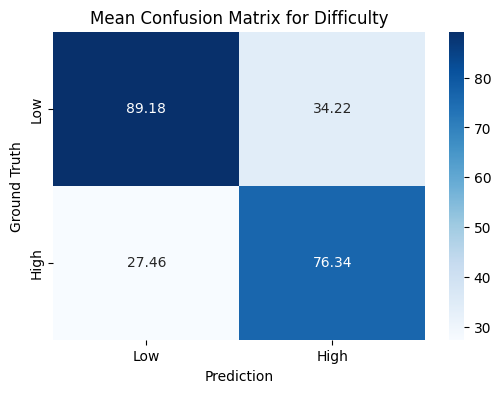

In [155]:
# (Diff) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [1, 2, 3, 5]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        ('model', GradientBoostingClassifier(random_state=random_state))
    ])
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }    
    for train_idx, test_idx in outer_cv.split(X_diff_scaled, y_diff):
        X_train, X_test = X_diff_scaled.iloc[train_idx], X_diff_scaled.iloc[test_idx]
        y_train, y_test = y_diff.iloc[train_idx], y_diff.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Difficulty')
plt.show()

Average Performance across multiple runs:
Accuracy: 67.58%, (~0.94)
Precision: 76.79%, (~1.26)
Recall: 72.60%, (~0.95)
F1 Score: 74.54%, (~0.59)


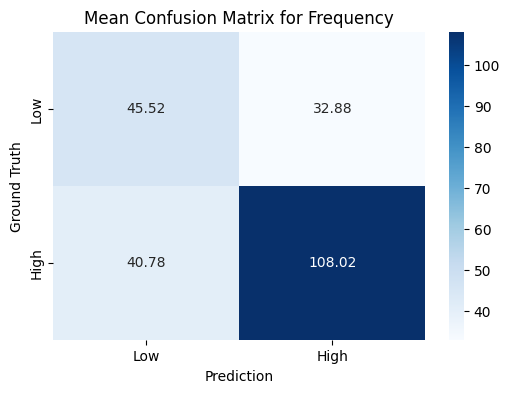

In [156]:
# (Freq) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [1, 2, 3, 5]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        ('model', GradientBoostingClassifier(random_state=random_state))
    ])
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_freq_scaled, y_freq):
        X_train, X_test = X_freq_scaled.iloc[train_idx], X_freq_scaled.iloc[test_idx]
        y_train, y_test = y_freq.iloc[train_idx], y_freq.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Frequency')
plt.show()

##### Participant-folded GBM (Separated)

In [14]:
# Prepare Datasets
df_gbm5_diff = df_diff.copy().dropna()
df_gbm5_diff['difficulty'] = df_gbm5_diff['difficulty'].apply(lambda x: 0 if x == 'Easy' else 1)
df_gbm5_diff_scaled = df_gbm5_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)
participants_ids_diff = df_gbm5_diff.reset_index(drop=True)['participant_id']

X_diff_scaled = df_gbm5_diff_scaled.drop(columns=['difficulty'])
y_diff = df_gbm5_diff_scaled['difficulty']


df_gbm5_freq = df_freq.copy().dropna()
df_gbm5_freq['frequency'] = df_gbm5_freq['frequency'].apply(lambda x: 0 if x == 'Slow' else 1)
df_gbm5_freq_scaled = df_gbm5_freq.groupby('participant_id').apply(scale_by_participant_freq).reset_index(drop=True)
participants_ids_freq = df_gbm5_freq.reset_index(drop=True)['participant_id']

X_freq_scaled = df_gbm5_freq_scaled.drop(columns=['frequency'])
y_freq = df_gbm5_freq_scaled['frequency']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_11692\952021336.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_gbm5_diff_scaled = df_gbm5_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)
C:\Users\vale_ad\AppData\Local\Temp\ipykernel_11692\952021336.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_gbm5_freq_scaled = df_gbm5_freq.groupby('participant_id').app

In [15]:
# Classes unbalance (NaN dropped)
print(f"Diff Low:\t{len(df_gbm5_diff_scaled.query("difficulty == 0"))}")
print(f"Diff High:\t{len(df_gbm5_diff_scaled.query("difficulty == 1"))}")

print()

print(f"Freq Low:\t{len(df_gbm5_freq_scaled.query("frequency == 0"))}")
print(f"Freq High:\t{len(df_gbm5_freq_scaled.query("frequency == 1"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


Average Performance across multiple runs:
Accuracy: 71.60%, (~0.55)
Precision: 69.02%, (~0.58)
Recall: 69.48%, (~0.73)
F1 Score: 68.95%, (~0.64)


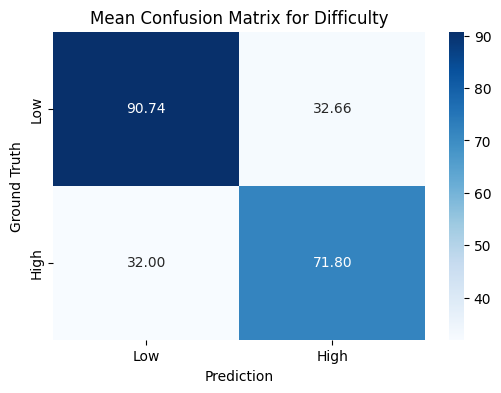

In [331]:
# (Diff) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [1, 2, 3, 5]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_diff_scaled, y_diff, participants_ids_diff, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)
    model = GradientBoostingClassifier(random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Difficulty')
plt.show()

In [332]:
outer_results['best_params']

[[{'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 200},
  {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100},
  {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 50},
  {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 100},
  {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 200}],
 [{'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 200},
  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100},
  {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 50},
  {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 100},
  {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 200}],
 [{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50},
  {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100},
  {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 50},
  {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 100},
  {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 200}],
 [{'learning_rate': 0.2, 'max_depth': 1, 'n_estimators':

Average Performance across multiple runs:
Accuracy: 69.49%, (~0.36)
Precision: 69.70%, (~0.42)
Recall: 94.70%, (~0.36)
F1 Score: 80.23%, (~0.14)


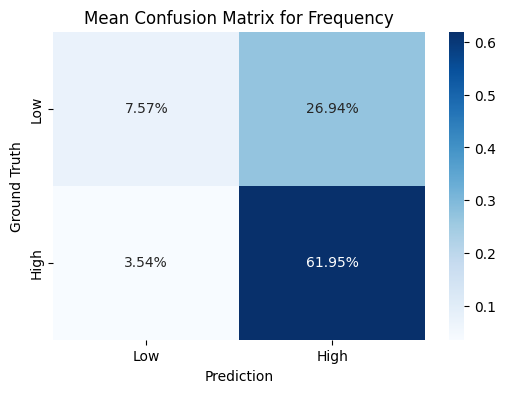

In [16]:
# (Freq) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [1, 2, 3, 5]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_freq_scaled, y_freq, participants_ids_freq, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)
    model = GradientBoostingClassifier(random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Frequency')
plt.show()

In [334]:
outer_results['best_params']

[[{'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 50},
  {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 100},
  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100},
  {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 100},
  {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 100}],
 [{'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 50},
  {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 100},
  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100},
  {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 100},
  {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 100}],
 [{'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 50},
  {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 100},
  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100},
  {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50},
  {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 100}],
 [{'learning_rate': 0.1, 'max_depth': 1, 'n_esti

##### Oversampled Participant-folded GBM Classifier (Separated)

In [335]:
# Prepare Datasets
df_gbm6_diff = df_diff.copy().dropna()
df_gbm6_diff['difficulty'] = df_gbm6_diff['difficulty'].apply(lambda x: 0 if x == 'Easy' else 1)
participants_ids_diff = df_gbm6_diff.reset_index(drop=True)['participant_id']

df_gbm6_diff_scaled = df_gbm6_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)

X_diff_scaled = df_gbm6_diff_scaled.drop(columns=['difficulty'])
X_diff_scaled_p = X_diff_scaled.copy()
X_diff_scaled_p['participant_id'] = participants_ids_diff
y_diff = df_gbm6_diff_scaled['difficulty']



df_gbm6_freq = df_freq.copy().dropna()
df_gbm6_freq['frequency'] = df_gbm6_freq['frequency'].apply(lambda x: 0 if x == 'Slow' else 1)
participants_ids_freq = df_gbm6_freq.reset_index(drop=True)['participant_id']

df_gbm6_freq_scaled = df_gbm6_freq.groupby('participant_id').apply(scale_by_participant_freq).reset_index(drop=True)

X_freq_scaled = df_gbm6_freq_scaled.drop(columns=['frequency'])
X_freq_scaled_p = X_freq_scaled.copy()
X_freq_scaled_p['participant_id'] = participants_ids_freq
y_freq = df_gbm6_freq_scaled['frequency']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\1247634656.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_gbm6_diff_scaled = df_gbm6_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)
C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\1247634656.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_gbm6_freq_scaled = df_gbm6_freq.groupby('participant_id').a

In [336]:
# Classes (un)balance (NaN dropped)
print(f"Diff Low:\t{len(df_gbm6_diff_scaled.query("difficulty == 0"))}")
print(f"Diff High:\t{len(df_gbm6_diff_scaled.query("difficulty == 1"))}")

print()

print(f"Freq Low:\t{len(df_gbm6_freq_scaled.query("frequency == 0"))}")
print(f"Freq High:\t{len(df_gbm6_freq_scaled.query("frequency == 1"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


Average Performance across multiple runs:
Accuracy: 71.60%, (~0.66)
Precision: 67.87%, (~0.68)
Recall: 72.69%, (~1.43)
F1 Score: 69.99%, (~0.84)


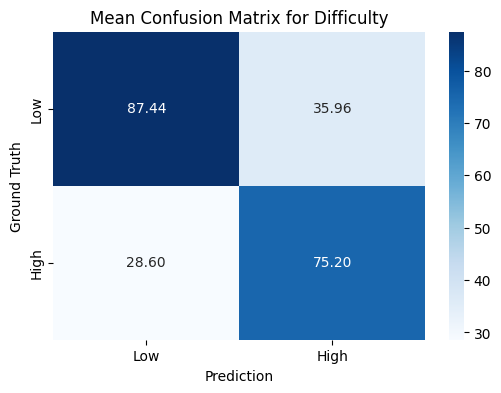

In [337]:
# (Diff) Group-folded nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [1, 2, 3, 5]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        ('model', GradientBoostingClassifier(random_state=random_state))
    ])
    participants_ids = X_diff_scaled_p['participant_id']
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_diff_scaled, y_diff, participants_ids_diff, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }    
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Difficulty')
plt.show()

In [338]:
outer_results['best_params']

[[{'model__learning_rate': 0.2,
   'model__max_depth': 1,
   'model__n_estimators': 200},
  {'model__learning_rate': 0.2,
   'model__max_depth': 1,
   'model__n_estimators': 50},
  {'model__learning_rate': 0.1,
   'model__max_depth': 2,
   'model__n_estimators': 100},
  {'model__learning_rate': 0.1,
   'model__max_depth': 5,
   'model__n_estimators': 100},
  {'model__learning_rate': 0.2,
   'model__max_depth': 1,
   'model__n_estimators': 200}],
 [{'model__learning_rate': 0.2,
   'model__max_depth': 2,
   'model__n_estimators': 100},
  {'model__learning_rate': 0.2,
   'model__max_depth': 5,
   'model__n_estimators': 100},
  {'model__learning_rate': 0.1,
   'model__max_depth': 5,
   'model__n_estimators': 50},
  {'model__learning_rate': 0.1,
   'model__max_depth': 5,
   'model__n_estimators': 50},
  {'model__learning_rate': 0.1,
   'model__max_depth': 3,
   'model__n_estimators': 100}],
 [{'model__learning_rate': 0.2,
   'model__max_depth': 3,
   'model__n_estimators': 200},
  {'model__

Average Performance across multiple runs:
Accuracy: 64.88%, (~1.21)
Precision: 75.88%, (~1.18)
Recall: 67.99%, (~1.58)
F1 Score: 71.61%, (~1.10)


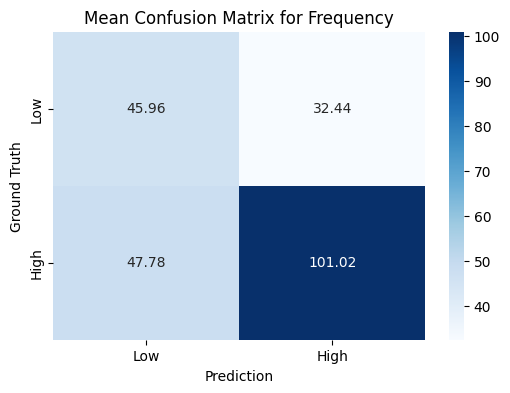

In [339]:
# (Freq) Group-folded nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [1, 2, 3, 5]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        ('model', GradientBoostingClassifier(random_state=random_state))
    ])
    participants_ids = X_freq_scaled_p['participant_id']
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_freq_scaled, y_freq, participants_ids_freq, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)
    
    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }    
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Frequency')
plt.show()

In [340]:
outer_results['best_params']

[[{'model__learning_rate': 0.1,
   'model__max_depth': 1,
   'model__n_estimators': 200},
  {'model__learning_rate': 0.1,
   'model__max_depth': 2,
   'model__n_estimators': 100},
  {'model__learning_rate': 0.2,
   'model__max_depth': 5,
   'model__n_estimators': 50},
  {'model__learning_rate': 0.01,
   'model__max_depth': 5,
   'model__n_estimators': 100},
  {'model__learning_rate': 0.1,
   'model__max_depth': 1,
   'model__n_estimators': 50}],
 [{'model__learning_rate': 0.1,
   'model__max_depth': 2,
   'model__n_estimators': 100},
  {'model__learning_rate': 0.2,
   'model__max_depth': 5,
   'model__n_estimators': 200},
  {'model__learning_rate': 0.2,
   'model__max_depth': 5,
   'model__n_estimators': 100},
  {'model__learning_rate': 0.1,
   'model__max_depth': 5,
   'model__n_estimators': 50},
  {'model__learning_rate': 0.1,
   'model__max_depth': 1,
   'model__n_estimators': 100}],
 [{'model__learning_rate': 0.2,
   'model__max_depth': 3,
   'model__n_estimators': 200},
  {'model_

##### Undersampled Participant-folded GBM Classifier (Separated)

In [341]:
# Prepare Datasets
df_gbm7_diff = df_diff.copy().dropna()
df_gbm7_diff['difficulty'] = df_gbm7_diff['difficulty'].apply(lambda x: 0 if x == 'Easy' else 1)
participants_ids_diff = df_gbm7_diff.reset_index(drop=True)['participant_id']

df_gbm7_diff_scaled = df_gbm7_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)

X_diff_scaled = df_gbm7_diff_scaled.drop(columns=['difficulty'])
X_diff_scaled_p = X_diff_scaled.copy()
X_diff_scaled_p['participant_id'] = participants_ids_diff
y_diff = df_gbm7_diff_scaled['difficulty']



df_gbm7_freq = df_freq.copy().dropna()
df_gbm7_freq['frequency'] = df_gbm7_freq['frequency'].apply(lambda x: 0 if x == 'Slow' else 1)
participants_ids_freq = df_gbm7_freq.reset_index(drop=True)['participant_id']

df_gbm7_freq_scaled = df_gbm7_freq.groupby('participant_id').apply(scale_by_participant_freq).reset_index(drop=True)

X_freq_scaled = df_gbm7_freq_scaled.drop(columns=['frequency'])
X_freq_scaled_p = X_freq_scaled.copy()
X_freq_scaled_p['participant_id'] = participants_ids_freq
y_freq = df_gbm7_freq_scaled['frequency']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\754889209.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_gbm7_diff_scaled = df_gbm7_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)
C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\754889209.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_gbm7_freq_scaled = df_gbm7_freq.groupby('participant_id').app

In [342]:
# Classes (un)balance (NaN dropped)
print(f"Diff Low:\t{len(df_gbm7_diff_scaled.query("difficulty == 0"))}")
print(f"Diff High:\t{len(df_gbm7_diff_scaled.query("difficulty == 1"))}")

print()

print(f"Freq Low:\t{len(df_gbm7_freq_scaled.query("frequency == 0"))}")
print(f"Freq High:\t{len(df_gbm7_freq_scaled.query("frequency == 1"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


Average Performance across multiple runs:
Accuracy: 71.13%, (~0.48)
Precision: 67.09%, (~0.51)
Recall: 72.90%, (~1.04)
F1 Score: 69.71%, (~0.60)


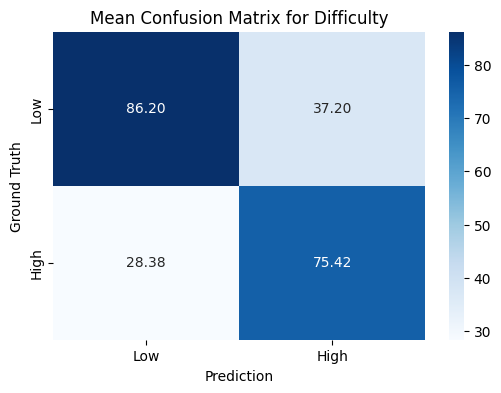

In [343]:
# (Diff) Group-folded nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [1, 2, 3, 5]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('undersample', RandomUnderSampler(sampling_strategy='auto', random_state=random_state)),
        ('model', GradientBoostingClassifier(random_state=random_state))
    ])
    participants_ids = X_diff_scaled_p['participant_id']
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_diff_scaled, y_diff, participants_ids_diff, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }    
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Difficulty')
plt.show()

In [344]:
outer_results['best_params']

[[{'model__learning_rate': 0.1,
   'model__max_depth': 2,
   'model__n_estimators': 200},
  {'model__learning_rate': 0.1,
   'model__max_depth': 3,
   'model__n_estimators': 200},
  {'model__learning_rate': 0.1,
   'model__max_depth': 3,
   'model__n_estimators': 50},
  {'model__learning_rate': 0.2,
   'model__max_depth': 1,
   'model__n_estimators': 100},
  {'model__learning_rate': 0.1,
   'model__max_depth': 2,
   'model__n_estimators': 200}],
 [{'model__learning_rate': 0.2,
   'model__max_depth': 5,
   'model__n_estimators': 50},
  {'model__learning_rate': 0.1,
   'model__max_depth': 2,
   'model__n_estimators': 50},
  {'model__learning_rate': 0.1,
   'model__max_depth': 3,
   'model__n_estimators': 50},
  {'model__learning_rate': 0.1,
   'model__max_depth': 3,
   'model__n_estimators': 50},
  {'model__learning_rate': 0.1,
   'model__max_depth': 3,
   'model__n_estimators': 100}],
 [{'model__learning_rate': 0.1,
   'model__max_depth': 3,
   'model__n_estimators': 100},
  {'model__le

Average Performance across multiple runs:
Accuracy: 64.49%, (~0.79)
Precision: 77.10%, (~0.56)
Recall: 64.99%, (~1.32)
F1 Score: 70.42%, (~0.84)


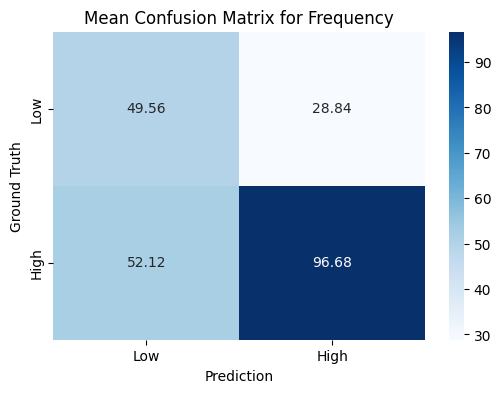

In [345]:
# (Freq) Group-folded nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [1, 2, 3, 5]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('undersample', RandomUnderSampler(sampling_strategy='auto', random_state=random_state)),
        ('model', GradientBoostingClassifier(random_state=random_state))
    ])
    participants_ids = X_freq_scaled_p['participant_id']
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_freq_scaled, y_freq, participants_ids_freq, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)
    
    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }    
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Frequency')
plt.show()

In [346]:
outer_results['best_params']

[[{'model__learning_rate': 0.2,
   'model__max_depth': 1,
   'model__n_estimators': 50},
  {'model__learning_rate': 0.2,
   'model__max_depth': 2,
   'model__n_estimators': 100},
  {'model__learning_rate': 0.1,
   'model__max_depth': 1,
   'model__n_estimators': 200},
  {'model__learning_rate': 0.01,
   'model__max_depth': 3,
   'model__n_estimators': 100},
  {'model__learning_rate': 0.2,
   'model__max_depth': 1,
   'model__n_estimators': 100}],
 [{'model__learning_rate': 0.2,
   'model__max_depth': 1,
   'model__n_estimators': 100},
  {'model__learning_rate': 0.1,
   'model__max_depth': 2,
   'model__n_estimators': 100},
  {'model__learning_rate': 0.1,
   'model__max_depth': 1,
   'model__n_estimators': 100},
  {'model__learning_rate': 0.1,
   'model__max_depth': 2,
   'model__n_estimators': 50},
  {'model__learning_rate': 0.2,
   'model__max_depth': 1,
   'model__n_estimators': 100}],
 [{'model__learning_rate': 0.1,
   'model__max_depth': 1,
   'model__n_estimators': 200},
  {'model

##### Participant-folded GBM (MultiClass)

In [34]:
# Prepare Dataset
df_gbm9 = df.copy().dropna()
df_gbm9_scaled = df_gbm9.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)
participants_ids = df_gbm9.reset_index(drop=True)['participant_id']

X_scaled = df_gbm9_scaled.drop(columns=['condition'])
X_scaled_p = X_scaled.copy()
X_scaled_p['participant_id'] = participants_ids
y = df_gbm9_scaled['condition']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_17796\2977117175.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_gbm9_scaled = df_gbm9.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [35]:
# Classes unbalance (NaN dropped)
print(f"Diff Low:\t{len(df_gbm9_scaled.query("condition == 'Easy_Slow' | condition == 'Easy_Fast'"))}")
print(f"Diff High:\t{len(df_gbm9_scaled.query("condition == 'Hard_Slow' | condition == 'Hard_Fast'"))}")

print()

print(f"Freq Low:\t{len(df_gbm9_scaled.query("condition == 'Easy_Slow' | condition == 'Hard_Slow'"))}")
print(f"Freq High:\t{len(df_gbm9_scaled.query("condition == 'Easy_Fast' | condition == 'Hard_Fast'"))}")

print()
print()

print(f"Easy Slow:\t{len(df_gbm9_scaled.query("condition == 'Easy_Slow'"))}")
print(f"Easy Fast:\t{len(df_gbm9_scaled.query("condition == 'Easy_Fast'"))}")
print(f"Hard Slow:\t{len(df_gbm9_scaled.query("condition == 'Hard_Slow'"))}")
print(f"Hard Fast:\t{len(df_gbm9_scaled.query("condition == 'Hard_Fast'"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


Easy Slow:	205
Easy Fast:	412
Hard Slow:	187
Hard Fast:	332


Average Performance across multiple runs:
Accuracy: 47.01%, (~0.40)
Precision: 44.17%, (~0.74)
Recall: 42.37%, (~0.51)
F1 Score: 42.39%, (~0.63)


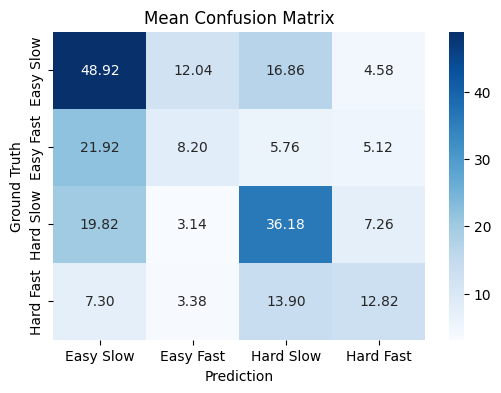

In [36]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [1, 2, 3, 5]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        # ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        # ('undersample', RandomUnderSampler(sampling_strategy='auto', random_state=random_state)),
        ('model', GradientBoostingClassifier(random_state=random_state))
    ])
    participants_ids = X_scaled_p['participant_id']
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_scaled, y, participants_ids, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='recall_macro', refit='recall_macro', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred, average='macro', zero_division=0))
        inner_results['recall'].append(recall_score(y_test, y_pred, average='macro'))
        inner_results['f1'].append(f1_score(y_test, y_pred, average='macro'))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred, labels=class_order))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

In [37]:
outer_results['best_params']

[[{'model__learning_rate': 0.1,
   'model__max_depth': 3,
   'model__n_estimators': 100},
  {'model__learning_rate': 0.2,
   'model__max_depth': 2,
   'model__n_estimators': 200},
  {'model__learning_rate': 0.1,
   'model__max_depth': 5,
   'model__n_estimators': 100},
  {'model__learning_rate': 0.1,
   'model__max_depth': 3,
   'model__n_estimators': 100},
  {'model__learning_rate': 0.1,
   'model__max_depth': 5,
   'model__n_estimators': 50}],
 [{'model__learning_rate': 0.2,
   'model__max_depth': 3,
   'model__n_estimators': 100},
  {'model__learning_rate': 0.2,
   'model__max_depth': 2,
   'model__n_estimators': 200},
  {'model__learning_rate': 0.1,
   'model__max_depth': 2,
   'model__n_estimators': 200},
  {'model__learning_rate': 0.1,
   'model__max_depth': 3,
   'model__n_estimators': 100},
  {'model__learning_rate': 0.2,
   'model__max_depth': 1,
   'model__n_estimators': 200}],
 [{'model__learning_rate': 0.1,
   'model__max_depth': 3,
   'model__n_estimators': 100},
  {'model

##### Oversampled Participant-folded GBM (MultiClass)

In [38]:
# Prepare Dataset
df_gbm9 = df.copy().dropna()
df_gbm9_scaled = df_gbm9.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)
participants_ids = df_gbm9.reset_index(drop=True)['participant_id']

X_scaled = df_gbm9_scaled.drop(columns=['condition'])
X_scaled_p = X_scaled.copy()
X_scaled_p['participant_id'] = participants_ids
y = df_gbm9_scaled['condition']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_17796\2977117175.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_gbm9_scaled = df_gbm9.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [39]:
# Classes unbalance (NaN dropped)
print(f"Diff Low:\t{len(df_gbm9_scaled.query("condition == 'Easy_Slow' | condition == 'Easy_Fast'"))}")
print(f"Diff High:\t{len(df_gbm9_scaled.query("condition == 'Hard_Slow' | condition == 'Hard_Fast'"))}")

print()

print(f"Freq Low:\t{len(df_gbm9_scaled.query("condition == 'Easy_Slow' | condition == 'Hard_Slow'"))}")
print(f"Freq High:\t{len(df_gbm9_scaled.query("condition == 'Easy_Fast' | condition == 'Hard_Fast'"))}")

print()
print()

print(f"Easy Slow:\t{len(df_gbm9_scaled.query("condition == 'Easy_Slow'"))}")
print(f"Easy Fast:\t{len(df_gbm9_scaled.query("condition == 'Easy_Fast'"))}")
print(f"Hard Slow:\t{len(df_gbm9_scaled.query("condition == 'Hard_Slow'"))}")
print(f"Hard Fast:\t{len(df_gbm9_scaled.query("condition == 'Hard_Fast'"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


Easy Slow:	205
Easy Fast:	412
Hard Slow:	187
Hard Fast:	332


Average Performance across multiple runs:
Accuracy: 46.55%, (~1.11)
Precision: 45.35%, (~1.21)
Recall: 46.13%, (~1.30)
F1 Score: 45.16%, (~1.19)


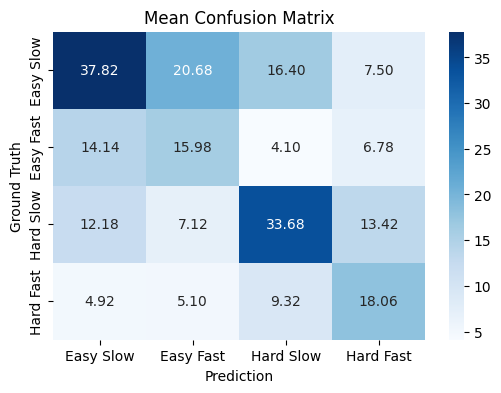

In [40]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [1, 2, 3, 5]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        # ('undersample', RandomUnderSampler(sampling_strategy='auto', random_state=random_state)),
        ('model', GradientBoostingClassifier(random_state=random_state))
    ])
    participants_ids = X_scaled_p['participant_id']
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_scaled, y, participants_ids, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='recall_macro', refit='recall_macro', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred, average='macro', zero_division=0))
        inner_results['recall'].append(recall_score(y_test, y_pred, average='macro'))
        inner_results['f1'].append(f1_score(y_test, y_pred, average='macro'))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred, labels=class_order))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

In [41]:
outer_results['best_params']

[[{'model__learning_rate': 0.1,
   'model__max_depth': 2,
   'model__n_estimators': 200},
  {'model__learning_rate': 0.1,
   'model__max_depth': 2,
   'model__n_estimators': 200},
  {'model__learning_rate': 0.1,
   'model__max_depth': 3,
   'model__n_estimators': 100},
  {'model__learning_rate': 0.1,
   'model__max_depth': 1,
   'model__n_estimators': 100},
  {'model__learning_rate': 0.2,
   'model__max_depth': 1,
   'model__n_estimators': 200}],
 [{'model__learning_rate': 0.1,
   'model__max_depth': 2,
   'model__n_estimators': 200},
  {'model__learning_rate': 0.1,
   'model__max_depth': 5,
   'model__n_estimators': 200},
  {'model__learning_rate': 0.2,
   'model__max_depth': 2,
   'model__n_estimators': 50},
  {'model__learning_rate': 0.1,
   'model__max_depth': 1,
   'model__n_estimators': 100},
  {'model__learning_rate': 0.2,
   'model__max_depth': 1,
   'model__n_estimators': 200}],
 [{'model__learning_rate': 0.1,
   'model__max_depth': 2,
   'model__n_estimators': 100},
  {'model

##### Undersampled Participant-folded GBM (MultiClass)

In [42]:
# Prepare Dataset
df_gbm9 = df.copy().dropna()
df_gbm9_scaled = df_gbm9.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)
participants_ids = df_gbm9.reset_index(drop=True)['participant_id']

X_scaled = df_gbm9_scaled.drop(columns=['condition'])
X_scaled_p = X_scaled.copy()
X_scaled_p['participant_id'] = participants_ids
y = df_gbm9_scaled['condition']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_17796\2977117175.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_gbm9_scaled = df_gbm9.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [43]:
# Classes unbalance (NaN dropped)
print(f"Diff Low:\t{len(df_gbm9_scaled.query("condition == 'Easy_Slow' | condition == 'Easy_Fast'"))}")
print(f"Diff High:\t{len(df_gbm9_scaled.query("condition == 'Hard_Slow' | condition == 'Hard_Fast'"))}")

print()

print(f"Freq Low:\t{len(df_gbm9_scaled.query("condition == 'Easy_Slow' | condition == 'Hard_Slow'"))}")
print(f"Freq High:\t{len(df_gbm9_scaled.query("condition == 'Easy_Fast' | condition == 'Hard_Fast'"))}")

print()
print()

print(f"Easy Slow:\t{len(df_gbm9_scaled.query("condition == 'Easy_Slow'"))}")
print(f"Easy Fast:\t{len(df_gbm9_scaled.query("condition == 'Easy_Fast'"))}")
print(f"Hard Slow:\t{len(df_gbm9_scaled.query("condition == 'Hard_Slow'"))}")
print(f"Hard Fast:\t{len(df_gbm9_scaled.query("condition == 'Hard_Fast'"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


Easy Slow:	205
Easy Fast:	412
Hard Slow:	187
Hard Fast:	332


Average Performance across multiple runs:
Accuracy: 44.08%, (~1.08)
Precision: 43.37%, (~1.20)
Recall: 44.38%, (~1.13)
F1 Score: 43.07%, (~1.17)


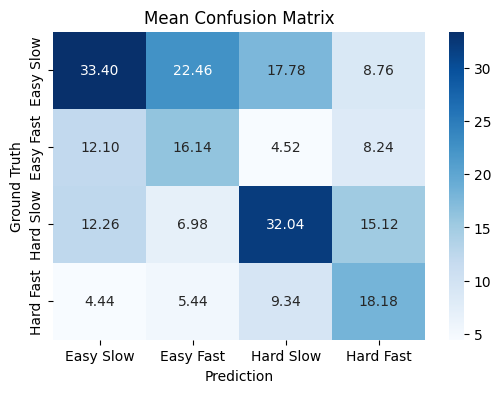

In [44]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [1, 2, 3, 5]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        # ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        ('undersample', RandomUnderSampler(sampling_strategy='auto', random_state=random_state)),
        ('model', GradientBoostingClassifier(random_state=random_state))
    ])
    participants_ids = X_scaled_p['participant_id']
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_scaled, y, participants_ids, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='recall_macro', refit='recall_macro', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred, average='macro', zero_division=0))
        inner_results['recall'].append(recall_score(y_test, y_pred, average='macro'))
        inner_results['f1'].append(f1_score(y_test, y_pred, average='macro'))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred, labels=class_order))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

In [45]:
outer_results['best_params']

[[{'model__learning_rate': 0.1,
   'model__max_depth': 3,
   'model__n_estimators': 200},
  {'model__learning_rate': 0.1,
   'model__max_depth': 2,
   'model__n_estimators': 100},
  {'model__learning_rate': 0.2,
   'model__max_depth': 5,
   'model__n_estimators': 50},
  {'model__learning_rate': 0.1,
   'model__max_depth': 5,
   'model__n_estimators': 50},
  {'model__learning_rate': 0.2,
   'model__max_depth': 3,
   'model__n_estimators': 50}],
 [{'model__learning_rate': 0.2,
   'model__max_depth': 2,
   'model__n_estimators': 100},
  {'model__learning_rate': 0.1,
   'model__max_depth': 5,
   'model__n_estimators': 100},
  {'model__learning_rate': 0.1,
   'model__max_depth': 1,
   'model__n_estimators': 200},
  {'model__learning_rate': 0.1,
   'model__max_depth': 3,
   'model__n_estimators': 50},
  {'model__learning_rate': 0.2,
   'model__max_depth': 5,
   'model__n_estimators': 100}],
 [{'model__learning_rate': 0.2,
   'model__max_depth': 3,
   'model__n_estimators': 200},
  {'model__l

### 5. Extreme Gradient Boosting Classifier

##### Basic XGB (MultiClass)

In [175]:
# Prepare Dataset
df_xgb1 = df.copy()
df_xgb1 = df_xgb1.drop(columns=['participant_id']).dropna()
label_mapping = {'Easy_Slow': 0, 'Easy_Fast': 1, 'Hard_Slow': 2, 'Hard_Fast': 3}

X = df_xgb1.drop(columns=['condition', 'difficulty', 'frequency'])
y = df_xgb1['condition'].map(label_mapping)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

df_xgb1_scaled = pd.concat([X_scaled, y.reset_index(drop=True)], axis=1)

In [176]:
# Classes unbalance (NaN dropped)
print(f"Diff Low:\t{len(df_xgb1_scaled.query("condition == 0 | condition == 1"))}")
print(f"Diff High:\t{len(df_xgb1_scaled.query("condition == 2 | condition == 3"))}")

print()

print(f"Freq Low:\t{len(df_xgb1_scaled.query("condition == 0 | condition == 2"))}")
print(f"Freq High:\t{len(df_xgb1_scaled.query("condition == 1 | condition == 3"))}")

print()
print()

print(f"Easy Slow:\t{len(df_xgb1_scaled.query("condition == 0"))}")
print(f"Easy Fast:\t{len(df_xgb1_scaled.query("condition == 1"))}")
print(f"Hard Slow:\t{len(df_xgb1_scaled.query("condition == 2"))}")
print(f"Hard Fast:\t{len(df_xgb1_scaled.query("condition == 3"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


Easy Slow:	205
Easy Fast:	412
Hard Slow:	187
Hard Fast:	332


c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Average Performance across multiple runs:
Accuracy: 48.10%, (~0.67)
Precision: 46.25%, (~1.09)
Recall: 44.18%, (~0.90)
F1 Score: 44.56%, (~1.01)


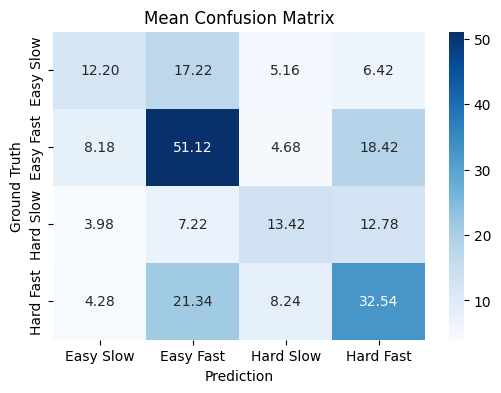

In [177]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [1, 2, 3, 5, 10],
    'gamma': [0, 0.1, 0.2],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = XGBClassifier(objective='multi:softmax', random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_scaled, y):
        X_train, X_test = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1_macro', refit='f1_macro', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred, average='macro'))
        inner_results['recall'].append(recall_score(y_test, y_pred, average='macro'))
        inner_results['f1'].append(f1_score(y_test, y_pred, average='macro'))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

##### Participant-scaled XGB (MultiClass)

In [178]:
# Prepare Dataset
df_xgb2 = df.copy().dropna()
df_xgb2_scaled = df_xgb2.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)
label_mapping = {'Easy_Slow': 0, 'Easy_Fast': 1, 'Hard_Slow': 2, 'Hard_Fast': 3}

X_scaled = df_xgb2_scaled.drop(columns=['condition'])
y = df_xgb2_scaled['condition'].map(label_mapping)

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\3636635618.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_xgb2_scaled = df_xgb2.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [179]:
# Classes unbalance (NaN dropped)
print(f"Diff Low:\t{len(df_xgb2_scaled.query("condition == 0 | condition == 1"))}")
print(f"Diff High:\t{len(df_xgb2_scaled.query("condition == 2 | condition == 3"))}")

print()

print(f"Freq Low:\t{len(df_xgb2_scaled.query("condition == 0 | condition == 2"))}")
print(f"Freq High:\t{len(df_xgb2_scaled.query("condition == 1 | condition == 3"))}")

print()
print()

print(f"Easy Slow:\t{len(df_xgb2_scaled.query("condition == 0"))}")
print(f"Easy Fast:\t{len(df_xgb2_scaled.query("condition == 1"))}")
print(f"Hard Slow:\t{len(df_xgb2_scaled.query("condition == 2"))}")
print(f"Hard Fast:\t{len(df_xgb2_scaled.query("condition == 3"))}")

Diff Low:	0
Diff High:	0

Freq Low:	0
Freq High:	0


Easy Slow:	0
Easy Fast:	0
Hard Slow:	0
Hard Fast:	0


Average Performance across multiple runs:
Accuracy: 50.94%, (~0.69)
Precision: 48.75%, (~0.71)
Recall: 46.38%, (~0.72)
F1 Score: 46.65%, (~0.79)


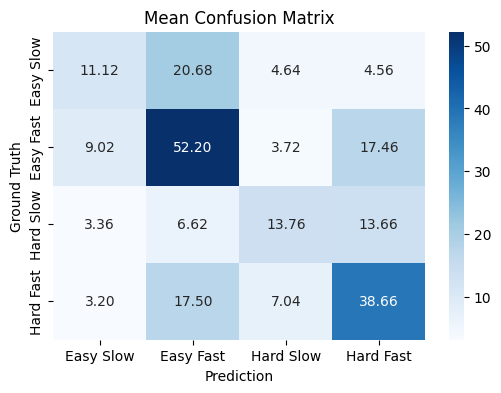

In [180]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [1, 2, 3, 5, 10],
    'gamma': [0, 0.1, 0.2],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = XGBClassifier(objective='multi:softmax', random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_scaled, y):
        X_train, X_test = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1_macro', refit='f1_macro', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred, average='macro'))
        inner_results['recall'].append(recall_score(y_test, y_pred, average='macro'))
        inner_results['f1'].append(f1_score(y_test, y_pred, average='macro'))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

##### Basic XGB (Separated)

In [181]:
# Prepare Datasets
df_xgb1_diff = df_diff.copy()
df_xgb1_diff = df_xgb1_diff.drop(columns=['participant_id'])#.dropna()
df_xgb1_diff['difficulty'] = df_xgb1_diff['difficulty'].apply(lambda x: 0 if x == 'Easy' else 1)

X_diff = df_xgb1_diff.drop(columns=['difficulty'])
y_diff = df_xgb1_diff['difficulty']

scaler = StandardScaler()
X_diff_scaled = scaler.fit_transform(X_diff)
X_diff_scaled = pd.DataFrame(X_diff_scaled, columns=X_diff.columns)

df_xgb1_diff_scaled = pd.concat([X_diff_scaled, y_diff.reset_index(drop=True)], axis=1)


df_xgb1_freq = df_freq.copy()
df_xgb1_freq = df_xgb1_freq.drop(columns=['participant_id'])#.dropna()
df_xgb1_freq['frequency'] = df_xgb1_freq['frequency'].apply(lambda x: 0 if x == 'Slow' else 1)

X_freq = df_xgb1_freq.drop(columns=['frequency'])
y_freq = df_xgb1_freq['frequency']

scaler = StandardScaler()
X_freq_scaled = scaler.fit_transform(X_freq)
X_freq_scaled = pd.DataFrame(X_freq_scaled, columns=X_freq.columns)

df_xgb1_freq_scaled = pd.concat([X_freq_scaled, y_freq.reset_index(drop=True)], axis=1)

In [182]:
# Classes unbalance
print(f"Diff Low:\t{len(df_xgb1_diff_scaled.query("difficulty == 0"))}")
print(f"Diff High:\t{len(df_xgb1_diff_scaled.query("difficulty == 1"))}")

print()

print(f"Freq Low:\t{len(df_xgb1_freq_scaled.query("frequency == 0"))}")
print(f"Freq High:\t{len(df_xgb1_freq_scaled.query("frequency == 1"))}")

Diff Low:	709
Diff High:	540

Freq Low:	432
Freq High:	817


Average Performance across multiple runs:
Accuracy: 71.33%, (~0.48)
Precision: 65.73%, (~0.43)
Recall: 70.81%, (~1.19)
F1 Score: 68.10%, (~0.69)


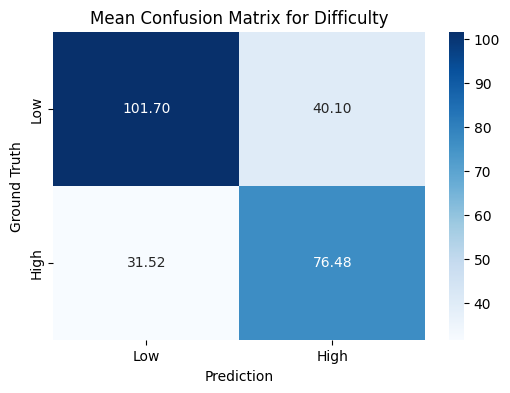

In [183]:
# (Diff) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [1, 2, 3, 5, 10],
    'gamma': [0, 0.1, 0.2],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = XGBClassifier(eval_metric='logloss', scale_pos_weight=(709/540), random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_diff_scaled, y_diff):
        X_train, X_test = X_diff_scaled.iloc[train_idx], X_diff_scaled.iloc[test_idx]
        y_train, y_test = y_diff.iloc[train_idx], y_diff.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Difficulty')
plt.show()

Average Performance across multiple runs:
Accuracy: 69.56%, (~1.04)
Precision: 75.71%, (~0.55)
Recall: 78.77%, (~1.43)
F1 Score: 77.17%, (~0.93)


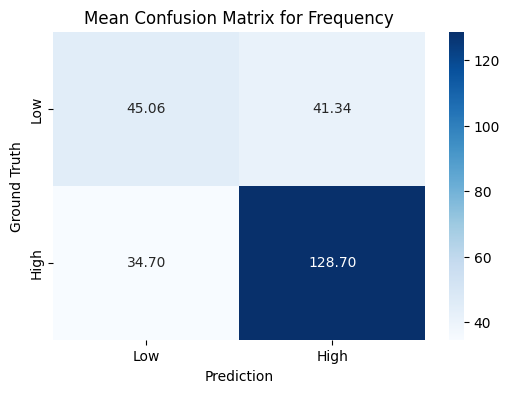

In [184]:
# (Freq) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [1, 2, 3, 5, 10],
    'gamma': [0, 0.1, 0.2],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = XGBClassifier(eval_metric='logloss', scale_pos_weight=(432/817), random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_freq_scaled, y_freq):
        X_train, X_test = X_freq_scaled.iloc[train_idx], X_freq_scaled.iloc[test_idx]
        y_train, y_test = y_freq.iloc[train_idx], y_freq.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Frequency')
plt.show()

##### Participant-scaled XGB (Separated)

In [185]:
# Prepare Datasets
df_xgb2_diff = df_diff.copy()#.dropna()
df_xgb2_diff['difficulty'] = df_xgb2_diff['difficulty'].apply(lambda x: 0 if x == 'Easy' else 1)
df_xgb2_diff_scaled = df_xgb2_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)

X_diff_scaled = df_xgb2_diff_scaled.drop(columns=['difficulty'])
y_diff = df_xgb2_diff_scaled['difficulty']


df_xgb2_freq = df_freq.copy()#.dropna()
df_xgb2_freq['frequency'] = df_xgb2_freq['frequency'].apply(lambda x: 0 if x == 'Slow' else 1)
df_xgb2_freq_scaled = df_xgb2_freq.groupby('participant_id').apply(scale_by_participant_freq).reset_index(drop=True)

X_freq_scaled = df_xgb2_freq_scaled.drop(columns=['frequency'])
y_freq = df_xgb2_freq_scaled['frequency']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\4226377892.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_xgb2_diff_scaled = df_xgb2_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)
C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\4226377892.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_xgb2_freq_scaled = df_xgb2_freq.groupby('participant_id').a

In [186]:
# Classes unbalance
print(f"Diff Low:\t{len(df_xgb2_diff_scaled.query("difficulty == 0"))}")
print(f"Diff High:\t{len(df_xgb2_diff_scaled.query("difficulty == 1"))}")

print()

print(f"Freq Low:\t{len(df_xgb2_freq_scaled.query("frequency == 0"))}")
print(f"Freq High:\t{len(df_xgb2_freq_scaled.query("frequency == 1"))}")

Diff Low:	709
Diff High:	540

Freq Low:	432
Freq High:	817


Average Performance across multiple runs:
Accuracy: 73.35%, (~0.47)
Precision: 67.49%, (~0.52)
Recall: 74.22%, (~1.34)
F1 Score: 70.63%, (~0.70)


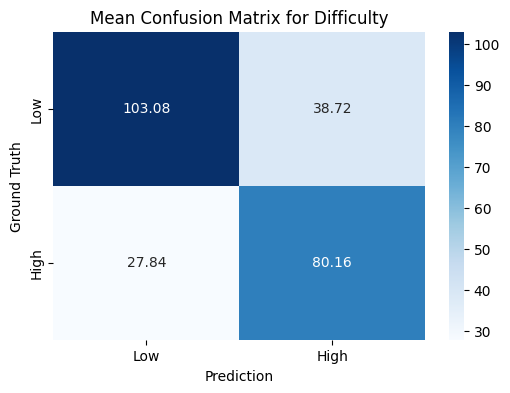

In [187]:
# (Diff) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [1, 2, 3, 5, 10],
    'gamma': [0, 0.1, 0.2],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = XGBClassifier(eval_metric='logloss', scale_pos_weight=(709/540), random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_diff_scaled, y_diff):
        X_train, X_test = X_diff_scaled.iloc[train_idx], X_diff_scaled.iloc[test_idx]
        y_train, y_test = y_diff.iloc[train_idx], y_diff.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Difficulty')
plt.show()

Average Performance across multiple runs:
Accuracy: 69.22%, (~1.07)
Precision: 74.93%, (~0.76)
Recall: 79.66%, (~1.05)
F1 Score: 77.18%, (~0.80)


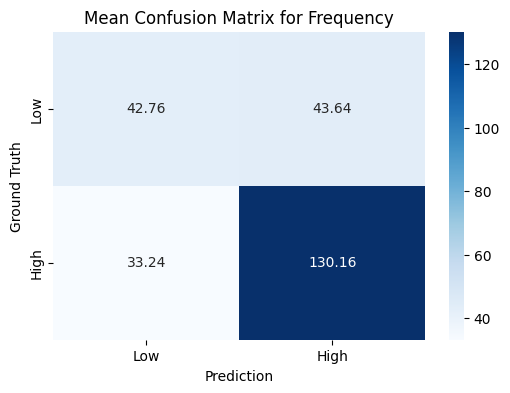

In [188]:
# (Freq) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [1, 2, 3, 5, 10],
    'gamma': [0, 0.1, 0.2],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = XGBClassifier(eval_metric='logloss', scale_pos_weight=(432/817), random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_freq_scaled, y_freq):
        X_train, X_test = X_freq_scaled.iloc[train_idx], X_freq_scaled.iloc[test_idx]
        y_train, y_test = y_freq.iloc[train_idx], y_freq.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Frequency')
plt.show()

##### Undersampled Participant-scaled XGB Classifier (Separated)

In [189]:
# Prepare Datasets
df_xgb3_diff = df_diff.copy()#.dropna()
df_xgb3_diff['difficulty'] = df_xgb3_diff['difficulty'].apply(lambda x: 0 if x == 'Easy' else 1)

df_xgb3_diff_scaled = df_xgb3_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)

X_diff_scaled = df_xgb3_diff_scaled.drop(columns=['difficulty'])
y_diff = df_xgb3_diff_scaled['difficulty']


df_xgb3_freq = df_freq.copy()#.dropna()
df_xgb3_freq['frequency'] = df_xgb3_freq['frequency'].apply(lambda x: 0 if x == 'Slow' else 1)

df_xgb3_freq_scaled = df_xgb3_freq.groupby('participant_id').apply(scale_by_participant_freq).reset_index(drop=True)

X_freq_scaled = df_xgb3_freq_scaled.drop(columns=['frequency'])
y_freq = df_xgb3_freq_scaled['frequency']

undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=random_state)
X_diff_scaled_us, y_diff_us = undersampler.fit_resample(X_diff_scaled, y_diff)
X_freq_scaled_us, y_freq_us = undersampler.fit_resample(X_freq_scaled, y_freq)

df_xgb3_diff_scaled_us = X_diff_scaled_us.join(y_diff_us)
df_xgb3_freq_scaled_us = X_freq_scaled_us.join(y_freq_us)

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\2296932948.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_xgb3_diff_scaled = df_xgb3_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)
C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\2296932948.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_xgb3_freq_scaled = df_xgb3_freq.groupby('participant_id').a

In [190]:
# Classes (un)balance
print(f"Diff Low:\t{len(df_xgb3_diff_scaled_us.query("difficulty == 0"))}")
print(f"Diff High:\t{len(df_xgb3_diff_scaled_us.query("difficulty == 1"))}")

print()

print(f"Freq Low:\t{len(df_xgb3_freq_scaled_us.query("frequency == 0"))}")
print(f"Freq High:\t{len(df_xgb3_freq_scaled_us.query("frequency == 1"))}")

Diff Low:	540
Diff High:	540

Freq Low:	432
Freq High:	432


Average Performance across multiple runs:
Accuracy: 73.55%, (~1.25)
Precision: 72.96%, (~1.31)
Recall: 75.09%, (~1.46)
F1 Score: 73.93%, (~1.24)


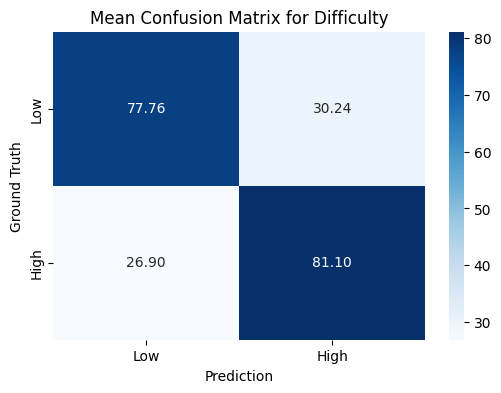

In [191]:
# (Diff) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [1, 2, 3, 5, 10],
    'gamma': [0, 0.1, 0.2],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=random_state)
    X_diff_scaled_us, y_diff_us = undersampler.fit_resample(X_diff_scaled, y_diff)

    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = XGBClassifier(eval_metric='logloss', random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }    
    for train_idx, test_idx in outer_cv.split(X_diff_scaled_us, y_diff_us):
        X_train, X_test = X_diff_scaled_us.iloc[train_idx], X_diff_scaled_us.iloc[test_idx]
        y_train, y_test = y_diff_us.iloc[train_idx], y_diff_us.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Difficulty')
plt.show()

Average Performance across multiple runs:
Accuracy: 66.16%, (~1.39)
Precision: 65.85%, (~1.14)
Recall: 67.48%, (~2.32)
F1 Score: 66.52%, (~1.66)


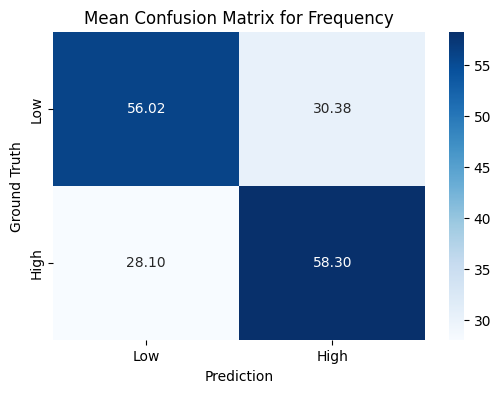

In [192]:
# (Freq) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [1, 2, 3, 5, 10],
    'gamma': [0, 0.1, 0.2],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=random_state)
    X_freq_scaled_us, y_freq_us = undersampler.fit_resample(X_freq_scaled, y_freq)

    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = XGBClassifier(eval_metric='logloss', random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_freq_scaled_us, y_freq_us):
        X_train, X_test = X_freq_scaled_us.iloc[train_idx], X_freq_scaled_us.iloc[test_idx]
        y_train, y_test = y_freq_us.iloc[train_idx], y_freq_us.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Frequency')
plt.show()

##### Oversampled Participant-scaled XGB Classifier (Separated)

In [193]:
# Prepare Datasets
df_xgb4_diff = df_diff.copy().dropna()
df_xgb4_diff['difficulty'] = df_xgb4_diff['difficulty'].apply(lambda x: 0 if x == 'Easy' else 1)

df_xgb4_diff_scaled = df_xgb4_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)

X_diff_scaled = df_xgb4_diff_scaled.drop(columns=['difficulty'])
y_diff = df_xgb4_diff_scaled['difficulty']


df_xgb4_freq = df_freq.copy().dropna()
df_xgb4_freq['frequency'] = df_xgb4_freq['frequency'].apply(lambda x: 0 if x == 'Slow' else 1)

df_xgb4_freq_scaled = df_xgb4_freq.groupby('participant_id').apply(scale_by_participant_freq).reset_index(drop=True)

X_freq_scaled = df_xgb4_freq_scaled.drop(columns=['frequency'])
y_freq = df_xgb4_freq_scaled['frequency']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\2814922293.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_xgb4_diff_scaled = df_xgb4_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)
C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\2814922293.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_xgb4_freq_scaled = df_xgb4_freq.groupby('participant_id').a

In [194]:
# Classes (un)balance (NaN dropped)
print(f"Diff Low:\t{len(df_xgb4_diff_scaled.query("difficulty == 0"))}")
print(f"Diff High:\t{len(df_xgb4_diff_scaled.query("difficulty == 1"))}")

print()

print(f"Freq Low:\t{len(df_xgb4_freq_scaled.query("frequency == 0"))}")
print(f"Freq High:\t{len(df_xgb4_freq_scaled.query("frequency == 1"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


Average Performance across multiple runs:
Accuracy: 73.26%, (~0.65)
Precision: 69.89%, (~0.85)
Recall: 73.12%, (~1.47)
F1 Score: 71.36%, (~0.78)


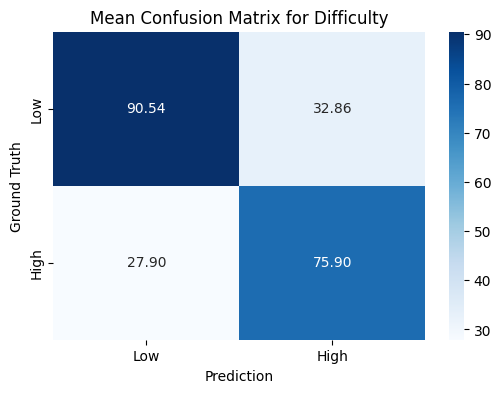

In [195]:
# (Diff) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [1, 2, 3, 5, 10],
    'model__gamma': [0, 0.1, 0.2],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        ('model', XGBClassifier(eval_metric='logloss', random_state=random_state))
    ])
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }    
    for train_idx, test_idx in outer_cv.split(X_diff_scaled, y_diff):
        X_train, X_test = X_diff_scaled.iloc[train_idx], X_diff_scaled.iloc[test_idx]
        y_train, y_test = y_diff.iloc[train_idx], y_diff.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Difficulty')
plt.show()

Average Performance across multiple runs:
Accuracy: 68.03%, (~0.90)
Precision: 75.85%, (~0.72)
Recall: 75.19%, (~1.21)
F1 Score: 75.46%, (~0.77)


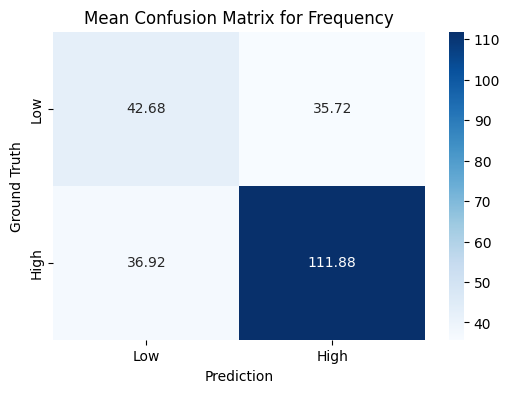

In [196]:
# (Freq) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [1, 2, 3, 5, 10],
    'model__gamma': [0, 0.1, 0.2],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        ('model', XGBClassifier(eval_metric='logloss', random_state=random_state))
    ])
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_freq_scaled, y_freq):
        X_train, X_test = X_freq_scaled.iloc[train_idx], X_freq_scaled.iloc[test_idx]
        y_train, y_test = y_freq.iloc[train_idx], y_freq.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Frequency')
plt.show()

##### Participant-folded XGB (Separated)

In [5]:
# Prepare Datasets
df_xgb5_diff = df_diff.copy()#.dropna()
df_xgb5_diff['difficulty'] = df_xgb5_diff['difficulty'].apply(lambda x: 0 if x == 'Easy' else 1)
df_xgb5_diff_scaled = df_xgb5_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)
participants_ids_diff = df_xgb5_diff.reset_index(drop=True)['participant_id']

X_diff_scaled = df_xgb5_diff_scaled.drop(columns=['difficulty'])
y_diff = df_xgb5_diff_scaled['difficulty']


df_xgb5_freq = df_freq.copy()#.dropna()
df_xgb5_freq['frequency'] = df_xgb5_freq['frequency'].apply(lambda x: 0 if x == 'Slow' else 1)
df_xgb5_freq_scaled = df_xgb5_freq.groupby('participant_id').apply(scale_by_participant_freq).reset_index(drop=True)
participants_ids_freq = df_xgb5_freq.reset_index(drop=True)['participant_id']

X_freq_scaled = df_xgb5_freq_scaled.drop(columns=['frequency'])
y_freq = df_xgb5_freq_scaled['frequency']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_5400\2239749262.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_xgb5_diff_scaled = df_xgb5_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)
C:\Users\vale_ad\AppData\Local\Temp\ipykernel_5400\2239749262.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_xgb5_freq_scaled = df_xgb5_freq.groupby('participant_id').app

In [6]:
# Classes unbalance
print(f"Diff Low:\t{len(df_xgb5_diff_scaled.query("difficulty == 0"))}")
print(f"Diff High:\t{len(df_xgb5_diff_scaled.query("difficulty == 1"))}")

print()

print(f"Freq Low:\t{len(df_xgb5_freq_scaled.query("frequency == 0"))}")
print(f"Freq High:\t{len(df_xgb5_freq_scaled.query("frequency == 1"))}")

Diff Low:	709
Diff High:	540

Freq Low:	432
Freq High:	817


c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [0.5996188         nan 0.64562942 0.64689329 0.66108907 0.6786321
 0.66910071 0.6743805  0.68885806 0.68388001 0.68484973 0.69696549
 0.68032685 0.68229795 0.69395265 0.68337201 0.68964111 0.70212041
 0.69807832 0.70614642 0.70675514 0.70753727 0.70680399 0.69040046
 0.69651565 0.68734878 0.68696668 0.68475351 0.68634812 0.6835687
 0.69138605 0.6912578  0.70299447 0.69803413 0.6982325  0.68079401
 0.69679273 0.68615312 0.67305175 0.68700718 0.67980073 0.68653897
 0.69158277 0.69130802 0.68475289 0.5996188  0.60755695 0.64562942
 0.64689329 0.66108907 0.6786321  0.67032702 0.67651953 0.68738175
 0.68471316 0.68691305 0.70078217 0.67616468 0.6796694  0.69934379
 0.68337201 0.68964111 0.70212041 0.69807832 0.70750696 0.70464988
 0.70753727 0.70226331 0.6907933  0.7007753  0.69522398 0.68986097
 0.68688534 0.68548196

Average Performance across multiple runs:
Accuracy: 72.89%, (~0.37)
Precision: 67.08%, (~0.52)
Recall: 73.50%, (~0.87)
F1 Score: 70.09%, (~0.46)


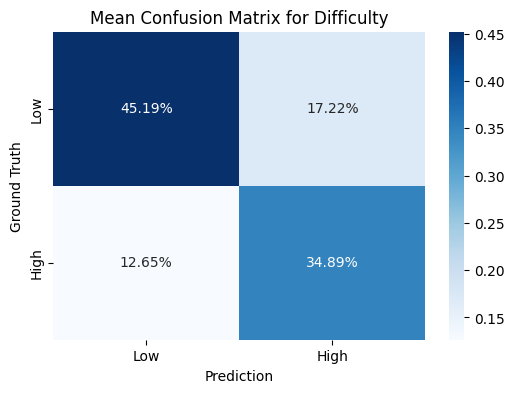

In [7]:
# (Diff) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [1, 2, 3, 5, 10],
    'gamma': [0, 0.1, 0.2],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_diff_scaled, y_diff, participants_ids_diff, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)
    model = XGBClassifier(eval_metric='logloss', scale_pos_weight=(709/540), subsample=0.8, random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Difficulty')
plt.show()

In [8]:
outer_results['best_params']

[[{'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100},
  {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100},
  {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100},
  {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 200},
  {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 200}],
 [{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200},
  {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 200},
  {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50},
  {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 200},
  {'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 100}],
 [{'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50},
  {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 100},
  {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100},
  {'gamma': 0.1, 

Average Performance across multiple runs:
Accuracy: 66.16%, (~1.10)
Precision: 73.02%, (~0.60)
Recall: 76.56%, (~1.52)
F1 Score: 74.72%, (~0.98)


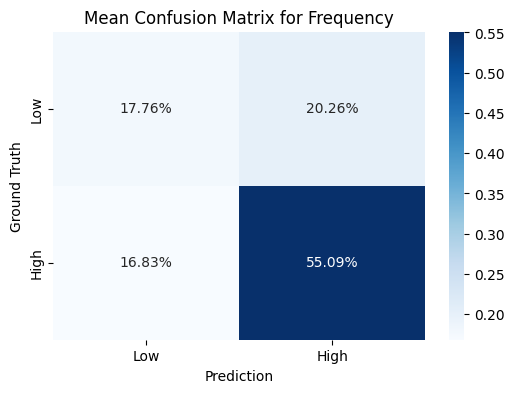

In [9]:
# (Freq) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [1, 2, 3, 5, 10],
    'gamma': [0, 0.1, 0.2],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_freq_scaled, y_freq, participants_ids_freq, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)
    model = XGBClassifier(eval_metric='logloss', scale_pos_weight=(432/817), subsample=0.8, random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Frequency')
plt.show()

In [10]:
outer_results['best_params']

[[{'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100},
  {'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 50},
  {'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 100},
  {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200},
  {'gamma': 0.2, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}],
 [{'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 200},
  {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100},
  {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 50},
  {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200},
  {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}],
 [{'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200},
  {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100},
  {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 50

##### Oversampled Participant-folded XGB Classifier (Separated)

In [11]:
# Prepare Datasets
df_xgb6_diff = df_diff.copy().dropna()
df_xgb6_diff['difficulty'] = df_xgb6_diff['difficulty'].apply(lambda x: 0 if x == 'Easy' else 1)
participants_ids_diff = df_xgb6_diff.reset_index(drop=True)['participant_id']

df_xgb6_diff_scaled = df_xgb6_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)

X_diff_scaled = df_xgb6_diff_scaled.drop(columns=['difficulty'])
X_diff_scaled_p = X_diff_scaled.copy()
X_diff_scaled_p['participant_id'] = participants_ids_diff
y_diff = df_xgb6_diff_scaled['difficulty']



df_xgb6_freq = df_freq.copy().dropna()
df_xgb6_freq['frequency'] = df_xgb6_freq['frequency'].apply(lambda x: 0 if x == 'Slow' else 1)
participants_ids_freq = df_xgb6_freq.reset_index(drop=True)['participant_id']

df_xgb6_freq_scaled = df_xgb6_freq.groupby('participant_id').apply(scale_by_participant_freq).reset_index(drop=True)

X_freq_scaled = df_xgb6_freq_scaled.drop(columns=['frequency'])
X_freq_scaled_p = X_freq_scaled.copy()
X_freq_scaled_p['participant_id'] = participants_ids_freq
y_freq = df_xgb6_freq_scaled['frequency']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_5400\2457370948.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_xgb6_diff_scaled = df_xgb6_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)
C:\Users\vale_ad\AppData\Local\Temp\ipykernel_5400\2457370948.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_xgb6_freq_scaled = df_xgb6_freq.groupby('participant_id').app

In [12]:
# Classes (un)balance (NaN dropped)
print(f"Diff Low:\t{len(df_xgb6_diff_scaled.query("difficulty == 0"))}")
print(f"Diff High:\t{len(df_xgb6_diff_scaled.query("difficulty == 1"))}")

print()

print(f"Freq Low:\t{len(df_xgb6_freq_scaled.query("frequency == 0"))}")
print(f"Freq High:\t{len(df_xgb6_freq_scaled.query("frequency == 1"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


Average Performance across multiple runs:
Accuracy: 72.00%, (~0.60)
Precision: 68.54%, (~0.71)
Recall: 72.55%, (~1.05)
F1 Score: 70.26%, (~0.68)


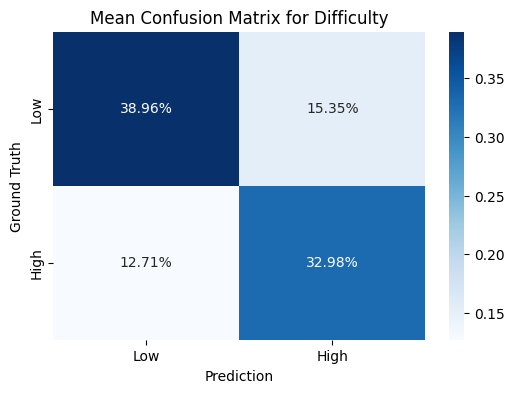

In [13]:
# (Diff) Group-folded nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [1, 2, 3, 5, 10],
    'model__gamma': [0, 0.1, 0.2],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        ('model', XGBClassifier(eval_metric='logloss', subsample=0.8, random_state=random_state))
    ])
    participants_ids = X_diff_scaled_p['participant_id']
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_diff_scaled, y_diff, participants_ids_diff, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }    
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Difficulty')
plt.show()

In [14]:
outer_results['best_params']

[[{'model__gamma': 0.1,
   'model__learning_rate': 0.2,
   'model__max_depth': 3,
   'model__n_estimators': 50},
  {'model__gamma': 0.2,
   'model__learning_rate': 0.1,
   'model__max_depth': 3,
   'model__n_estimators': 50},
  {'model__gamma': 0,
   'model__learning_rate': 0.2,
   'model__max_depth': 1,
   'model__n_estimators': 200},
  {'model__gamma': 0.2,
   'model__learning_rate': 0.1,
   'model__max_depth': 10,
   'model__n_estimators': 50},
  {'model__gamma': 0.2,
   'model__learning_rate': 0.1,
   'model__max_depth': 2,
   'model__n_estimators': 200}],
 [{'model__gamma': 0,
   'model__learning_rate': 0.1,
   'model__max_depth': 3,
   'model__n_estimators': 100},
  {'model__gamma': 0,
   'model__learning_rate': 0.2,
   'model__max_depth': 3,
   'model__n_estimators': 100},
  {'model__gamma': 0,
   'model__learning_rate': 0.1,
   'model__max_depth': 3,
   'model__n_estimators': 100},
  {'model__gamma': 0,
   'model__learning_rate': 0.2,
   'model__max_depth': 1,
   'model__n_esti

Average Performance across multiple runs:
Accuracy: 65.97%, (~0.94)
Precision: 75.87%, (~0.57)
Recall: 70.40%, (~1.64)
F1 Score: 72.95%, (~0.97)


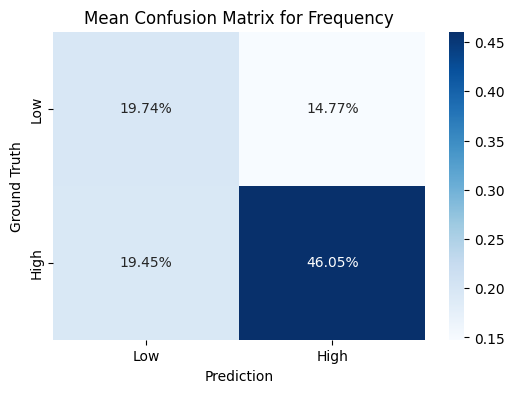

In [15]:
# (Freq) Group-folded nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [1, 2, 3, 5, 10],
    'model__gamma': [0, 0.1, 0.2],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        ('model', XGBClassifier(eval_metric='logloss', subsample=0.8, random_state=random_state))
    ])
    participants_ids = X_freq_scaled_p['participant_id']
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_freq_scaled, y_freq, participants_ids_freq, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)
    
    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }    
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Frequency')
plt.show()

In [16]:
outer_results['best_params']

[[{'model__gamma': 0.2,
   'model__learning_rate': 0.1,
   'model__max_depth': 5,
   'model__n_estimators': 100},
  {'model__gamma': 0,
   'model__learning_rate': 0.1,
   'model__max_depth': 10,
   'model__n_estimators': 100},
  {'model__gamma': 0.2,
   'model__learning_rate': 0.1,
   'model__max_depth': 10,
   'model__n_estimators': 50},
  {'model__gamma': 0,
   'model__learning_rate': 0.01,
   'model__max_depth': 10,
   'model__n_estimators': 100},
  {'model__gamma': 0,
   'model__learning_rate': 0.1,
   'model__max_depth': 1,
   'model__n_estimators': 100}],
 [{'model__gamma': 0.2,
   'model__learning_rate': 0.1,
   'model__max_depth': 3,
   'model__n_estimators': 50},
  {'model__gamma': 0.2,
   'model__learning_rate': 0.2,
   'model__max_depth': 10,
   'model__n_estimators': 100},
  {'model__gamma': 0,
   'model__learning_rate': 0.01,
   'model__max_depth': 10,
   'model__n_estimators': 50},
  {'model__gamma': 0,
   'model__learning_rate': 0.1,
   'model__max_depth': 3,
   'model__

##### Undersampled Participant-folded XGB Classifier (Separated)

In [17]:
# Prepare Datasets
df_xgb7_diff = df_diff.copy().dropna()
df_xgb7_diff['difficulty'] = df_xgb7_diff['difficulty'].apply(lambda x: 0 if x == 'Easy' else 1)
participants_ids_diff = df_xgb7_diff.reset_index(drop=True)['participant_id']

df_xgb7_diff_scaled = df_xgb7_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)

X_diff_scaled = df_xgb7_diff_scaled.drop(columns=['difficulty'])
X_diff_scaled_p = X_diff_scaled.copy()
X_diff_scaled_p['participant_id'] = participants_ids_diff
y_diff = df_xgb7_diff_scaled['difficulty']



df_xgb7_freq = df_freq.copy().dropna()
df_xgb7_freq['frequency'] = df_xgb7_freq['frequency'].apply(lambda x: 0 if x == 'Slow' else 1)
participants_ids_freq = df_xgb7_freq.reset_index(drop=True)['participant_id']

df_xgb7_freq_scaled = df_xgb7_freq.groupby('participant_id').apply(scale_by_participant_freq).reset_index(drop=True)

X_freq_scaled = df_xgb7_freq_scaled.drop(columns=['frequency'])
X_freq_scaled_p = X_freq_scaled.copy()
X_freq_scaled_p['participant_id'] = participants_ids_freq
y_freq = df_xgb7_freq_scaled['frequency']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_5400\404645005.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_xgb7_diff_scaled = df_xgb7_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)
C:\Users\vale_ad\AppData\Local\Temp\ipykernel_5400\404645005.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_xgb7_freq_scaled = df_xgb7_freq.groupby('participant_id').apply

In [18]:
# Classes (un)balance (NaN dropped)
print(f"Diff Low:\t{len(df_xgb7_diff_scaled.query("difficulty == 0"))}")
print(f"Diff High:\t{len(df_xgb7_diff_scaled.query("difficulty == 1"))}")

print()

print(f"Freq Low:\t{len(df_xgb7_freq_scaled.query("frequency == 0"))}")
print(f"Freq High:\t{len(df_xgb7_freq_scaled.query("frequency == 1"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


Average Performance across multiple runs:
Accuracy: 70.83%, (~0.92)
Precision: 67.00%, (~0.85)
Recall: 72.46%, (~1.48)
F1 Score: 69.36%, (~1.07)


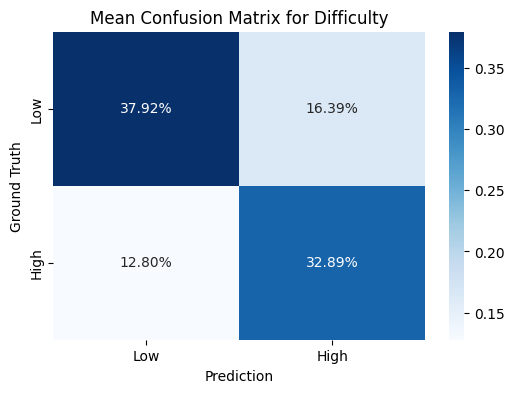

In [19]:
# (Diff) Group-folded nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [1, 2, 3, 5, 10],
    'model__gamma': [0, 0.1, 0.2],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('undersample', RandomUnderSampler(sampling_strategy='auto', random_state=random_state)),
        ('model', XGBClassifier(eval_metric='logloss', subsample=0.8, random_state=random_state))
    ])
    participants_ids = X_diff_scaled_p['participant_id']
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_diff_scaled, y_diff, participants_ids_diff, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }    
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Difficulty')
plt.show()

In [20]:
outer_results['best_params']

[[{'model__gamma': 0.1,
   'model__learning_rate': 0.1,
   'model__max_depth': 5,
   'model__n_estimators': 50},
  {'model__gamma': 0.2,
   'model__learning_rate': 0.1,
   'model__max_depth': 5,
   'model__n_estimators': 50},
  {'model__gamma': 0.2,
   'model__learning_rate': 0.1,
   'model__max_depth': 5,
   'model__n_estimators': 50},
  {'model__gamma': 0.2,
   'model__learning_rate': 0.2,
   'model__max_depth': 3,
   'model__n_estimators': 50},
  {'model__gamma': 0,
   'model__learning_rate': 0.2,
   'model__max_depth': 1,
   'model__n_estimators': 200}],
 [{'model__gamma': 0.2,
   'model__learning_rate': 0.1,
   'model__max_depth': 3,
   'model__n_estimators': 50},
  {'model__gamma': 0.2,
   'model__learning_rate': 0.1,
   'model__max_depth': 3,
   'model__n_estimators': 100},
  {'model__gamma': 0,
   'model__learning_rate': 0.01,
   'model__max_depth': 5,
   'model__n_estimators': 200},
  {'model__gamma': 0.1,
   'model__learning_rate': 0.1,
   'model__max_depth': 2,
   'model__n_

Average Performance across multiple runs:
Accuracy: 65.73%, (~0.58)
Precision: 77.97%, (~0.57)
Recall: 66.28%, (~1.13)
F1 Score: 71.54%, (~0.64)


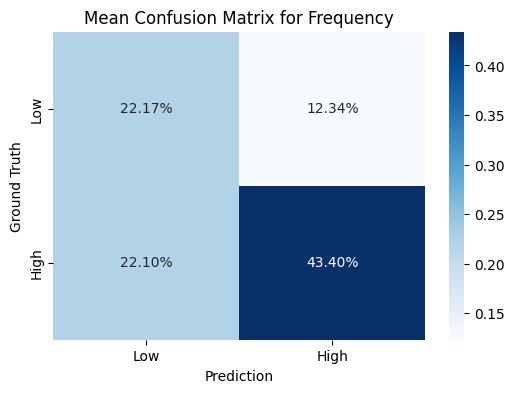

In [21]:
# (Freq) Group-folded nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [1, 2, 3, 5, 10],
    'model__gamma': [0, 0.1, 0.2],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('undersample', RandomUnderSampler(sampling_strategy='auto', random_state=random_state)),
        ('model', XGBClassifier(eval_metric='logloss', subsample=0.8, random_state=random_state))
    ])
    participants_ids = X_freq_scaled_p['participant_id']
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_freq_scaled, y_freq, participants_ids_freq, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)
    
    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }    
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Frequency')
plt.show()

In [22]:
outer_results['best_params']

[[{'model__gamma': 0.2,
   'model__learning_rate': 0.2,
   'model__max_depth': 2,
   'model__n_estimators': 100},
  {'model__gamma': 0,
   'model__learning_rate': 0.2,
   'model__max_depth': 2,
   'model__n_estimators': 50},
  {'model__gamma': 0,
   'model__learning_rate': 0.1,
   'model__max_depth': 1,
   'model__n_estimators': 50},
  {'model__gamma': 0,
   'model__learning_rate': 0.1,
   'model__max_depth': 1,
   'model__n_estimators': 100},
  {'model__gamma': 0,
   'model__learning_rate': 0.2,
   'model__max_depth': 1,
   'model__n_estimators': 50}],
 [{'model__gamma': 0,
   'model__learning_rate': 0.1,
   'model__max_depth': 1,
   'model__n_estimators': 200},
  {'model__gamma': 0.1,
   'model__learning_rate': 0.1,
   'model__max_depth': 3,
   'model__n_estimators': 50},
  {'model__gamma': 0,
   'model__learning_rate': 0.1,
   'model__max_depth': 1,
   'model__n_estimators': 100},
  {'model__gamma': 0,
   'model__learning_rate': 0.1,
   'model__max_depth': 1,
   'model__n_estimators

##### Participant-folded XGB (MultiClass)

In [23]:
# Prepare Dataset
df_xgb9 = df.copy().dropna()
df_xgb9_scaled = df_xgb9.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)
participants_ids = df_xgb9.reset_index(drop=True)['participant_id']
label_mapping = {'Easy_Slow': 0, 'Easy_Fast': 1, 'Hard_Slow': 2, 'Hard_Fast': 3}

X_scaled = df_xgb9_scaled.drop(columns=['condition'])
X_scaled_p = X_scaled.copy()
X_scaled_p['participant_id'] = participants_ids
y = df_xgb9_scaled['condition'].map(label_mapping)

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_5400\2526757723.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_xgb9_scaled = df_xgb9.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [24]:
# Classes unbalance (NaN dropped)
print(f"Diff Low:\t{len(df_xgb9_scaled.query("condition == 'Easy_Slow' | condition == 'Easy_Fast'"))}")
print(f"Diff High:\t{len(df_xgb9_scaled.query("condition == 'Hard_Slow' | condition == 'Hard_Fast'"))}")

print()

print(f"Freq Low:\t{len(df_xgb9_scaled.query("condition == 'Easy_Slow' | condition == 'Hard_Slow'"))}")
print(f"Freq High:\t{len(df_xgb9_scaled.query("condition == 'Easy_Fast' | condition == 'Hard_Fast'"))}")

print()
print()

print(f"Easy Slow:\t{len(df_xgb9_scaled.query("condition == 'Easy_Slow'"))}")
print(f"Easy Fast:\t{len(df_xgb9_scaled.query("condition == 'Easy_Fast'"))}")
print(f"Hard Slow:\t{len(df_xgb9_scaled.query("condition == 'Hard_Slow'"))}")
print(f"Hard Fast:\t{len(df_xgb9_scaled.query("condition == 'Hard_Fast'"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


Easy Slow:	205
Easy Fast:	412
Hard Slow:	187
Hard Fast:	332


Average Performance across multiple runs:
Accuracy: 49.61%, (~0.89)
Precision: 46.54%, (~1.04)
Recall: 44.72%, (~0.86)
F1 Score: 44.66%, (~0.92)


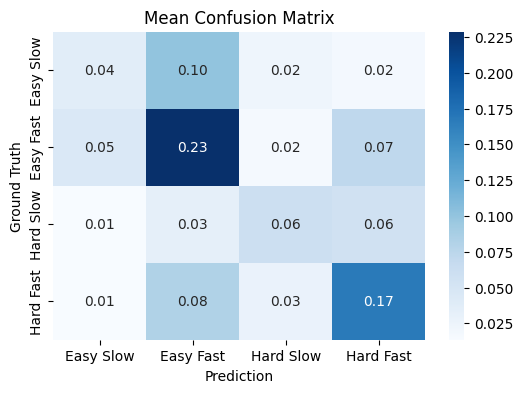

In [25]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [1, 2, 3, 5, 10],
    'model__gamma': [0, 0.1, 0.2],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        # ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        # ('undersample', RandomUnderSampler(sampling_strategy='auto', random_state=random_state)),
        ('model', XGBClassifier(objective='multi:softmax', subsample=0.8, random_state=random_state))
    ])
    participants_ids = X_scaled_p['participant_id']
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_scaled, y, participants_ids, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='recall_macro', refit='recall_macro', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred, average='macro', zero_division=0))
        inner_results['recall'].append(recall_score(y_test, y_pred, average='macro'))
        inner_results['f1'].append(f1_score(y_test, y_pred, average='macro'))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred, labels=class_order))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

In [26]:
outer_results['best_params']

[[{'model__gamma': 0,
   'model__learning_rate': 0.1,
   'model__max_depth': 5,
   'model__n_estimators': 200},
  {'model__gamma': 0.2,
   'model__learning_rate': 0.1,
   'model__max_depth': 10,
   'model__n_estimators': 200},
  {'model__gamma': 0,
   'model__learning_rate': 0.1,
   'model__max_depth': 3,
   'model__n_estimators': 100},
  {'model__gamma': 0.2,
   'model__learning_rate': 0.1,
   'model__max_depth': 2,
   'model__n_estimators': 200},
  {'model__gamma': 0,
   'model__learning_rate': 0.2,
   'model__max_depth': 2,
   'model__n_estimators': 200}],
 [{'model__gamma': 0.2,
   'model__learning_rate': 0.1,
   'model__max_depth': 5,
   'model__n_estimators': 200},
  {'model__gamma': 0,
   'model__learning_rate': 0.2,
   'model__max_depth': 3,
   'model__n_estimators': 50},
  {'model__gamma': 0.1,
   'model__learning_rate': 0.1,
   'model__max_depth': 2,
   'model__n_estimators': 200},
  {'model__gamma': 0.2,
   'model__learning_rate': 0.2,
   'model__max_depth': 10,
   'model__n

##### Oversampled Participant-folded XGB (MultiClass)

In [27]:
# Prepare Dataset
df_xgb9 = df.copy().dropna()
df_xgb9_scaled = df_xgb9.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)
participants_ids = df_xgb9.reset_index(drop=True)['participant_id']
label_mapping = {'Easy_Slow': 0, 'Easy_Fast': 1, 'Hard_Slow': 2, 'Hard_Fast': 3}

X_scaled = df_xgb9_scaled.drop(columns=['condition'])
X_scaled_p = X_scaled.copy()
X_scaled_p['participant_id'] = participants_ids
y = df_xgb9_scaled['condition'].map(label_mapping)

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_5400\2526757723.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_xgb9_scaled = df_xgb9.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [28]:
# Classes unbalance (NaN dropped)
print(f"Diff Low:\t{len(df_xgb9_scaled.query("condition == 'Easy_Slow' | condition == 'Easy_Fast'"))}")
print(f"Diff High:\t{len(df_xgb9_scaled.query("condition == 'Hard_Slow' | condition == 'Hard_Fast'"))}")

print()

print(f"Freq Low:\t{len(df_xgb9_scaled.query("condition == 'Easy_Slow' | condition == 'Hard_Slow'"))}")
print(f"Freq High:\t{len(df_xgb9_scaled.query("condition == 'Easy_Fast' | condition == 'Hard_Fast'"))}")

print()
print()

print(f"Easy Slow:\t{len(df_xgb9_scaled.query("condition == 'Easy_Slow'"))}")
print(f"Easy Fast:\t{len(df_xgb9_scaled.query("condition == 'Easy_Fast'"))}")
print(f"Hard Slow:\t{len(df_xgb9_scaled.query("condition == 'Hard_Slow'"))}")
print(f"Hard Fast:\t{len(df_xgb9_scaled.query("condition == 'Hard_Fast'"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


Easy Slow:	205
Easy Fast:	412
Hard Slow:	187
Hard Fast:	332


Average Performance across multiple runs:
Accuracy: 48.54%, (~1.09)
Precision: 46.65%, (~0.99)
Recall: 47.39%, (~0.93)
F1 Score: 46.58%, (~0.97)


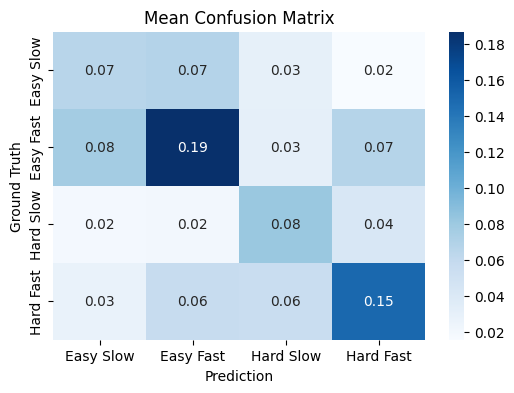

In [29]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [1, 2, 3, 5, 10],
    'model__gamma': [0, 0.1, 0.2],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        # ('undersample', RandomUnderSampler(sampling_strategy='auto', random_state=random_state)),
        ('model', XGBClassifier(objective='multi:softmax', subsample=0.8, random_state=random_state))
    ])
    participants_ids = X_scaled_p['participant_id']
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_scaled, y, participants_ids, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='recall_macro', refit='recall_macro', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred, average='macro', zero_division=0))
        inner_results['recall'].append(recall_score(y_test, y_pred, average='macro'))
        inner_results['f1'].append(f1_score(y_test, y_pred, average='macro'))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred, labels=class_order))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

In [30]:
outer_results['best_params']

[[{'model__gamma': 0,
   'model__learning_rate': 0.2,
   'model__max_depth': 2,
   'model__n_estimators': 100},
  {'model__gamma': 0.1,
   'model__learning_rate': 0.1,
   'model__max_depth': 10,
   'model__n_estimators': 100},
  {'model__gamma': 0.1,
   'model__learning_rate': 0.2,
   'model__max_depth': 3,
   'model__n_estimators': 100},
  {'model__gamma': 0.2,
   'model__learning_rate': 0.1,
   'model__max_depth': 5,
   'model__n_estimators': 100},
  {'model__gamma': 0,
   'model__learning_rate': 0.2,
   'model__max_depth': 2,
   'model__n_estimators': 100}],
 [{'model__gamma': 0,
   'model__learning_rate': 0.2,
   'model__max_depth': 1,
   'model__n_estimators': 200},
  {'model__gamma': 0,
   'model__learning_rate': 0.01,
   'model__max_depth': 10,
   'model__n_estimators': 50},
  {'model__gamma': 0.2,
   'model__learning_rate': 0.1,
   'model__max_depth': 5,
   'model__n_estimators': 100},
  {'model__gamma': 0,
   'model__learning_rate': 0.2,
   'model__max_depth': 10,
   'model__n

##### Undersampled Participant-folded XGB (MultiClass)

In [31]:
# Prepare Dataset
df_xgb9 = df.copy().dropna()
df_xgb9_scaled = df_xgb9.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)
participants_ids = df_xgb9.reset_index(drop=True)['participant_id']
label_mapping = {'Easy_Slow': 0, 'Easy_Fast': 1, 'Hard_Slow': 2, 'Hard_Fast': 3}

X_scaled = df_xgb9_scaled.drop(columns=['condition'])
X_scaled_p = X_scaled.copy()
X_scaled_p['participant_id'] = participants_ids
y = df_xgb9_scaled['condition'].map(label_mapping)

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_5400\2526757723.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_xgb9_scaled = df_xgb9.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [32]:
# Classes unbalance (NaN dropped)
print(f"Diff Low:\t{len(df_xgb9_scaled.query("condition == 'Easy_Slow' | condition == 'Easy_Fast'"))}")
print(f"Diff High:\t{len(df_xgb9_scaled.query("condition == 'Hard_Slow' | condition == 'Hard_Fast'"))}")

print()

print(f"Freq Low:\t{len(df_xgb9_scaled.query("condition == 'Easy_Slow' | condition == 'Hard_Slow'"))}")
print(f"Freq High:\t{len(df_xgb9_scaled.query("condition == 'Easy_Fast' | condition == 'Hard_Fast'"))}")

print()
print()

print(f"Easy Slow:\t{len(df_xgb9_scaled.query("condition == 'Easy_Slow'"))}")
print(f"Easy Fast:\t{len(df_xgb9_scaled.query("condition == 'Easy_Fast'"))}")
print(f"Hard Slow:\t{len(df_xgb9_scaled.query("condition == 'Hard_Slow'"))}")
print(f"Hard Fast:\t{len(df_xgb9_scaled.query("condition == 'Hard_Fast'"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


Easy Slow:	205
Easy Fast:	412
Hard Slow:	187
Hard Fast:	332


Average Performance across multiple runs:
Accuracy: 45.89%, (~0.92)
Precision: 45.16%, (~0.76)
Recall: 46.34%, (~0.82)
F1 Score: 44.99%, (~0.86)


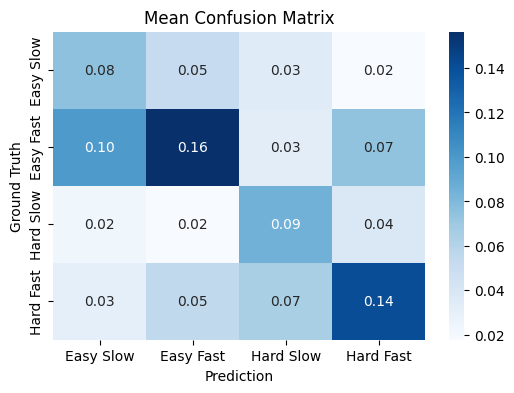

In [33]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [1, 2, 3, 5, 10],
    'model__gamma': [0, 0.1, 0.2],
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        # ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        ('undersample', RandomUnderSampler(sampling_strategy='auto', random_state=random_state)),
        ('model', XGBClassifier(objective='multi:softmax', subsample=0.8, random_state=random_state))
    ])
    participants_ids = X_scaled_p['participant_id']
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_scaled, y, participants_ids, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='recall_macro', refit='recall_macro', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred, average='macro', zero_division=0))
        inner_results['recall'].append(recall_score(y_test, y_pred, average='macro'))
        inner_results['f1'].append(f1_score(y_test, y_pred, average='macro'))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred, labels=class_order))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

In [34]:
outer_results['best_params']

[[{'model__gamma': 0.2,
   'model__learning_rate': 0.1,
   'model__max_depth': 5,
   'model__n_estimators': 50},
  {'model__gamma': 0.1,
   'model__learning_rate': 0.1,
   'model__max_depth': 5,
   'model__n_estimators': 100},
  {'model__gamma': 0,
   'model__learning_rate': 0.2,
   'model__max_depth': 10,
   'model__n_estimators': 200},
  {'model__gamma': 0,
   'model__learning_rate': 0.2,
   'model__max_depth': 10,
   'model__n_estimators': 50},
  {'model__gamma': 0,
   'model__learning_rate': 0.1,
   'model__max_depth': 3,
   'model__n_estimators': 50}],
 [{'model__gamma': 0,
   'model__learning_rate': 0.2,
   'model__max_depth': 3,
   'model__n_estimators': 50},
  {'model__gamma': 0.1,
   'model__learning_rate': 0.2,
   'model__max_depth': 5,
   'model__n_estimators': 50},
  {'model__gamma': 0.2,
   'model__learning_rate': 0.2,
   'model__max_depth': 5,
   'model__n_estimators': 50},
  {'model__gamma': 0.2,
   'model__learning_rate': 0.01,
   'model__max_depth': 10,
   'model__n_es

### 6. Multilayer Perceptron Classifier

##### Basic MLP (MultiClass)

In [215]:
# Prepare Dataset
df_mlp1 = df.copy()
df_mlp1 = df_mlp1.drop(columns=['participant_id']).dropna()

X = df_mlp1.drop(columns=['condition', 'difficulty', 'frequency'])
y = df_mlp1['condition']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

df_mlp1_scaled = pd.concat([X_scaled, y.reset_index(drop=True)], axis=1)

In [216]:
# Classes unbalance (NaN dropped)
print(f"Diff Low:\t{len(df_mlp1_scaled.query("condition == 'Easy_Slow' | condition == 'Easy_Fast'"))}")
print(f"Diff High:\t{len(df_mlp1_scaled.query("condition == 'Hard_Slow' | condition == 'Hard_Fast'"))}")

print()

print(f"Freq Low:\t{len(df_mlp1_scaled.query("condition == 'Easy_Slow' | condition == 'Hard_Slow'"))}")
print(f"Freq High:\t{len(df_mlp1_scaled.query("condition == 'Easy_Fast' | condition == 'Hard_Fast'"))}")

print()
print()

print(f"Easy Slow:\t{len(df_mlp1_scaled.query("condition == 'Easy_Slow'"))}")
print(f"Easy Fast:\t{len(df_mlp1_scaled.query("condition == 'Easy_Fast'"))}")
print(f"Hard Slow:\t{len(df_mlp1_scaled.query("condition == 'Hard_Slow'"))}")
print(f"Hard Fast:\t{len(df_mlp1_scaled.query("condition == 'Hard_Fast'"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


Easy Slow:	205
Easy Fast:	412
Hard Slow:	187
Hard Fast:	332


c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached 

Average Performance across multiple runs:
Accuracy: 43.68%, (~1.24)
Precision: 41.58%, (~1.35)
Recall: 40.91%, (~1.21)
F1 Score: 40.96%, (~1.25)


c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


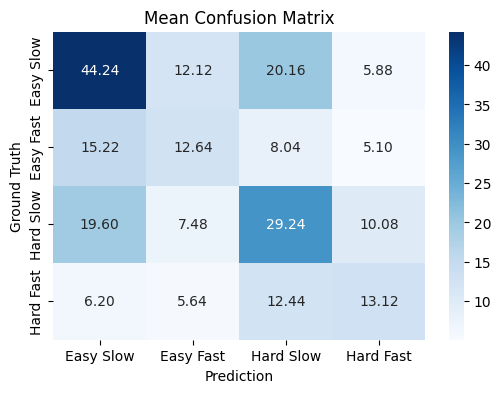

In [217]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'hidden_layer_sizes': [(20), (20, 10), (40, 20, 10)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01, 0.1]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = MLPClassifier(max_iter=1000, shuffle=True, random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_scaled, y):
        X_train, X_test = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1_macro', refit='f1_macro', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred, average='macro'))
        inner_results['recall'].append(recall_score(y_test, y_pred, average='macro'))
        inner_results['f1'].append(f1_score(y_test, y_pred, average='macro'))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

##### Participant-scaled MLP (MultiClass)

In [218]:
# Prepare Dataset
df_mlp2 = df.copy().dropna()
df_mlp2_scaled = df_mlp2.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)

X_scaled = df_mlp2_scaled.drop(columns=['condition'])
y = df_mlp2_scaled['condition']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\571551214.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_mlp2_scaled = df_mlp2.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [219]:
# Classes unbalance (NaN dropped)
print(f"Diff Low:\t{len(df_mlp2_scaled.query("condition == 'Easy_Slow' | condition == 'Easy_Fast'"))}")
print(f"Diff High:\t{len(df_mlp2_scaled.query("condition == 'Hard_Slow' | condition == 'Hard_Fast'"))}")

print()

print(f"Freq Low:\t{len(df_mlp2_scaled.query("condition == 'Easy_Slow' | condition == 'Hard_Slow'"))}")
print(f"Freq High:\t{len(df_mlp2_scaled.query("condition == 'Easy_Fast' | condition == 'Hard_Fast'"))}")

print()
print()

print(f"Easy Slow:\t{len(df_mlp2_scaled.query("condition == 'Easy_Slow'"))}")
print(f"Easy Fast:\t{len(df_mlp2_scaled.query("condition == 'Easy_Fast'"))}")
print(f"Hard Slow:\t{len(df_mlp2_scaled.query("condition == 'Hard_Slow'"))}")
print(f"Hard Fast:\t{len(df_mlp2_scaled.query("condition == 'Hard_Fast'"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


Easy Slow:	205
Easy Fast:	412
Hard Slow:	187
Hard Fast:	332


c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached 

Average Performance across multiple runs:
Accuracy: 47.15%, (~1.10)
Precision: 45.07%, (~1.31)
Recall: 44.45%, (~1.21)
F1 Score: 44.46%, (~1.32)


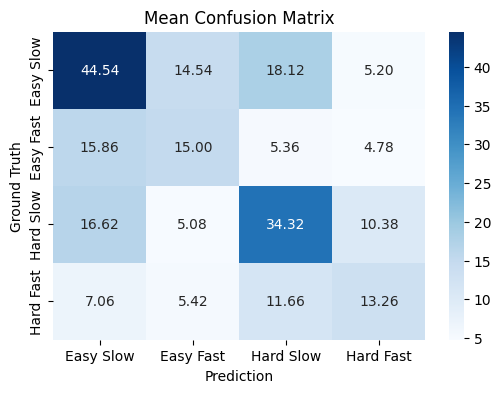

In [220]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'hidden_layer_sizes': [(20), (20, 10), (40, 20, 10)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01, 0.1]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = MLPClassifier(max_iter=1000, shuffle=True, random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_scaled, y):
        X_train, X_test = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1_macro', refit='f1_macro', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred, average='macro'))
        inner_results['recall'].append(recall_score(y_test, y_pred, average='macro'))
        inner_results['f1'].append(f1_score(y_test, y_pred, average='macro'))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

##### Basic MLP (Separated)

In [221]:
# Prepare Datasets
df_mlp1_diff = df_diff.copy()
df_mlp1_diff = df_mlp1_diff.drop(columns=['participant_id']).dropna()
df_mlp1_diff['difficulty'] = df_mlp1_diff['difficulty'].apply(lambda x: 0 if x == 'Easy' else 1)

X_diff = df_mlp1_diff.drop(columns=['difficulty'])
y_diff = df_mlp1_diff['difficulty']

scaler = StandardScaler()
X_diff_scaled = scaler.fit_transform(X_diff)
X_diff_scaled = pd.DataFrame(X_diff_scaled, columns=X_diff.columns)

df_mlp1_diff_scaled = pd.concat([X_diff_scaled, y_diff.reset_index(drop=True)], axis=1)


df_mlp1_freq = df_freq.copy()
df_mlp1_freq = df_mlp1_freq.drop(columns=['participant_id']).dropna()
df_mlp1_freq['frequency'] = df_mlp1_freq['frequency'].apply(lambda x: 0 if x == 'Slow' else 1)

X_freq = df_mlp1_freq.drop(columns=['frequency'])
y_freq = df_mlp1_freq['frequency']

scaler = StandardScaler()
X_freq_scaled = scaler.fit_transform(X_freq)
X_freq_scaled = pd.DataFrame(X_freq_scaled, columns=X_freq.columns)

df_mlp1_freq_scaled = pd.concat([X_freq_scaled, y_freq.reset_index(drop=True)], axis=1)

In [222]:
# Classes unbalance (NaN dropped)
print(f"Diff Low:\t{len(df_mlp1_diff_scaled.query("difficulty == 0"))}")
print(f"Diff High:\t{len(df_mlp1_diff_scaled.query("difficulty == 1"))}")

print()

print(f"Freq Low:\t{len(df_mlp1_freq_scaled.query("frequency == 0"))}")
print(f"Freq High:\t{len(df_mlp1_freq_scaled.query("frequency == 1"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached 

Average Performance across multiple runs:
Accuracy: 66.77%, (~1.28)
Precision: 63.38%, (~1.72)
Recall: 66.05%, (~2.39)
F1 Score: 64.40%, (~1.15)


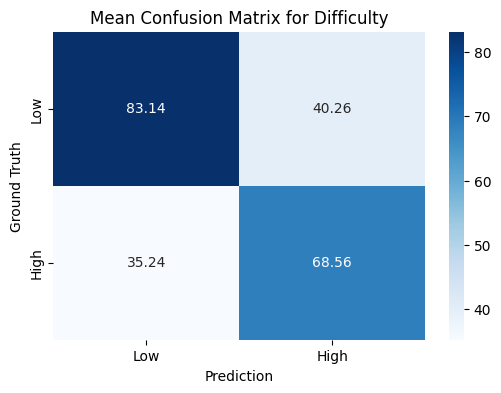

In [223]:
# (Diff) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'hidden_layer_sizes': [(20), (20, 10)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01, 0.1]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = MLPClassifier(max_iter=1000, shuffle=True, random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_diff_scaled, y_diff):
        X_train, X_test = X_diff_scaled.iloc[train_idx], X_diff_scaled.iloc[test_idx]
        y_train, y_test = y_diff.iloc[train_idx], y_diff.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Difficulty')
plt.show()

c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached 

Average Performance across multiple runs:
Accuracy: 68.67%, (~1.40)
Precision: 74.03%, (~0.65)
Recall: 80.67%, (~2.35)
F1 Score: 76.98%, (~1.43)


c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


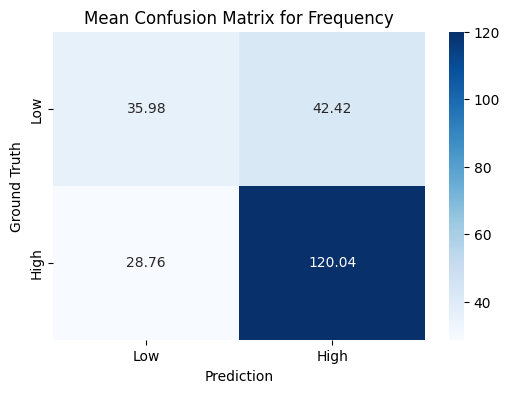

In [224]:
# (Freq) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'hidden_layer_sizes': [(20), (20, 10)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01, 0.1]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = MLPClassifier(max_iter=1000, shuffle=True, random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_freq_scaled, y_freq):
        X_train, X_test = X_freq_scaled.iloc[train_idx], X_freq_scaled.iloc[test_idx]
        y_train, y_test = y_freq.iloc[train_idx], y_freq.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Frequency')
plt.show()

##### Participant-scaled MLP (Separated)

In [225]:
# Prepare Datasets
df_mlp2_diff = df_diff.copy().dropna()
df_mlp2_diff['difficulty'] = df_mlp2_diff['difficulty'].apply(lambda x: 0 if x == 'Easy' else 1)
df_mlp2_diff_scaled = df_mlp2_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)

X_diff_scaled = df_mlp2_diff_scaled.drop(columns=['difficulty'])
y_diff = df_mlp2_diff_scaled['difficulty']


df_mlp2_freq = df_freq.copy().dropna()
df_mlp2_freq['frequency'] = df_mlp2_freq['frequency'].apply(lambda x: 0 if x == 'Slow' else 1)
df_mlp2_freq_scaled = df_mlp2_freq.groupby('participant_id').apply(scale_by_participant_freq).reset_index(drop=True)

X_freq_scaled = df_mlp2_freq_scaled.drop(columns=['frequency'])
y_freq = df_mlp2_freq_scaled['frequency']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\1413189049.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_mlp2_diff_scaled = df_mlp2_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)
C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\1413189049.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_mlp2_freq_scaled = df_mlp2_freq.groupby('participant_id').a

In [226]:
# Classes unbalance (NaN dropped)
print(f"Diff Low:\t{len(df_mlp2_diff_scaled.query("difficulty == 0"))}")
print(f"Diff High:\t{len(df_mlp2_diff_scaled.query("difficulty == 1"))}")

print()

print(f"Freq Low:\t{len(df_mlp2_freq_scaled.query("frequency == 0"))}")
print(f"Freq High:\t{len(df_mlp2_freq_scaled.query("frequency == 1"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached 

Average Performance across multiple runs:
Accuracy: 70.44%, (~1.54)
Precision: 67.37%, (~2.52)
Recall: 69.17%, (~2.35)
F1 Score: 68.04%, (~1.22)


c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


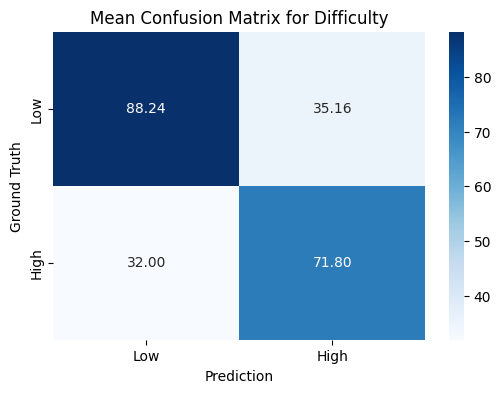

In [227]:
# (Diff) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'hidden_layer_sizes': [(20), (20, 10)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01, 0.1]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = MLPClassifier(max_iter=1000, shuffle=True, random_state=random_state)
    
    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_diff_scaled, y_diff):
        X_train, X_test = X_diff_scaled.iloc[train_idx], X_diff_scaled.iloc[test_idx]
        y_train, y_test = y_diff.iloc[train_idx], y_diff.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Difficulty')
plt.show()

c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached 

Average Performance across multiple runs:
Accuracy: 68.51%, (~0.92)
Precision: 73.36%, (~0.97)
Recall: 81.76%, (~1.38)
F1 Score: 77.24%, (~0.66)


c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


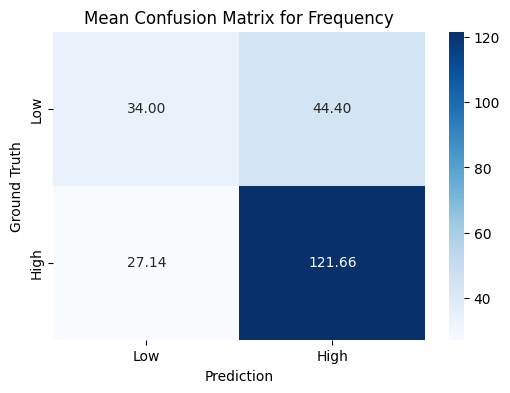

In [228]:
# (Freq) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'hidden_layer_sizes': [(20), (20, 10)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01, 0.1]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = MLPClassifier(max_iter=1000, shuffle=True, random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_freq_scaled, y_freq):
        X_train, X_test = X_freq_scaled.iloc[train_idx], X_freq_scaled.iloc[test_idx]
        y_train, y_test = y_freq.iloc[train_idx], y_freq.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Frequency')
plt.show()

##### Undersampled Participant-scaled MLP Classifier (Separated)

In [229]:
# Prepare Datasets
df_mlp3_diff = df_diff.copy().dropna()
df_mlp3_diff['difficulty'] = df_mlp3_diff['difficulty'].apply(lambda x: 0 if x == 'Easy' else 1)

df_mlp3_diff_scaled = df_mlp3_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)

X_diff_scaled = df_mlp3_diff_scaled.drop(columns=['difficulty'])
y_diff = df_mlp3_diff_scaled['difficulty']


df_mlp3_freq = df_freq.copy().dropna()
df_mlp3_freq['frequency'] = df_mlp3_freq['frequency'].apply(lambda x: 0 if x == 'Slow' else 1)

df_mlp3_freq_scaled = df_mlp3_freq.groupby('participant_id').apply(scale_by_participant_freq).reset_index(drop=True)

X_freq_scaled = df_mlp3_freq_scaled.drop(columns=['frequency'])
y_freq = df_mlp3_freq_scaled['frequency']

undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=random_state)
X_diff_scaled_us, y_diff_us = undersampler.fit_resample(X_diff_scaled, y_diff)
X_freq_scaled_us, y_freq_us = undersampler.fit_resample(X_freq_scaled, y_freq)

df_mlp3_diff_scaled_us = X_diff_scaled_us.join(y_diff_us)
df_mlp3_freq_scaled_us = X_freq_scaled_us.join(y_freq_us)

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\3842749972.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_mlp3_diff_scaled = df_mlp3_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)
C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\3842749972.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_mlp3_freq_scaled = df_mlp3_freq.groupby('participant_id').a

In [230]:
# Classes (un)balance
print(f"Diff Low:\t{len(df_mlp3_diff_scaled_us.query("difficulty == 0"))}")
print(f"Diff High:\t{len(df_mlp3_diff_scaled_us.query("difficulty == 1"))}")

print()

print(f"Freq Low:\t{len(df_mlp3_freq_scaled_us.query("frequency == 0"))}")
print(f"Freq High:\t{len(df_mlp3_freq_scaled_us.query("frequency == 1"))}")

Diff Low:	519
Diff High:	519

Freq Low:	392
Freq High:	392


c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached 

Average Performance across multiple runs:
Accuracy: 71.77%, (~1.54)
Precision: 71.66%, (~1.67)
Recall: 72.37%, (~1.74)
F1 Score: 71.90%, (~1.53)


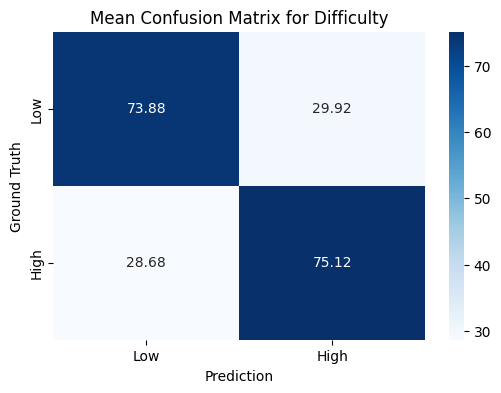

In [231]:
# (Diff) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'hidden_layer_sizes': [(20), (20, 10)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01, 0.1]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=random_state)
    X_diff_scaled_us, y_diff_us = undersampler.fit_resample(X_diff_scaled, y_diff)

    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = MLPClassifier(max_iter=1000, shuffle=True, random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }    
    for train_idx, test_idx in outer_cv.split(X_diff_scaled_us, y_diff_us):
        X_train, X_test = X_diff_scaled_us.iloc[train_idx], X_diff_scaled_us.iloc[test_idx]
        y_train, y_test = y_diff_us.iloc[train_idx], y_diff_us.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Difficulty')
plt.show()

c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached 

Average Performance across multiple runs:
Accuracy: 64.18%, (~1.38)
Precision: 64.44%, (~1.73)
Recall: 64.28%, (~2.43)
F1 Score: 64.00%, (~1.45)


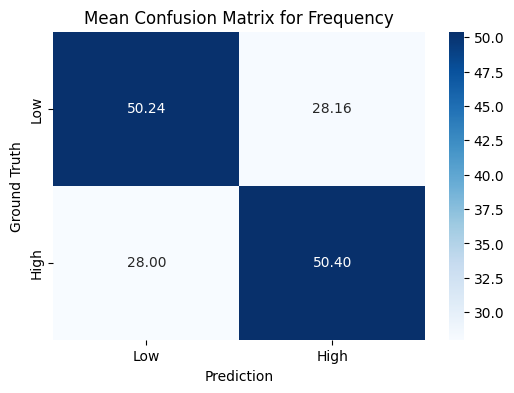

In [232]:
# (Freq) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'hidden_layer_sizes': [(20), (20, 10)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01, 0.1]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=random_state)
    X_freq_scaled_us, y_freq_us = undersampler.fit_resample(X_freq_scaled, y_freq)

    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    model = MLPClassifier(max_iter=1000, shuffle=True, random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_freq_scaled_us, y_freq_us):
        X_train, X_test = X_freq_scaled_us.iloc[train_idx], X_freq_scaled_us.iloc[test_idx]
        y_train, y_test = y_freq_us.iloc[train_idx], y_freq_us.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Frequency')
plt.show()

##### Oversampled Participant-scaled MLP Classifier (Separated)

In [233]:
# Prepare Datasets
df_mlp4_diff = df_diff.copy().dropna()
df_mlp4_diff['difficulty'] = df_mlp4_diff['difficulty'].apply(lambda x: 0 if x == 'Easy' else 1)

df_mlp4_diff_scaled = df_mlp4_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)

X_diff_scaled = df_mlp4_diff_scaled.drop(columns=['difficulty'])
y_diff = df_mlp4_diff_scaled['difficulty']


df_mlp4_freq = df_freq.copy().dropna()
df_mlp4_freq['frequency'] = df_mlp4_freq['frequency'].apply(lambda x: 0 if x == 'Slow' else 1)

df_mlp4_freq_scaled = df_mlp4_freq.groupby('participant_id').apply(scale_by_participant_freq).reset_index(drop=True)

X_freq_scaled = df_mlp4_freq_scaled.drop(columns=['frequency'])
y_freq = df_mlp4_freq_scaled['frequency']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\1763173846.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_mlp4_diff_scaled = df_mlp4_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)
C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\1763173846.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_mlp4_freq_scaled = df_mlp4_freq.groupby('participant_id').a

In [234]:
# Classes (un)balance (NaN dropped)
print(f"Diff Low:\t{len(df_mlp4_diff_scaled.query("difficulty == 0"))}")
print(f"Diff High:\t{len(df_mlp4_diff_scaled.query("difficulty == 1"))}")

print()

print(f"Freq Low:\t{len(df_mlp4_freq_scaled.query("frequency == 0"))}")
print(f"Freq High:\t{len(df_mlp4_freq_scaled.query("frequency == 1"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached 

Average Performance across multiple runs:
Accuracy: 71.19%, (~0.89)
Precision: 68.02%, (~0.92)
Recall: 70.12%, (~1.47)
F1 Score: 68.94%, (~1.05)


c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


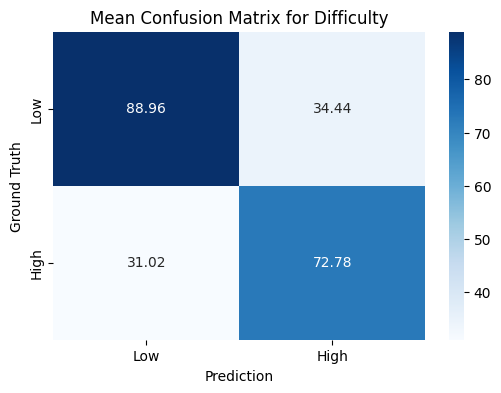

In [235]:
# (Diff) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__hidden_layer_sizes': [(20), (20, 10)],
    'model__alpha': [0.0001, 0.001, 0.01],
    'model__learning_rate_init': [0.001, 0.01, 0.1]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        ('model', MLPClassifier(max_iter=1000, shuffle=True, random_state=random_state))
    ])
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }    
    for train_idx, test_idx in outer_cv.split(X_diff_scaled, y_diff):
        X_train, X_test = X_diff_scaled.iloc[train_idx], X_diff_scaled.iloc[test_idx]
        y_train, y_test = y_diff.iloc[train_idx], y_diff.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Difficulty')
plt.show()

c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached 

Average Performance across multiple runs:
Accuracy: 64.83%, (~1.40)
Precision: 74.51%, (~0.80)
Recall: 70.62%, (~3.31)
F1 Score: 72.30%, (~1.69)


c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


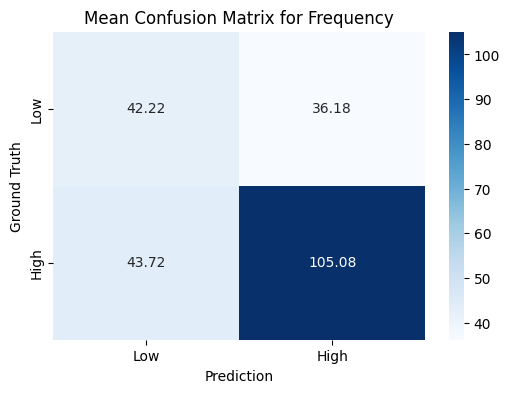

In [236]:
# (Freq) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__hidden_layer_sizes': [(20), (20, 10)],
    'model__alpha': [0.0001, 0.001, 0.01],
    'model__learning_rate_init': [0.001, 0.01, 0.1]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        ('model', MLPClassifier(max_iter=1000, shuffle=True, random_state=random_state))
    ])
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    for train_idx, test_idx in outer_cv.split(X_freq_scaled, y_freq):
        X_train, X_test = X_freq_scaled.iloc[train_idx], X_freq_scaled.iloc[test_idx]
        y_train, y_test = y_freq.iloc[train_idx], y_freq.iloc[test_idx]
        
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Frequency')
plt.show()

##### Participant-folded MLP (Separated)

In [365]:
# Prepare Datasets
df_mlp5_diff = df_diff.copy().dropna()
df_mlp5_diff['difficulty'] = df_mlp5_diff['difficulty'].apply(lambda x: 0 if x == 'Easy' else 1)
df_mlp5_diff_scaled = df_mlp5_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)
participants_ids_diff = df_mlp5_diff.reset_index(drop=True)['participant_id']

X_diff_scaled = df_mlp5_diff_scaled.drop(columns=['difficulty'])
y_diff = df_mlp5_diff_scaled['difficulty']


df_mlp5_freq = df_freq.copy().dropna()
df_mlp5_freq['frequency'] = df_mlp5_freq['frequency'].apply(lambda x: 0 if x == 'Slow' else 1)
df_mlp5_freq_scaled = df_mlp5_freq.groupby('participant_id').apply(scale_by_participant_freq).reset_index(drop=True)
participants_ids_freq = df_mlp5_freq.reset_index(drop=True)['participant_id']

X_freq_scaled = df_mlp5_freq_scaled.drop(columns=['frequency'])
y_freq = df_mlp5_freq_scaled['frequency']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\2392228610.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_mlp5_diff_scaled = df_mlp5_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)
C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\2392228610.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_mlp5_freq_scaled = df_mlp5_freq.groupby('participant_id').a

In [366]:
# Classes unbalance (NaN dropped)
print(f"Diff Low:\t{len(df_mlp5_diff_scaled.query("difficulty == 0"))}")
print(f"Diff High:\t{len(df_mlp5_diff_scaled.query("difficulty == 1"))}")

print()

print(f"Freq Low:\t{len(df_mlp5_freq_scaled.query("frequency == 0"))}")
print(f"Freq High:\t{len(df_mlp5_freq_scaled.query("frequency == 1"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached 

Average Performance across multiple runs:
Accuracy: 70.41%, (~1.08)
Precision: 67.29%, (~1.06)
Recall: 68.83%, (~1.63)
F1 Score: 67.91%, (~1.32)


c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


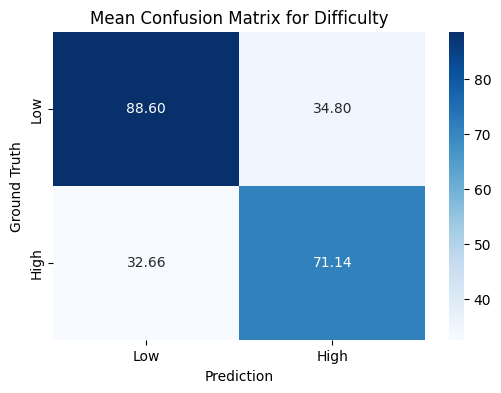

In [367]:
# (Diff) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'hidden_layer_sizes': [(20), (20, 10)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01, 0.1]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_diff_scaled, y_diff, participants_ids_diff, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)
    model = MLPClassifier(max_iter=1000, shuffle=True, random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Difficulty')
plt.show()

In [368]:
outer_results['best_params']

[[{'alpha': 0.0001, 'hidden_layer_sizes': 20, 'learning_rate_init': 0.001},
  {'alpha': 0.01, 'hidden_layer_sizes': 20, 'learning_rate_init': 0.001},
  {'alpha': 0.001, 'hidden_layer_sizes': 20, 'learning_rate_init': 0.001},
  {'alpha': 0.001, 'hidden_layer_sizes': 20, 'learning_rate_init': 0.001},
  {'alpha': 0.01, 'hidden_layer_sizes': 20, 'learning_rate_init': 0.001}],
 [{'alpha': 0.01, 'hidden_layer_sizes': 20, 'learning_rate_init': 0.001},
  {'alpha': 0.01, 'hidden_layer_sizes': 20, 'learning_rate_init': 0.001},
  {'alpha': 0.001, 'hidden_layer_sizes': 20, 'learning_rate_init': 0.001},
  {'alpha': 0.001, 'hidden_layer_sizes': 20, 'learning_rate_init': 0.001},
  {'alpha': 0.0001,
   'hidden_layer_sizes': (20, 10),
   'learning_rate_init': 0.1}],
 [{'alpha': 0.01, 'hidden_layer_sizes': 20, 'learning_rate_init': 0.001},
  {'alpha': 0.01, 'hidden_layer_sizes': (20, 10), 'learning_rate_init': 0.1},
  {'alpha': 0.001, 'hidden_layer_sizes': 20, 'learning_rate_init': 0.001},
  {'alpha': 0

c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached 

Average Performance across multiple runs:
Accuracy: 67.32%, (~0.73)
Precision: 73.03%, (~0.74)
Recall: 79.55%, (~2.62)
F1 Score: 75.98%, (~1.00)


c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


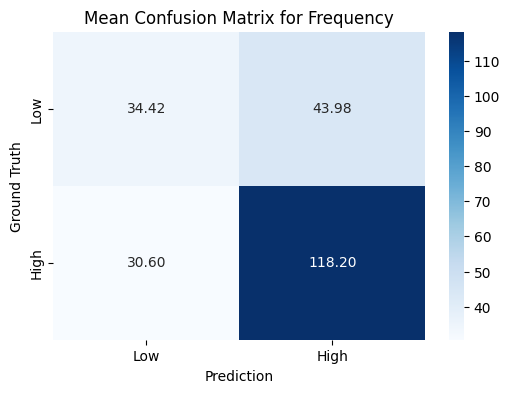

In [369]:
# (Freq) Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'hidden_layer_sizes': [(20), (20, 10)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01, 0.1]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_freq_scaled, y_freq, participants_ids_freq, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)
    model = MLPClassifier(max_iter=1000, shuffle=True, random_state=random_state)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(outer_results['confusion_matrices'], axis=0), annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Frequency')
plt.show()

In [370]:
outer_results['best_params']

[[{'alpha': 0.0001, 'hidden_layer_sizes': 20, 'learning_rate_init': 0.1},
  {'alpha': 0.001, 'hidden_layer_sizes': 20, 'learning_rate_init': 0.001},
  {'alpha': 0.0001, 'hidden_layer_sizes': 20, 'learning_rate_init': 0.001},
  {'alpha': 0.01, 'hidden_layer_sizes': 20, 'learning_rate_init': 0.001},
  {'alpha': 0.01, 'hidden_layer_sizes': 20, 'learning_rate_init': 0.001}],
 [{'alpha': 0.01, 'hidden_layer_sizes': 20, 'learning_rate_init': 0.001},
  {'alpha': 0.0001, 'hidden_layer_sizes': 20, 'learning_rate_init': 0.001},
  {'alpha': 0.0001, 'hidden_layer_sizes': 20, 'learning_rate_init': 0.001},
  {'alpha': 0.001, 'hidden_layer_sizes': 20, 'learning_rate_init': 0.001},
  {'alpha': 0.01, 'hidden_layer_sizes': 20, 'learning_rate_init': 0.001}],
 [{'alpha': 0.0001, 'hidden_layer_sizes': 20, 'learning_rate_init': 0.001},
  {'alpha': 0.0001, 'hidden_layer_sizes': (20, 10), 'learning_rate_init': 0.1},
  {'alpha': 0.0001, 'hidden_layer_sizes': 20, 'learning_rate_init': 0.001},
  {'alpha': 0.001,

##### Oversampled Participant-folded MLP Classifier (Separated)

In [371]:
# Prepare Datasets
df_mlp6_diff = df_diff.copy().dropna()
df_mlp6_diff['difficulty'] = df_mlp6_diff['difficulty'].apply(lambda x: 0 if x == 'Easy' else 1)
participants_ids_diff = df_mlp6_diff.reset_index(drop=True)['participant_id']

df_mlp6_diff_scaled = df_mlp6_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)

X_diff_scaled = df_mlp6_diff_scaled.drop(columns=['difficulty'])
X_diff_scaled_p = X_diff_scaled.copy()
X_diff_scaled_p['participant_id'] = participants_ids_diff
y_diff = df_mlp6_diff_scaled['difficulty']



df_mlp6_freq = df_freq.copy().dropna()
df_mlp6_freq['frequency'] = df_mlp6_freq['frequency'].apply(lambda x: 0 if x == 'Slow' else 1)
participants_ids_freq = df_mlp6_freq.reset_index(drop=True)['participant_id']

df_mlp6_freq_scaled = df_mlp6_freq.groupby('participant_id').apply(scale_by_participant_freq).reset_index(drop=True)

X_freq_scaled = df_mlp6_freq_scaled.drop(columns=['frequency'])
X_freq_scaled_p = X_freq_scaled.copy()
X_freq_scaled_p['participant_id'] = participants_ids_freq
y_freq = df_mlp6_freq_scaled['frequency']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\940936820.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_mlp6_diff_scaled = df_mlp6_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)
C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\940936820.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_mlp6_freq_scaled = df_mlp6_freq.groupby('participant_id').app

In [372]:
# Classes (un)balance (NaN dropped)
print(f"Diff Low:\t{len(df_mlp6_diff_scaled.query("difficulty == 0"))}")
print(f"Diff High:\t{len(df_mlp6_diff_scaled.query("difficulty == 1"))}")

print()

print(f"Freq Low:\t{len(df_mlp6_freq_scaled.query("frequency == 0"))}")
print(f"Freq High:\t{len(df_mlp6_freq_scaled.query("frequency == 1"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached 

Average Performance across multiple runs:
Accuracy: 70.51%, (~1.00)
Precision: 66.87%, (~1.18)
Recall: 70.44%, (~0.98)
F1 Score: 68.46%, (~0.94)


c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


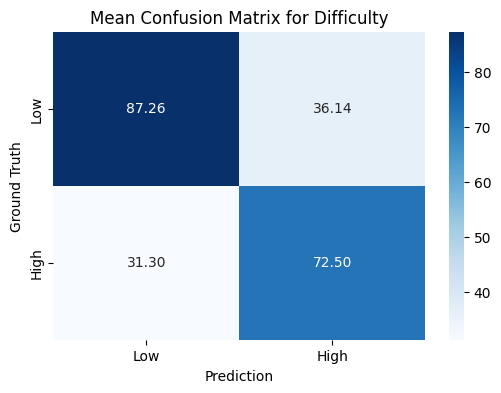

In [373]:
# (Diff) Group-folded nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__hidden_layer_sizes': [(20), (20, 10)],
    'model__alpha': [0.0001, 0.001, 0.01],
    'model__learning_rate_init': [0.001, 0.01, 0.1]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        ('model', MLPClassifier(max_iter=1000, shuffle=True, random_state=random_state))
    ])
    participants_ids = X_diff_scaled_p['participant_id']
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_diff_scaled, y_diff, participants_ids_diff, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }    
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Difficulty')
plt.show()

In [374]:
outer_results['best_params']

[[{'model__alpha': 0.001,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.001,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.01,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.0001,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.0001,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.001}],
 [{'model__alpha': 0.0001,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.0001,
   'model__hidden_layer_sizes': (20, 10),
   'model__learning_rate_init': 0.1},
  {'model__alpha': 0.001,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.01,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.0001,
   'model__hidden_layer_sizes': (20, 10),
   'mo

c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached 

Average Performance across multiple runs:
Accuracy: 64.42%, (~2.03)
Precision: 73.68%, (~0.60)
Recall: 71.26%, (~3.72)
F1 Score: 72.25%, (~2.10)


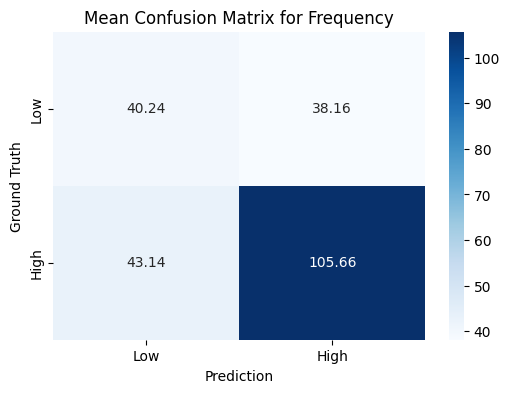

In [375]:
# (Freq) Group-folded nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__hidden_layer_sizes': [(20), (20, 10)],
    'model__alpha': [0.0001, 0.001, 0.01],
    'model__learning_rate_init': [0.001, 0.01, 0.1]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        ('model', MLPClassifier(max_iter=1000, shuffle=True, random_state=random_state))
    ])
    participants_ids = X_freq_scaled_p['participant_id']
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_freq_scaled, y_freq, participants_ids_freq, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)
    
    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }    
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Frequency')
plt.show()

In [376]:
outer_results['best_params']

[[{'model__alpha': 0.01,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.01,
   'model__hidden_layer_sizes': (20, 10),
   'model__learning_rate_init': 0.01},
  {'model__alpha': 0.01,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.0001,
   'model__hidden_layer_sizes': (20, 10),
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.0001,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.01}],
 [{'model__alpha': 0.001,
   'model__hidden_layer_sizes': (20, 10),
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.0001,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.1},
  {'model__alpha': 0.01,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.01,
   'model__hidden_layer_sizes': (20, 10),
   'model__learning_rate_init': 0.1},
  {'model__alpha': 0.001,
   'model__hidden_layer_sizes': 20,
   

##### Undersampled Participant-folded MLP Classifier (Separated)

In [377]:
# Prepare Datasets
df_mlp7_diff = df_diff.copy().dropna()
df_mlp7_diff['difficulty'] = df_mlp7_diff['difficulty'].apply(lambda x: 0 if x == 'Easy' else 1)
participants_ids_diff = df_mlp7_diff.reset_index(drop=True)['participant_id']

df_mlp7_diff_scaled = df_mlp7_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)

X_diff_scaled = df_mlp7_diff_scaled.drop(columns=['difficulty'])
X_diff_scaled_p = X_diff_scaled.copy()
X_diff_scaled_p['participant_id'] = participants_ids_diff
y_diff = df_mlp7_diff_scaled['difficulty']



df_mlp7_freq = df_freq.copy().dropna()
df_mlp7_freq['frequency'] = df_mlp7_freq['frequency'].apply(lambda x: 0 if x == 'Slow' else 1)
participants_ids_freq = df_mlp7_freq.reset_index(drop=True)['participant_id']

df_mlp7_freq_scaled = df_mlp7_freq.groupby('participant_id').apply(scale_by_participant_freq).reset_index(drop=True)

X_freq_scaled = df_mlp7_freq_scaled.drop(columns=['frequency'])
X_freq_scaled_p = X_freq_scaled.copy()
X_freq_scaled_p['participant_id'] = participants_ids_freq
y_freq = df_mlp7_freq_scaled['frequency']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\1200958849.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_mlp7_diff_scaled = df_mlp7_diff.groupby('participant_id').apply(scale_by_participant_diff).reset_index(drop=True)
C:\Users\vale_ad\AppData\Local\Temp\ipykernel_18148\1200958849.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_mlp7_freq_scaled = df_mlp7_freq.groupby('participant_id').a

In [378]:
# Classes (un)balance (NaN dropped)
print(f"Diff Low:\t{len(df_mlp7_diff_scaled.query("difficulty == 0"))}")
print(f"Diff High:\t{len(df_mlp7_diff_scaled.query("difficulty == 1"))}")

print()

print(f"Freq Low:\t{len(df_mlp7_freq_scaled.query("frequency == 0"))}")
print(f"Freq High:\t{len(df_mlp7_freq_scaled.query("frequency == 1"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached 

Average Performance across multiple runs:
Accuracy: 70.46%, (~0.76)
Precision: 66.58%, (~0.78)
Recall: 70.93%, (~1.55)
F1 Score: 68.59%, (~0.98)


c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


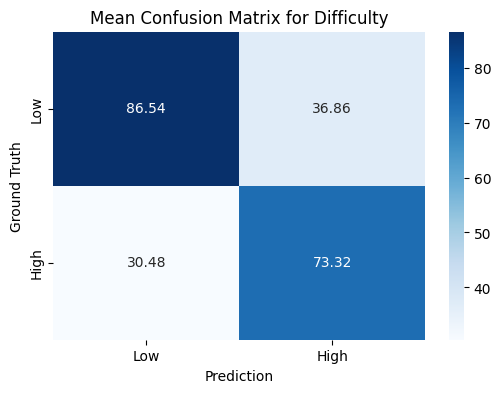

In [379]:
# (Diff) Group-folded nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__hidden_layer_sizes': [(20), (20, 10)],
    'model__alpha': [0.0001, 0.001, 0.01],
    'model__learning_rate_init': [0.001, 0.01, 0.1]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('undersample', RandomUnderSampler(sampling_strategy='auto', random_state=random_state)),
        ('model', MLPClassifier(max_iter=1000, shuffle=True, random_state=random_state))
    ])
    participants_ids = X_diff_scaled_p['participant_id']
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_diff_scaled, y_diff, participants_ids_diff, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }    
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Difficulty')
plt.show()

In [380]:
outer_results['best_params']

[[{'model__alpha': 0.01,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.0001,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.01,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.001,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.01,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.001}],
 [{'model__alpha': 0.01,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.01},
  {'model__alpha': 0.01,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.0001,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.001,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.0001,
   'model__hidden_layer_sizes': 20,
   'model__learning_ra

c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached 

Average Performance across multiple runs:
Accuracy: 63.91%, (~1.67)
Precision: 75.82%, (~1.32)
Recall: 66.29%, (~4.45)
F1 Score: 70.08%, (~2.65)


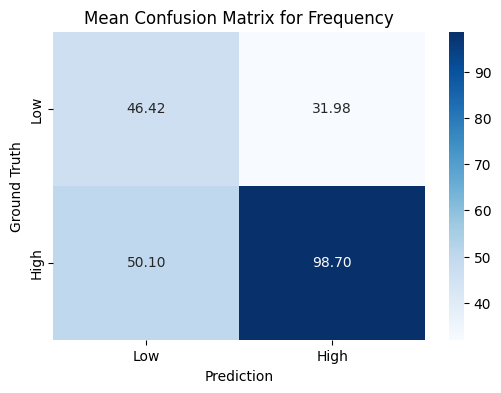

In [381]:
# (Freq) Group-folded nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__hidden_layer_sizes': [(20), (20, 10)],
    'model__alpha': [0.0001, 0.001, 0.01],
    'model__learning_rate_init': [0.001, 0.01, 0.1]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('undersample', RandomUnderSampler(sampling_strategy='auto', random_state=random_state)),
        ('model', MLPClassifier(max_iter=1000, shuffle=True, random_state=random_state))
    ])
    participants_ids = X_freq_scaled_p['participant_id']
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_freq_scaled, y_freq, participants_ids_freq, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)
    
    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }    
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred))
        inner_results['recall'].append(recall_score(y_test, y_pred))
        inner_results['f1'].append(f1_score(y_test, y_pred))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix for Frequency')
plt.show()

In [382]:
outer_results['best_params']

[[{'model__alpha': 0.01,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.01,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.001,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.001,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.01,
   'model__hidden_layer_sizes': (20, 10),
   'model__learning_rate_init': 0.001}],
 [{'model__alpha': 0.001,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.01,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.0001,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.01,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.01,
   'model__hidden_layer_sizes': 20,
   'model__learnin

##### Participant-folded MLP (MultiClass)

In [49]:
# Prepare Dataset
df_mlp9 = df.copy().dropna()
df_mlp9_scaled = df_mlp9.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)
participants_ids = df_mlp9.reset_index(drop=True)['participant_id']

X_scaled = df_mlp9_scaled.drop(columns=['condition'])
X_scaled_p = X_scaled.copy()
X_scaled_p['participant_id'] = participants_ids
y = df_mlp9_scaled['condition']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_17796\4017610555.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_mlp9_scaled = df_mlp9.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [50]:
# Classes unbalance (NaN dropped)
print(f"Diff Low:\t{len(df_mlp9_scaled.query("condition == 'Easy_Slow' | condition == 'Easy_Fast'"))}")
print(f"Diff High:\t{len(df_mlp9_scaled.query("condition == 'Hard_Slow' | condition == 'Hard_Fast'"))}")

print()

print(f"Freq Low:\t{len(df_mlp9_scaled.query("condition == 'Easy_Slow' | condition == 'Hard_Slow'"))}")
print(f"Freq High:\t{len(df_mlp9_scaled.query("condition == 'Easy_Fast' | condition == 'Hard_Fast'"))}")

print()
print()

print(f"Easy Slow:\t{len(df_mlp9_scaled.query("condition == 'Easy_Slow'"))}")
print(f"Easy Fast:\t{len(df_mlp9_scaled.query("condition == 'Easy_Fast'"))}")
print(f"Hard Slow:\t{len(df_mlp9_scaled.query("condition == 'Hard_Slow'"))}")
print(f"Hard Fast:\t{len(df_mlp9_scaled.query("condition == 'Hard_Fast'"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


Easy Slow:	205
Easy Fast:	412
Hard Slow:	187
Hard Fast:	332


c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached 

Average Performance across multiple runs:
Accuracy: 46.69%, (~2.00)
Precision: 44.27%, (~2.20)
Recall: 43.82%, (~1.97)
F1 Score: 43.65%, (~2.07)


c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


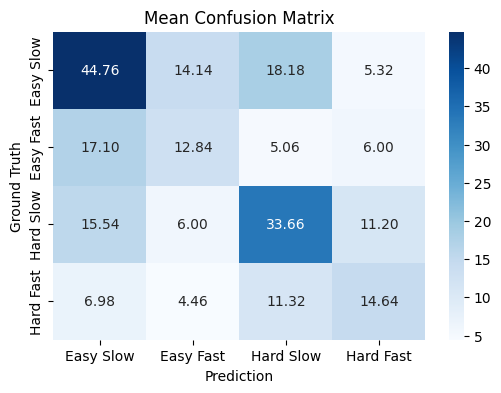

In [51]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__hidden_layer_sizes': [(20), (20, 10), (40, 20, 10)],
    'model__alpha': [0.0001, 0.001, 0.01],
    'model__learning_rate_init': [0.001, 0.01, 0.1]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        # ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        # ('undersample', RandomUnderSampler(sampling_strategy='auto', random_state=random_state)),
        ('model', MLPClassifier(max_iter=1000, shuffle=True, random_state=random_state))
    ])
    participants_ids = X_scaled_p['participant_id']
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_scaled, y, participants_ids, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='recall_macro', refit='recall_macro', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred, average='macro', zero_division=0))
        inner_results['recall'].append(recall_score(y_test, y_pred, average='macro'))
        inner_results['f1'].append(f1_score(y_test, y_pred, average='macro'))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred, labels=class_order))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")
conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

In [52]:
outer_results['best_params']

[[{'model__alpha': 0.01,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.001,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.1},
  {'model__alpha': 0.0001,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.01,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.001,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.01}],
 [{'model__alpha': 0.001,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.1},
  {'model__alpha': 0.01,
   'model__hidden_layer_sizes': (40, 20, 10),
   'model__learning_rate_init': 0.01},
  {'model__alpha': 0.01,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.001,
   'model__hidden_layer_sizes': (20, 10),
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.0001,
   'model__hidden_layer_sizes': 20,
   'model__

##### Oversampled Participant-folded MLP (MultiClass)

In [53]:
# Prepare Dataset
df_mlp9 = df.copy().dropna()
df_mlp9_scaled = df_mlp9.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)
participants_ids = df_mlp9.reset_index(drop=True)['participant_id']

X_scaled = df_mlp9_scaled.drop(columns=['condition'])
X_scaled_p = X_scaled.copy()
X_scaled_p['participant_id'] = participants_ids
y = df_mlp9_scaled['condition']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_17796\4017610555.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_mlp9_scaled = df_mlp9.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [54]:
# Classes unbalance (NaN dropped)
print(f"Diff Low:\t{len(df_mlp9_scaled.query("condition == 'Easy_Slow' | condition == 'Easy_Fast'"))}")
print(f"Diff High:\t{len(df_mlp9_scaled.query("condition == 'Hard_Slow' | condition == 'Hard_Fast'"))}")

print()

print(f"Freq Low:\t{len(df_mlp9_scaled.query("condition == 'Easy_Slow' | condition == 'Hard_Slow'"))}")
print(f"Freq High:\t{len(df_mlp9_scaled.query("condition == 'Easy_Fast' | condition == 'Hard_Fast'"))}")

print()
print()

print(f"Easy Slow:\t{len(df_mlp9_scaled.query("condition == 'Easy_Slow'"))}")
print(f"Easy Fast:\t{len(df_mlp9_scaled.query("condition == 'Easy_Fast'"))}")
print(f"Hard Slow:\t{len(df_mlp9_scaled.query("condition == 'Hard_Slow'"))}")
print(f"Hard Fast:\t{len(df_mlp9_scaled.query("condition == 'Hard_Fast'"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


Easy Slow:	205
Easy Fast:	412
Hard Slow:	187
Hard Fast:	332


c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached 

Average Performance across multiple runs:
Accuracy: 45.09%, (~0.98)
Precision: 43.19%, (~1.01)
Recall: 43.75%, (~0.96)
F1 Score: 43.00%, (~0.97)


c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


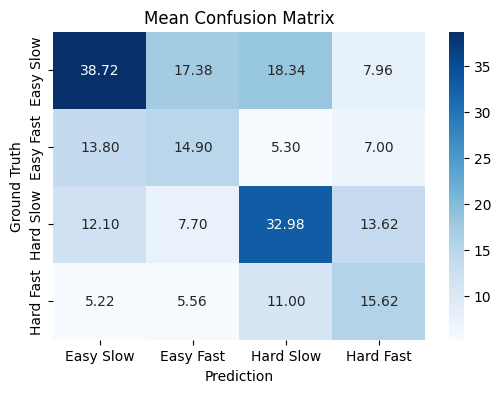

In [55]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__hidden_layer_sizes': [(20), (20, 10), (40, 20, 10)],
    'model__alpha': [0.0001, 0.001, 0.01],
    'model__learning_rate_init': [0.001, 0.01, 0.1]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        # ('undersample', RandomUnderSampler(sampling_strategy='auto', random_state=random_state)),
        ('model', MLPClassifier(max_iter=1000, shuffle=True, random_state=random_state))
    ])
    participants_ids = X_scaled_p['participant_id']
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_scaled, y, participants_ids, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='recall_macro', refit='recall_macro', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred, average='macro', zero_division=0))
        inner_results['recall'].append(recall_score(y_test, y_pred, average='macro'))
        inner_results['f1'].append(f1_score(y_test, y_pred, average='macro'))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred, labels=class_order))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

In [56]:
outer_results['best_params']

[[{'model__alpha': 0.0001,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.1},
  {'model__alpha': 0.01,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.001,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.01,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.001,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.001}],
 [{'model__alpha': 0.0001,
   'model__hidden_layer_sizes': (20, 10),
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.0001,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.001,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.01},
  {'model__alpha': 0.0001,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.1},
  {'model__alpha': 0.001,
   'model__hidden_layer_sizes': 20,
   'model__learn

##### Undersampled Participant-folded MLP (MultiClass)

In [57]:
# Prepare Dataset
df_mlp9 = df.copy().dropna()
df_mlp9_scaled = df_mlp9.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)
participants_ids = df_mlp9.reset_index(drop=True)['participant_id']

X_scaled = df_mlp9_scaled.drop(columns=['condition'])
X_scaled_p = X_scaled.copy()
X_scaled_p['participant_id'] = participants_ids
y = df_mlp9_scaled['condition']

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_17796\4017610555.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_mlp9_scaled = df_mlp9.groupby('participant_id').apply(scale_by_participant).reset_index(drop=True)


In [58]:
# Classes unbalance (NaN dropped)
print(f"Diff Low:\t{len(df_mlp9_scaled.query("condition == 'Easy_Slow' | condition == 'Easy_Fast'"))}")
print(f"Diff High:\t{len(df_mlp9_scaled.query("condition == 'Hard_Slow' | condition == 'Hard_Fast'"))}")

print()

print(f"Freq Low:\t{len(df_mlp9_scaled.query("condition == 'Easy_Slow' | condition == 'Hard_Slow'"))}")
print(f"Freq High:\t{len(df_mlp9_scaled.query("condition == 'Easy_Fast' | condition == 'Hard_Fast'"))}")

print()
print()

print(f"Easy Slow:\t{len(df_mlp9_scaled.query("condition == 'Easy_Slow'"))}")
print(f"Easy Fast:\t{len(df_mlp9_scaled.query("condition == 'Easy_Fast'"))}")
print(f"Hard Slow:\t{len(df_mlp9_scaled.query("condition == 'Hard_Slow'"))}")
print(f"Hard Fast:\t{len(df_mlp9_scaled.query("condition == 'Hard_Fast'"))}")

Diff Low:	617
Diff High:	519

Freq Low:	392
Freq High:	744


Easy Slow:	205
Easy Fast:	412
Hard Slow:	187
Hard Fast:	332


c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached 

Average Performance across multiple runs:
Accuracy: 43.61%, (~1.24)
Precision: 42.92%, (~0.96)
Recall: 43.86%, (~0.95)
F1 Score: 42.50%, (~1.07)


c:\Users\vale_ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


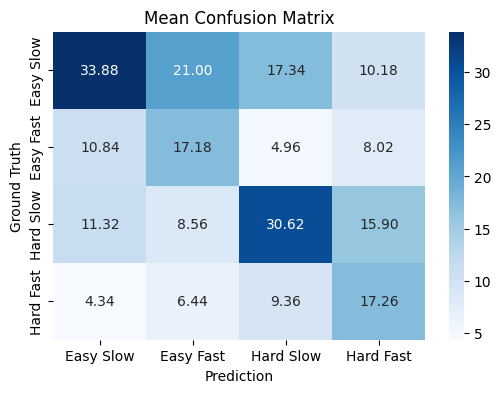

In [59]:
# Stratified nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid = {
    'model__hidden_layer_sizes': [(20), (20, 10), (40, 20, 10)],
    'model__alpha': [0.0001, 0.001, 0.01],
    'model__learning_rate_init': [0.001, 0.01, 0.1]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params': []
}

for random_state in range(1, 11):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        # ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        ('undersample', RandomUnderSampler(sampling_strategy='auto', random_state=random_state)),
        ('model', MLPClassifier(max_iter=1000, shuffle=True, random_state=random_state))
    ])
    participants_ids = X_scaled_p['participant_id']
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_scaled, y, participants_ids, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        
        inner_cv = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, scoring='recall_macro', refit='recall_macro', n_jobs=-1)
        grid_search.fit(X_train, y_train, groups=participants_ids_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        inner_results['accuracy'].append(accuracy_score(y_test, y_pred))
        inner_results['precision'].append(precision_score(y_test, y_pred, average='macro', zero_division=0))
        inner_results['recall'].append(recall_score(y_test, y_pred, average='macro'))
        inner_results['f1'].append(f1_score(y_test, y_pred, average='macro'))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test, y_pred, labels=class_order))
        inner_results['best_params'].append(grid_search.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params'].append(inner_results['best_params'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

In [60]:
outer_results['best_params']

[[{'model__alpha': 0.0001,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.001,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.01,
   'model__hidden_layer_sizes': (40, 20, 10),
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.0001,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.001,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.01}],
 [{'model__alpha': 0.01,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.01,
   'model__hidden_layer_sizes': (20, 10),
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.001,
   'model__hidden_layer_sizes': 20,
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.001,
   'model__hidden_layer_sizes': (20, 10),
   'model__learning_rate_init': 0.001},
  {'model__alpha': 0.001,
   'model__hidden_layer_sizes': (20

### 7. Stacked Best Models

##### Oversampled SVC + GBM

In [4]:
# Prepare Datasets
diff_feat_list = df_diff.drop(columns=['participant_id', 'difficulty']).columns.to_list()
freq_feat_list = df_freq.drop(columns=['participant_id', 'frequency']).columns.to_list()

df_stacked = pd.merge(df_diff, df_freq).dropna()
df_stacked['difficulty'] = df_stacked['difficulty'].apply(lambda x: 0 if x == 'Easy' else 1)
df_stacked['frequency'] = df_stacked['frequency'].apply(lambda x: 0 if x == 'Slow' else 1)
participants_ids = df_stacked.reset_index(drop=True)['participant_id']

def scale_by_participant_stacked(group):
    scaler = StandardScaler()
    features = group.drop(columns=['participant_id', 'difficulty', 'frequency'])
    group_scaled = pd.DataFrame(scaler.fit_transform(features), columns=features.columns, index=group.index)
    return pd.concat([group_scaled, group[['difficulty', 'frequency']]], axis=1)
df_stacked_scaled = df_stacked.groupby('participant_id').apply(scale_by_participant_stacked).reset_index(drop=True)

X_scaled = df_stacked_scaled.drop(columns=['difficulty'])
X_scaled_p = X_scaled.copy()
X_scaled_p['participant_id'] = participants_ids
y = df_stacked_scaled[['difficulty', 'frequency']]

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_15792\1449448882.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_stacked_scaled = df_stacked.groupby('participant_id').apply(scale_by_participant_stacked).reset_index(drop=True)


Average Performance across multiple runs:
Accuracy: 47.22%, (~0.31)
Precision: 47.91%, (~0.39)
Recall: 39.64%, (~0.43)
F1 Score: 37.65%, (~0.63)


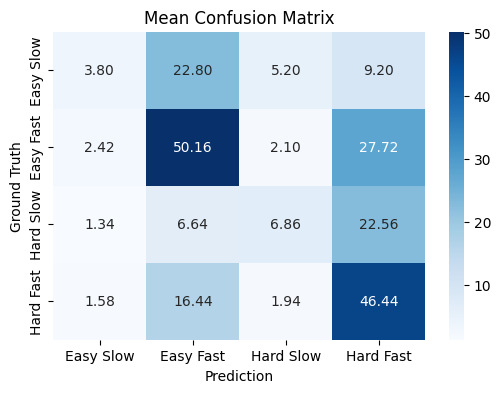

In [5]:
# Staked Group-folded nested cross-validation (with multiple runs) and hyper-parameter tuning
param_grid_diff = {
    'model__C': [0.1, 1, 10, 100, 1000]
}
param_grid_freq = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [1, 2, 3, 5]
}
outer_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': [],
    'best_params_diff': [],
    'best_params_freq': []
}

for random_state in range(1, 11):
    pipeline_diff = ImbPipeline([
        ('scaler', StandardScaler()),
        ('oversample', SMOTE(sampling_strategy='auto', random_state=random_state)),
        ('model', SVC(kernel='linear', random_state=random_state))
    ])
    pipeline_freq = ImbPipeline([
        ('scaler', StandardScaler()),
        ('model', GradientBoostingClassifier(random_state=random_state))
    ])
    
    participants_ids = X_scaled_p.reset_index(drop=True)['participant_id']
    X_shuffled, y_shuffled, pid_shuffled = shuffle(X_scaled, y, participants_ids, random_state=random_state)
    outer_cv = GroupKFold(n_splits=5)

    inner_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': [],
        'best_params_diff': [],
        'best_params_freq': []
    }
    for train_idx, test_idx in outer_cv.split(X_shuffled, y_shuffled, groups=pid_shuffled):
        X_train, X_test = X_shuffled.iloc[train_idx], X_shuffled.iloc[test_idx]
        y_train, y_test = y_shuffled.iloc[train_idx], y_shuffled.iloc[test_idx]
        participants_ids_train = pid_shuffled.iloc[train_idx]
        inner_cv = GroupKFold(n_splits=5)

        # difficulty
        X_train_diff, X_test_diff = X_train[diff_feat_list], X_test[diff_feat_list]
        y_train_diff, y_test_diff = y_train['difficulty'], y_test['difficulty']

        grid_search_diff = GridSearchCV(estimator=pipeline_diff, param_grid=param_grid_diff, cv=inner_cv, scoring='accuracy', refit='accuracy', n_jobs=-1)
        grid_search_diff.fit(X_train_diff, y_train_diff, groups=participants_ids_train)

        best_model_diff = grid_search_diff.best_estimator_
        y_pred_diff = best_model_diff.predict(X_test_diff)

        # frequency
        X_train_freq, X_test_freq = X_train[freq_feat_list], X_test[freq_feat_list]
        y_train_freq, y_test_freq = y_train['frequency'], y_test['frequency']
        
        grid_search_freq = GridSearchCV(estimator=pipeline_freq, param_grid=param_grid_freq, cv=inner_cv, scoring='f1', refit='f1', n_jobs=-1)
        grid_search_freq.fit(X_train_freq, y_train_freq, groups=participants_ids_train)

        best_model_freq = grid_search_freq.best_estimator_
        y_pred_freq = best_model_freq.predict(X_test_freq)

        # combine
        y_pred_cond = ( (y_pred_diff * 2) + (y_pred_freq) )
        y_test_cond = ( (y_test_diff * 2) + (y_test_freq) )

        inner_results['accuracy'].append(accuracy_score(y_test_cond, y_pred_cond))
        inner_results['precision'].append(precision_score(y_test_cond, y_pred_cond, average='macro'))
        inner_results['recall'].append(recall_score(y_test_cond, y_pred_cond, average='macro'))
        inner_results['f1'].append(f1_score(y_test_cond, y_pred_cond, average='macro'))
        inner_results['confusion_matrices'].append(confusion_matrix(y_test_cond, y_pred_cond))
        inner_results['best_params_diff'].append(grid_search_diff.best_params_)
        inner_results['best_params_freq'].append(grid_search_freq.best_params_)

    outer_results['accuracy'].append(np.mean(inner_results['accuracy']))
    outer_results['precision'].append(np.mean(inner_results['precision']))
    outer_results['recall'].append(np.mean(inner_results['recall']))
    outer_results['f1'].append(np.mean(inner_results['f1']))
    outer_results['confusion_matrices'].append(np.mean(inner_results['confusion_matrices'], axis=0))
    outer_results['best_params_diff'].append(inner_results['best_params_diff'])
    outer_results['best_params_freq'].append(inner_results['best_params_freq'])

print("Average Performance across multiple runs:")
print(f"Accuracy: {np.mean(outer_results['accuracy'])*100:.2f}%, (~{np.std(outer_results['accuracy'])*100:.2f})")
print(f"Precision: {np.mean(outer_results['precision'])*100:.2f}%, (~{np.std(outer_results['precision'])*100:.2f})")
print(f"Recall: {np.mean(outer_results['recall'])*100:.2f}%, (~{np.std(outer_results['recall'])*100:.2f})")
print(f"F1 Score: {np.mean(outer_results['f1'])*100:.2f}%, (~{np.std(outer_results['f1'])*100:.2f})")

conf_mat = np.mean(outer_results['confusion_matrices'], axis=0)/(len(X_scaled)/5)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Mean Confusion Matrix')
plt.show()

In [6]:
outer_results['best_params_diff']

[[{'model__C': 1000},
  {'model__C': 1},
  {'model__C': 1000},
  {'model__C': 1000},
  {'model__C': 1}],
 [{'model__C': 1000},
  {'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 1}],
 [{'model__C': 10},
  {'model__C': 1000},
  {'model__C': 10},
  {'model__C': 10},
  {'model__C': 0.1}],
 [{'model__C': 10},
  {'model__C': 0.1},
  {'model__C': 10},
  {'model__C': 0.1},
  {'model__C': 0.1}],
 [{'model__C': 10},
  {'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 1},
  {'model__C': 10}],
 [{'model__C': 100},
  {'model__C': 1000},
  {'model__C': 0.1},
  {'model__C': 10},
  {'model__C': 100}],
 [{'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 1},
  {'model__C': 1},
  {'model__C': 1000}],
 [{'model__C': 1},
  {'model__C': 0.1},
  {'model__C': 1000},
  {'model__C': 0.1},
  {'model__C': 10}],
 [{'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 10},
  {'model__C': 0.1}],
 [{'model__C': 0.1},
  {'model__C': 0.1},
  {'model__C': 1},
 

In [7]:
outer_results['best_params_freq']

[[{'model__learning_rate': 0.1,
   'model__max_depth': 1,
   'model__n_estimators': 50},
  {'model__learning_rate': 0.1,
   'model__max_depth': 1,
   'model__n_estimators': 100},
  {'model__learning_rate': 0.01,
   'model__max_depth': 3,
   'model__n_estimators': 100},
  {'model__learning_rate': 0.01,
   'model__max_depth': 2,
   'model__n_estimators': 100},
  {'model__learning_rate': 0.01,
   'model__max_depth': 2,
   'model__n_estimators': 100}],
 [{'model__learning_rate': 0.1,
   'model__max_depth': 1,
   'model__n_estimators': 50},
  {'model__learning_rate': 0.1,
   'model__max_depth': 1,
   'model__n_estimators': 100},
  {'model__learning_rate': 0.01,
   'model__max_depth': 3,
   'model__n_estimators': 100},
  {'model__learning_rate': 0.01,
   'model__max_depth': 2,
   'model__n_estimators': 100},
  {'model__learning_rate': 0.01,
   'model__max_depth': 2,
   'model__n_estimators': 100}],
 [{'model__learning_rate': 0.1,
   'model__max_depth': 1,
   'model__n_estimators': 50},
  {'m

### 8. Results Table

In [3]:
# Built Table (Diff)
rq3_data_diff = {
    "Model": ["Support Vector", "Decision Tree", "Random Forest", "Gradient Boosting", "XGBoost", "Multilayer Perceptron"],
    "No-Resampling (Mean)": [.7018, .6055, .7004, .6948, .7350, .6883],
    "No-Resampling (Std)": [  0.00,  0.71,  0.74,  0.73,  0.87,  1.63],
    "Undersampling (Mean)": [.7511, .6295, .7142, .7290, .7246, .7093],
    "Undersampling (Std)": [  0.57,  2.80,  0.99,  1.04,  1.48,  1.55],
    "Oversampling (Mean)":  [.7531, .6155, .6913, .7269, .7255, .7044],
    "Oversampling (Std)":  [  0.55,  2.90,  0.77,  1.43,  1.05,  0.98],
}; df_recall = pd.DataFrame(rq3_data_diff)
df_recall.columns = pd.MultiIndex.from_tuples([
    ('Model', ''),
    ('No-Resampling', 'Avg'),
    ('No-Resampling', 'Std'),
    ('Undersampling', 'Avg'),
    ('Undersampling', 'Std'),
    ('Oversampling', 'Avg'),
    ('Oversampling', 'Std'),
])
df_recall.style.format({
    ('No-Resampling', 'Avg'): lambda x: "{:.2%}".format(x),
    ('No-Resampling', 'Std'): lambda x: "{:.2f}".format(x),
    ('Undersampling', 'Avg'): lambda x: "{:.2%}".format(x),
    ('Undersampling', 'Std'): lambda x: "{:.2f}".format(x),
    ('Oversampling', 'Avg'): lambda x: "{:.2%}".format(x),
    ('Oversampling', 'Std'): lambda x: "{:.2f}".format(x),
}).set_caption("Recall Results for Difficulty Prediction"
)

In [4]:
# Built Table (Freq)
rq3_data_freq = {
    "Model": ["Support Vector", "Decision Tree", "Random Forest", "Gradient Boosting", "XGBoost", "Multilayer Perceptron"],
    "No-Resampling (Mean)": [.9037, .6835, .8785, .9470, .7656, .7955],
    "No-Resampling (Std)": [  0.00,  0.87,  0.42,  0.36,  1.52,  2.62],
    "Undersampling (Mean)": [.8756, .6365, .6564, .6499, .6628, .6629],
    "Undersampling (Std)": [  0.62,  6.21,  1.04,  1.32,  1.13,  4.45],
    "Oversampling (Mean)":  [.8778, .6077, .7345, .6799, .7040, .7126],
    "Oversampling (Std)":  [  0.28,  2.77,  0.82,  1.58,  1.64,  3.72],
}
df_recall = pd.DataFrame(rq3_data_freq)
df_recall.columns = pd.MultiIndex.from_tuples([
    ('Model', ''),
    ('No-Resampling', 'Avg'),
    ('No-Resampling', 'Std'),
    ('Undersampling', 'Avg'),
    ('Undersampling', 'Std'),
    ('Oversampling', 'Avg'),
    ('Oversampling', 'Std'),
])
df_recall.style.format({
    ('No-Resampling', 'Avg'): lambda x: "{:.2%}".format(x),
    ('No-Resampling', 'Std'): lambda x: "{:.2f}".format(x),
    ('Undersampling', 'Avg'): lambda x: "{:.2%}".format(x),
    ('Undersampling', 'Std'): lambda x: "{:.2f}".format(x),
    ('Oversampling', 'Avg'): lambda x: "{:.2%}".format(x),
    ('Oversampling', 'Std'): lambda x: "{:.2f}".format(x),
}).set_caption("Recall Results for Frequency Prediction"
)

In [5]:
# Built Table (Mult)
rq3_data_mult = {
    "Model": ["Support Vector", "Decision Tree", "Random Forest", "Gradient Boosting", "XGBoost", "Multilayer Perceptron", "Stacked Models"],
    "No-Resampling (Mean)": [.4691, .3703, .4726, .4237, .4472, .4382, .3964],
    "No-Resampling (Std)": [  0.07,  0.15,  0.89,  0.51,  0.86,  1.97,  0.43],
    "Undersampling (Mean)": [.4792, .3518, .4689, .4438, .4634, .4386, '-'],
    "Undersampling (Std)": [  0.72,  1.85,  0.99,  1.13,  0.82,  0.95, '-'],
    "Oversampling (Mean)":  [.4946, .3620, .4759, .4613, .4739, .4375, '-'],
    "Oversampling (Std)":  [  0.69,  1.20,  0.80,  1.30,  0.93,  0.96, '-'],
}
df_recall = pd.DataFrame(rq3_data_mult)
df_recall.columns = pd.MultiIndex.from_tuples([
    ('Model', ''),
    ('No-Resampling', 'Avg'),
    ('No-Resampling', 'Std'),
    ('Undersampling', 'Avg'),
    ('Undersampling', 'Std'),
    ('Oversampling', 'Avg'),
    ('Oversampling', 'Std'),
])
df_recall.style.format({
    ('No-Resampling', 'Avg'): lambda x: "{:.2%}".format(x),
    ('No-Resampling', 'Std'): lambda x: "{:.2f}".format(x),
    ('Undersampling', 'Avg'): lambda x: "{:.2%}".format(x) if isinstance(x, (int, float)) else x,
    ('Undersampling', 'Std'): lambda x: "{:.2f}".format(x) if isinstance(x, (int, float)) else x,
    ('Oversampling', 'Avg'): lambda x: "{:.2%}".format(x) if isinstance(x, (int, float)) else x,
    ('Oversampling', 'Std'): lambda x: "{:.2f}".format(x) if isinstance(x, (int, float)) else x,
}).set_caption("Recall Results for Multiclass Prediction"
)